In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

from datetime import timedelta

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor


from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam


import sklearn_relief as relief

%matplotlib inline

# Priprava podatkov

In [2]:
raw_data = pd.read_csv("data/dataSem1.txt")


# Merge "datum" into a datetime object
raw_data['datetime'] = pd.to_datetime(raw_data['datum'].apply(str)+' '+raw_data['ura'].apply(str).apply(lambda x: x + ':00:00'))

# Add month, week, day
raw_data["mesec"] = raw_data['datetime'].apply(lambda x: pd.Timestamp(x).month)
raw_data["teden"] = raw_data['datetime'].apply(lambda x: pd.Timestamp(x).week)
raw_data["dan"] = raw_data['datetime'].apply(lambda x: pd.Timestamp(x).dayofyear)

# Add 1 if weekend, else add 0
def is_weekend(e):
    if e in (5, 6):
        return 1
    return 0

raw_data["vikend"] = raw_data['datetime'].apply(lambda x: is_weekend(pd.Timestamp(x).weekday()))

raw_data.head()

datum  ura   regija  stavba        namembnost      povrsina  \
0  2015-12-31   23  zahodna       1  javno_storitvena   4058.095943   
1  2015-12-31   23  zahodna       2     izobrazevalna   9181.510587   
2  2015-12-31   23  zahodna       3     izobrazevalna   6698.492106   
3  2015-12-31   23  zahodna       4      stanovanjska  51394.868630   
4  2015-12-31   23  zahodna       5      stanovanjska   8019.665669   

   leto_izgradnje  temp_zraka  temp_rosisca  oblacnost  ...  pritisk  \
0            2007         9.4          -6.1          0  ...   1017.4   
1            1968         9.4          -6.1          0  ...   1017.4   
2            1970         9.4          -6.1          0  ...   1017.4   
3            2009         9.4          -6.1          0  ...   1017.4   
4            1956         9.4          -6.1          0  ...   1017.4   

   smer_vetra  hitrost_vetra  poraba  norm_poraba            datetime mesec  \
0           0            0.0  130.91   ZELOVISOKA 2015-12-31 23:00:00    12   
1           0            0.0  121.10      SREDNJA 2015-12-31 23:00:00    12   
2           0            0.0   83.89      SREDNJA 2015-12-31 23:00:00    12   
3           0            0.0  294.92        NIZKA 2015-12-31 23:00:00    12   
4           0            0.0   58.41        NIZKA 2015-12-31 23:00:00    12   

   teden  dan  vikend  
0     53  365       0  
1     53  365       0  
2     53  365       0  
3     53  365       0  
4     53  365       0  

[5 rows x 21 columns]

In [3]:
raw_data.describe()

ura         stavba       povrsina  leto_izgradnje  \
count  206785.000000  206785.000000  206785.000000   206785.000000   
mean       13.976454      86.161559   10575.351320     1968.146674   
std         6.900545      55.470688   11848.334423       30.842985   
min         5.000000       1.000000     329.341135     1900.000000   
25%         5.000000      39.000000    3445.121949     1949.000000   
50%        11.000000      77.000000    6619.152944     1968.000000   
75%        23.000000     133.000000   12733.749695     1993.000000   
max        23.000000     193.000000   79000.437662     2017.000000   

          temp_zraka   temp_rosisca      oblacnost       padavine  \
count  206785.000000  206785.000000  206785.000000  206785.000000   
mean       18.907885       3.876773       3.396784       0.263360   
std        11.462381       9.093608       2.722105       2.663209   
min       -10.000000     -22.800000       0.000000      -1.000000   
25%        10.000000      -2.800000       0.000000       0.000000   
50%        19.400000       2.800000       4.000000       0.000000   
75%        27.800000      10.600000       6.000000       0.000000   
max        46.100000      25.000000       9.000000      56.000000   

             pritisk     smer_vetra  hitrost_vetra         poraba  \
count  206785.000000  206785.000000  206785.000000  206785.000000   
mean     1015.082407     170.313756       3.432172     173.571684   
std         7.222709     109.224139       2.278090     251.900302   
min       991.900000       0.000000       0.000000       0.000000   
25%      1009.800000      90.000000       2.100000      38.220000   
50%      1014.100000     170.000000       3.100000      92.700000   
75%      1019.900000     270.000000       4.600000     185.610000   
max      1040.900000     360.000000      14.900000    3095.440000   

               mesec          teden            dan         vikend  
count  206785.000000  206785.000000  206785.000000  206785.000000  
mean        6.464062      26.610238     182.122523       0.287613  
std         3.769743      16.518657     115.540998       0.452651  
min         1.000000       1.000000       1.000000       0.000000  
25%         3.000000      10.000000      69.000000       0.000000  
50%         7.000000      27.000000     184.000000       0.000000  
75%        10.000000      42.000000     291.000000       1.000000  
max        12.000000      53.000000     366.000000       1.000000

# HELPER FUNCTIONS

In [83]:
#################################################################################################################################
##  Add a rolling mean of intervals specified in the array day_intervals for all the attributes specified in the attrs array.  ##
##  Group data by the attribute group_by.                                                                                      ##
##  If min_eq_max is set to False, the values of the initial data points will be computed with the available data.             ##
#################################################################################################################################
def add_rolling_mean(df, group_by, attrs, day_intervals, min_eq_max=True, min_w=1):
    df = df.copy()
    for attr in attrs:
        for interval in day_intervals:
            interval *= 4
            if min_eq_max: 
                min_w = interval
            df[f"{attr}_MA_{int(interval/4)}"] = df.groupby(group_by)[attr].transform(lambda x: x.rolling(interval, min_w).mean())
    return df


##################################################################################
##  Filters the data based on the attribute specified so only on entry is left  ##
##################################################################################
def unique_by_attr(attr):
    ids = pd.unique(raw_data[attr])
    uniq_data = pd.DataFrame()
    for e in ids:
        temp = raw_data[raw_data[attr] == e].head(1)
        uniq_data = uniq_data.append(temp)
    return uniq_data


############################################
##  Hyperparamater tuning for clasifiers  ##
############################################
def DecisionTree_best_max_depth(X_train, y_train, start, end):
    bestN = 0
    bestAcc = 0
    for n in range(start, end + 1):
        clf = DecisionTreeClassifier(max_depth = n, random_state = 0)
        acc = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy',  n_jobs=-1)
        if bestAcc < acc.mean():
            bestAcc = acc.mean()
            bestN = n
    return bestAcc, {"max_depth": bestN}


def KNN_best_n_neighbours(X_train, y_train, start, end):
    bestN = 0
    bestAcc = 0
    for n in range(start, end + 1):
        clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n)
        acc = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy',  n_jobs=-1)
        if bestAcc < acc.mean():
            bestAcc = acc.mean()
            bestN = n
    return bestAcc, {"n_neighbors": bestN}

def BaggingClassifier_best_n(X_train, y_train):
    bestN = 0
    bestAcc = 0
    for n in (10, 25, 50, 100):
        clf = BaggingClassifier(KNeighborsClassifier(),
        max_samples=0.5, max_features=0.5, n_estimators=n, random_state=0, n_jobs=-1)
        acc = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy',  n_jobs=-1)
        if bestAcc < acc.mean():
            bestAcc = acc.mean()
            bestN = n
    return bestAcc, {"n_estimators": bestN}

def Extra_Tree_best_n(X_train, y_train):
    bestN = 0
    bestAcc = 0
    for n in (100, 250, 500):
        clf = ExtraTreesClassifier(n_estimators=n, random_state=0)
        acc = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy',  n_jobs=-1)
        if bestAcc < acc.mean():
            bestAcc = acc.mean()
            bestN = n
    return bestAcc, {"n_estimators": bestN}

###########################################
## Hyperparameter tuning for regression  ##
###########################################

def RegressionTree_best_max_depth(X_train, y_train, start, end, y):
    bestN = 0
    bestAcc = 10000000
    for n in range(start, end + 1):
        clf = DecisionTreeRegressor(random_state = 0, max_depth=n)
        scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']
        cvs = cross_validate(clf, X_train, y_train, cv=10, scoring=scoring,  n_jobs=-1)
        cvs_pred = cross_val_predict(clf, X_train, y_train, n_jobs=-1)
        rmse = RMSE(y_train, cvs_pred, y.mean())
        if bestAcc > rmse:
            bestAcc = rmse
            bestNRMSE = cvs["test_neg_root_mean_squared_error"].mean()
            bestNMAE = cvs["test_neg_mean_absolute_error"].mean()
            bestN = n
    return {"RMSE": bestAcc, "NRMSE": bestNRMSE, "NMAE": bestNMAE}, {"max_depth": bestN}

def RegressionRandomForest_best_max_depth(X_train, y_train, start, end, y):
    bestN = 0
    bestAcc = 10000000
    for n in range(start, end + 1):
        clf = RandomForestRegressor(max_depth=n, random_state=0, n_jobs=-1)
        scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']
        cvs = cross_validate(clf, X_train, y_train, cv=10, scoring=scoring,  n_jobs=-1)
        cvs_pred = cross_val_predict(clf, X_train, y_train, n_jobs=-1)
        rmse = RMSE(y_train, cvs_pred, y.mean())
        if bestAcc > rmse:
            bestAcc = rmse
            bestNRMSE = cvs["test_neg_root_mean_squared_error"].mean()
            bestNMAE = cvs["test_neg_mean_absolute_error"].mean()
            bestN = n
    return {"RMSE": bestAcc, "NRMSE": bestNRMSE, "NMAE": bestNMAE}, {"max_depth": bestN}

def RegressionKNN_best_n_neighbours(X_train, y_train, start, end, y):
    bestN = 0
    bestAcc = 0
    bestAcc = 10000000
    for n in range(start, end + 1):
        clf = KNeighborsRegressor(n_jobs=-1, n_neighbors=n)
        scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error']
        cvs = cross_validate(clf, X_train, y_train, cv=10, scoring=scoring,  n_jobs=-1)
        cvs_pred = cross_val_predict(clf, X_train, y_train, n_jobs=-1)
        rmse = RMSE(y_train, cvs_pred, y.mean())
        if bestAcc > rmse:
            bestAcc = rmse
            bestNRMSE = cvs["test_neg_root_mean_squared_error"].mean()
            bestNMAE = cvs["test_neg_mean_absolute_error"].mean()
            bestN = n
    return {"RMSE": bestAcc, "NRMSE": bestNRMSE, "NMAE": bestNMAE}, {"n_neighbors": bestN}


######################
##  ReliefF wraper  ##
######################
def get_relieff_scores(X_train, y_train):
    relieff = relief.Relief(
        n_features=3,
        random_state=0
    )

    my_transformed_matrix = relieff.fit_transform(
        X_train.to_numpy(),
        y_train.to_numpy()
    )
    
    return relieff.w_ 


###########################################################
##  Pickled data reader                                  ##
##  Pickled data format: dict                            ##
##  dict.key => num. of attributes                       ##
##  dict.value => (validation acc., clf options (dict))  ##
###########################################################
def get_best_from_pickle(file):
    with open(file, "rb") as file:
        data = pickle.load(file)
    bestAcc, bestK, bestOps = 0, 0, 0
    for k, (acc, ops) in data.items():
        if (acc > bestAcc):
            bestAcc = acc
            bestK = k
            bestOps = ops
    return bestK, bestOps, bestAcc 

def get_all_from_pickle(file):
    with open(file, "rb") as file:
        data = pickle.load(file)
    n_features = data.keys()
    acc = [data[e][0] for e in n_features]
    return n_features, acc

def get_best_regression_from_pickle(file):
    with open(file, "rb") as file:
        data = pickle.load(file)
    bestAcc, bestK, bestOps = {"RMSE":10000}, 0, 0
    for k, (acc, ops) in data.items():
        if (bestAcc["RMSE"] > acc["RMSE"]):
            bestAcc = acc
            bestK = k
            bestOps = ops
    return bestK, bestOps, bestAcc["RMSE"], bestAcc["NRMSE"], bestAcc["NMAE"]



####################################################################################################
##  Plot a lineplot of the validation accuracy scores for the all the combinations of attributes.  ##
####################################################################################################
def plot_validation_acc(file):
    n_features, acc = get_all_from_pickle(file)
    sns.lineplot(x=n_features, y=acc, ax=ax[0])

    
def plot_regression_validation_acc(file):
    n_features, acc = get_all_from_pickle(file)
    data = pd.DataFrame({
    "n_features": n_features,
    'RMSE': [e["RMSE"] for e in acc],
    'Root Mean Square Error': [-e["NRMSE"] for e in acc],
    'Mean Absolute Error': [-e["NMAE"] for e in acc],
    })
    data = data.melt(id_vars=["n_features"], var_name="score", value_name="value")
    sns.lineplot(data=data, x="n_features", y="value", hue="score", ax=ax[0])


#################################################################
##  Transform all the attributes with potential negative data. ##
#################################################################
def transform_negative_data(X):
    X["padavine"] = X["padavine"].apply(lambda x: x + 1)
    X["temp_zraka"] = X["temp_zraka"].apply(lambda x: x + 100)
    X["temp_rosisca"] = X["temp_rosisca"].apply(lambda x: x + 100)
    return X


##############################################################
##  Train clf on 1...n moths of data and test on month n+1.  ##
##############################################################  
def validate_by_months(clf, n, prep_data):
    res = dict()
    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    selector = SelectKBest(chi2, k=n)
    selector.fit(X_train, y_train)
    X = X.loc[:, selector.get_support()]
    selected_data = pd.concat([X, y], axis=1)    
    for i in range(1, 12):
        train_data = selected_data.loc[prep_data["mesec"].isin([e for e in range(1, i + 1)])]
        test_data = selected_data.loc[prep_data["mesec"] == i + 1]
        y_train = train_data["norm_poraba"]
        X_train = train_data.drop(columns=["norm_poraba"])
        y_test = test_data["norm_poraba"]
        X_test = test_data.drop(columns=["norm_poraba"])
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred_test)
        print(f"Število mesecev v učni množici: {i}, natančnost: {acc}")
        res[i] = acc
    return res

def validate_regression_by_months(clf, n, prep_data):
    res = dict()
    y = prep_data["poraba"]
    X = prep_data.drop(columns=["poraba"])
    for e in X.select_dtypes(include=['object']).columns:
        X = one_hot(X, e)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    selector = SelectKBest(f_regression, k=n_features)
    selector.fit(X_train, y_train)
    X = X.loc[:, selector.get_support()]
    selected_data = pd.concat([X, y], axis=1)
    for i in range(1, 12):
        train_data = selected_data.loc[prep_data["mesec"].isin([e for e in range(1, i + 1)])]
        test_data = selected_data.loc[prep_data["mesec"] == i + 1]
        y_train = train_data["poraba"]
        X_train = train_data.drop(columns=["poraba"])
        y_test = test_data["poraba"]
        X_test = test_data.drop(columns=["poraba"])
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        rmse = RMSE(y_test, y_pred_test, y.mean())
        print(f"Število mesecev v učni množici: {i}, RMSE: {rmse}")
        res[i] = rmse
    return res

    
################################
##  One hot encoder wrapper.  ##
################################
def one_hot(df, attr):
    df = pd.get_dummies(df, prefix=[attr], columns=[attr])
    return df


def RMSE(y, y_pred, y_mean):
    return np.sum(np.power(y - y_pred, 2)) / np.sum(np.power(y - y_mean, 2))

#######################################################################
##  Helper functions for comparing models trained on single region.  ##  
#######################################################################
def prep_data_by_region(X_train, X_test, cols):
    return X_train.loc[:, cols], X_test.loc[:, cols]

def split_data_by_region_and_split(prep_data, pred_attr, transform_negative=True):
    y = prep_data[pred_attr]
    X = prep_data.drop(columns=[pred_attr])
    if transform_negative:
        X = transform_negative_data(X)
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X, y, X_train, X_test, y_train, y_test


# Grafični prikaz podatkov

## Analiza distribucje in gibanja nekaterih atrubutov

Text(0.5, 1.0, 'Število stavb v posameznih kategorijah namembnosti')

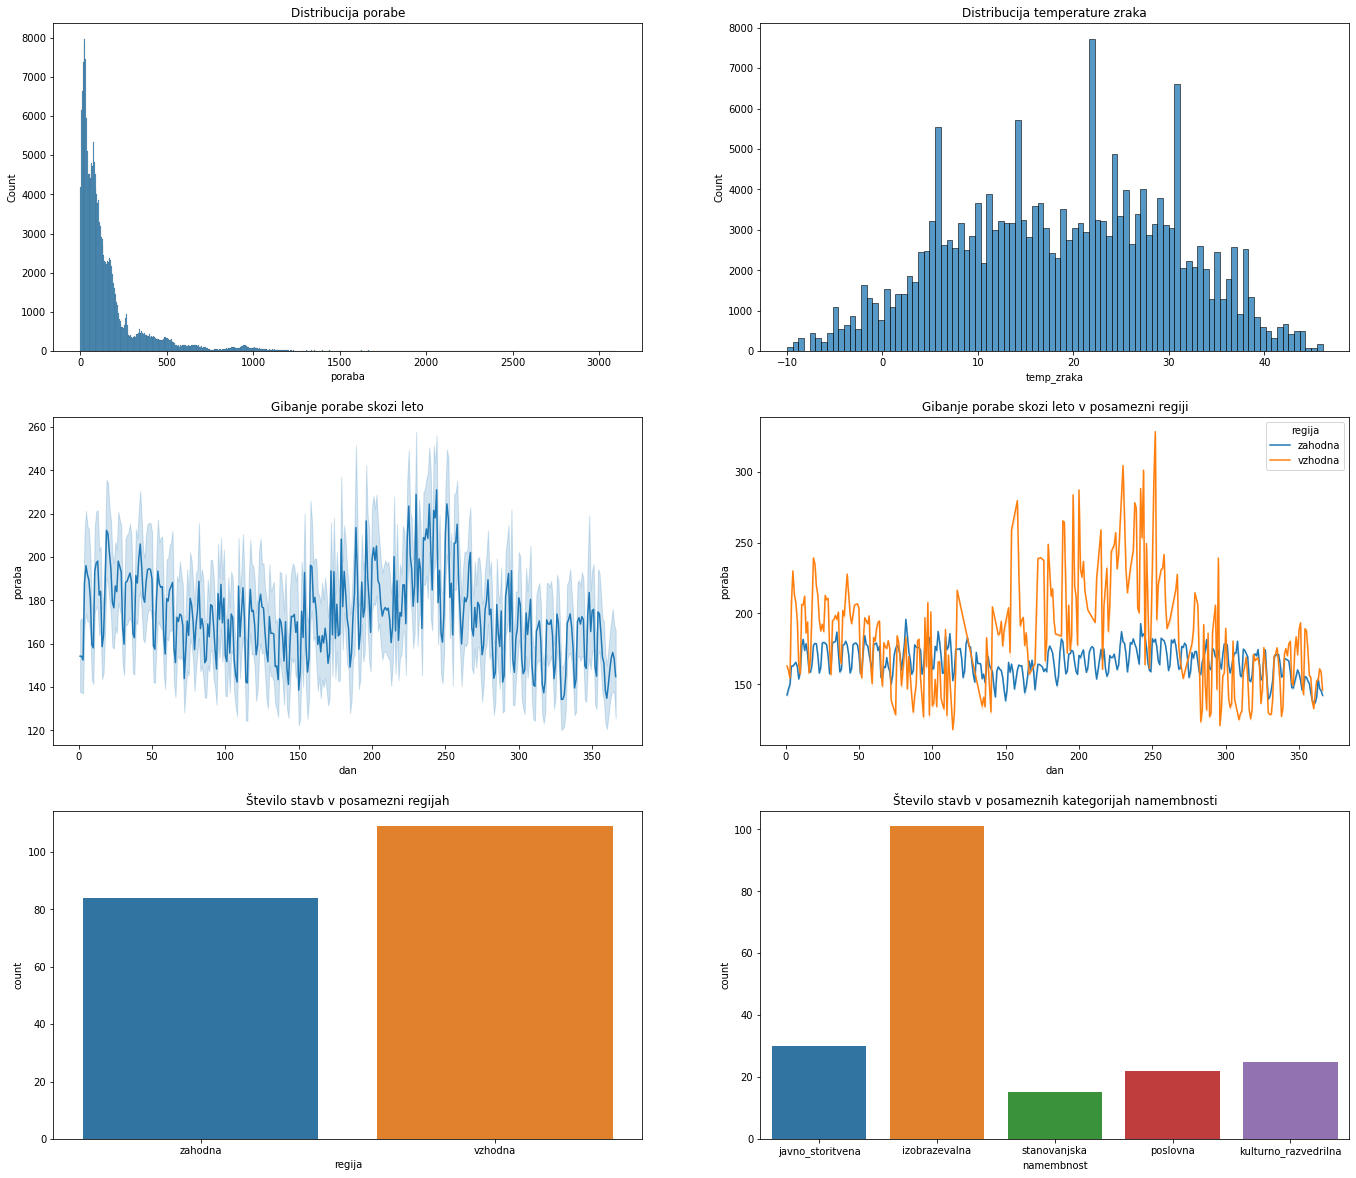

In [122]:
f, ax = plt.subplots(3, 2)
plt.subplots_adjust(left=0, right=3, top=4)


sns.histplot(data=raw_data, x="poraba", ax=ax[0, 0]).set_title('Distribucija porabe')
sns.histplot(data=raw_data, x="temp_zraka", ax=ax[0, 1]).set_title('Distribucija temperature zraka')

sns.lineplot(data=raw_data, x="dan", y="poraba", hue="regija", ax=ax[1, 1], ci=False).set_title('Gibanje porabe skozi leto v posamezni regiji')
sns.lineplot(data=raw_data, x="dan", y="poraba", ax=ax[1, 0]).set_title('Gibanje porabe skozi leto')

sns.countplot(data=unique_by_attr("stavba"), x="regija", ax=ax[2, 0]).set_title('Število stavb v posamezni regijah')
sns.countplot(data=unique_by_attr("stavba"), x="namembnost", ax=ax[2, 1]).set_title('Število stavb v posameznih kategorijah namembnosti')

In [ ]:
###### fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=add_rolling_mean(raw_data, "stavba", ["poraba"], [1 ,7, 14, 28], min_eq_max=False), x="teden", y="poraba", ci=None, ax=ax)
sns.lineplot(data=add_rolling_mean(raw_data, "stavba", ["poraba"], [1 ,7, 14, 28], min_eq_max=False), x="teden", y="poraba_MA_28", ci=None, ax=ax)
sns.lineplot(data=add_rolling_mean(raw_data, "stavba", ["poraba"], [1 ,7, 14, 28], min_eq_max=False), x="teden", y="poraba_MA_14", ci=None, ax=ax)

## Analiza števila meritev

Text(0.5, 1.0, 'Število meritev po regijah')

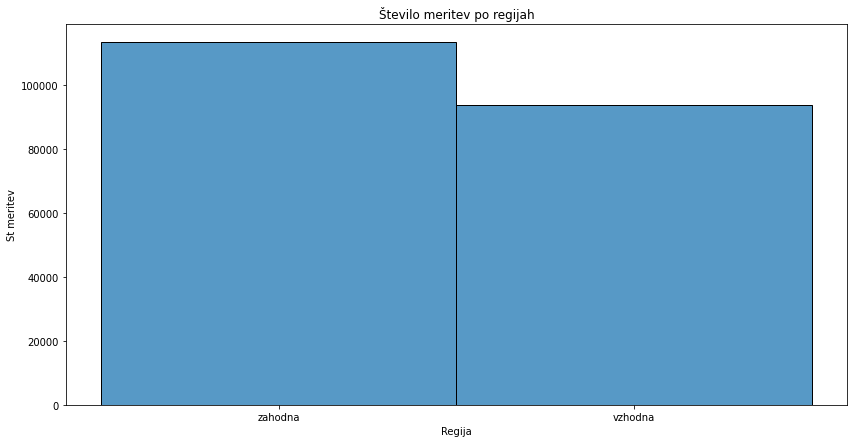

In [21]:
_, ax = plt.subplots(figsize=(14,7))
ax.set(xlabel="Regija", ylabel="St meritev")
sns.histplot(raw_data, x="regija", ax=ax).set_title('Število meritev po regijah')

Text(0.5, 1.0, 'Število meritev na posamezno stavbo')

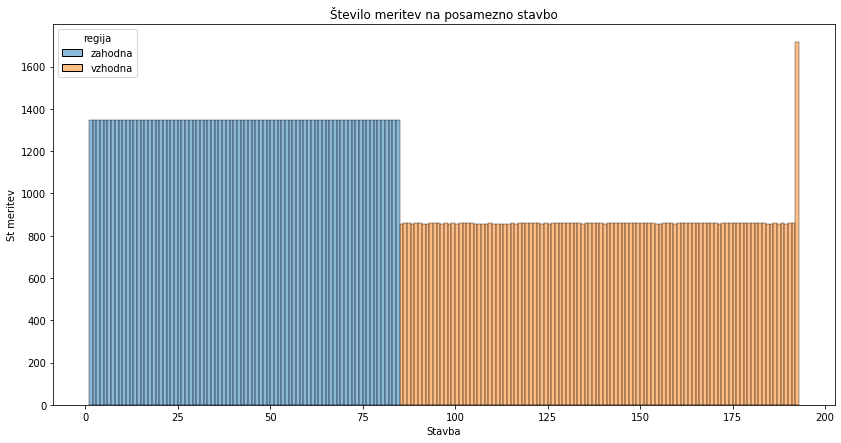

In [19]:
_, ax = plt.subplots(figsize=(14,7))
ax.set(xlabel="Stavba", ylabel="St meritev")
sns.histplot(data=raw_data, x="stavba", stat="count", hue="regija", binwidth=1, ax=ax).set_title('Število meritev na posamezno stavbo')

Text(0.5, 1.0, 'Število meritev po posameznih dnevih v zahodni regiji')

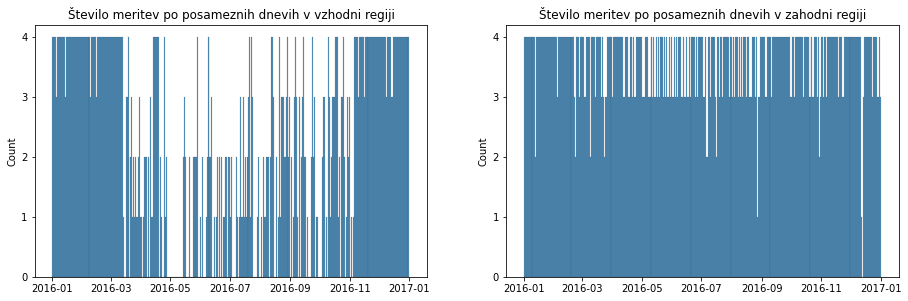

In [26]:
temp_z = raw_data[raw_data["regija"] == "zahodna"]["datetime"]
temp_v = raw_data[raw_data["regija"] == "vzhodna"]["datetime"]

temp_v = pd.unique(temp_v)
temp_z = pd.unique(temp_z)


f, ax = plt.subplots(1, 2)
ax[0].set_yticks([e for e in range(0, 5)])
ax[1].set_yticks([e for e in range(0, 5)])

plt.subplots_adjust(left=0, right=2, top=1)
sns.histplot(data=temp_v, binwidth=1, ax=ax[0]).set_title('Število meritev po posameznih dnevih v vzhodni regiji')
sns.histplot(data=temp_z, binwidth=1, ax=ax[1]).set_title('Število meritev po posameznih dnevih v zahodni regiji')

## Prikaz razlike v povprečni mesečni teperaturi v regijah

Text(0.5, 1.0, 'Povprčna temperatura zraka v regijah')

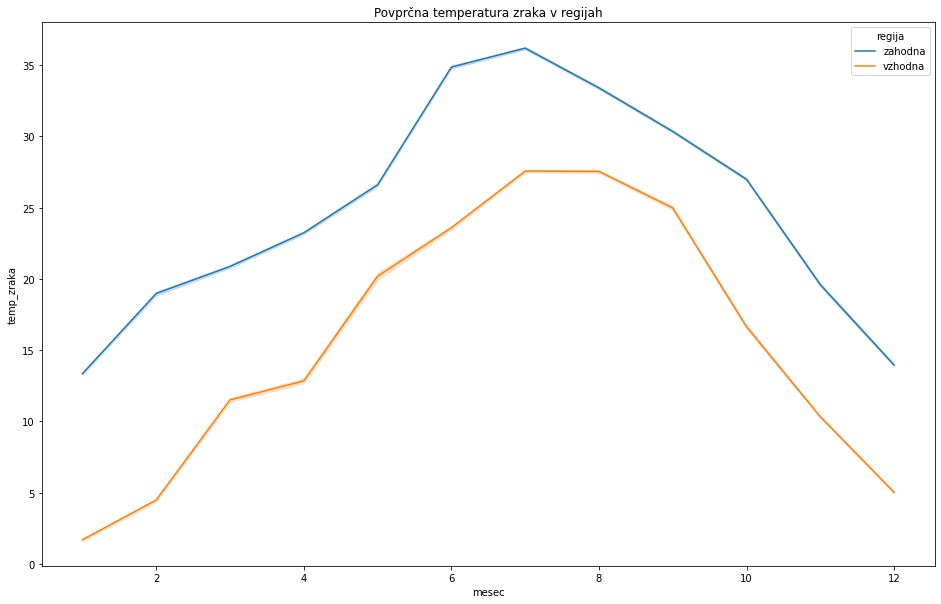

In [27]:
_, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=raw_data, x='mesec', y='temp_zraka', hue='regija', ax=ax).set_title('Povprčna temperatura zraka v regijah')

## Analiza povrsine stavbe glede na njeno namembnost

Text(0.5, 1.0, 'Porazdelitev površina glede na namembnost stavbe')

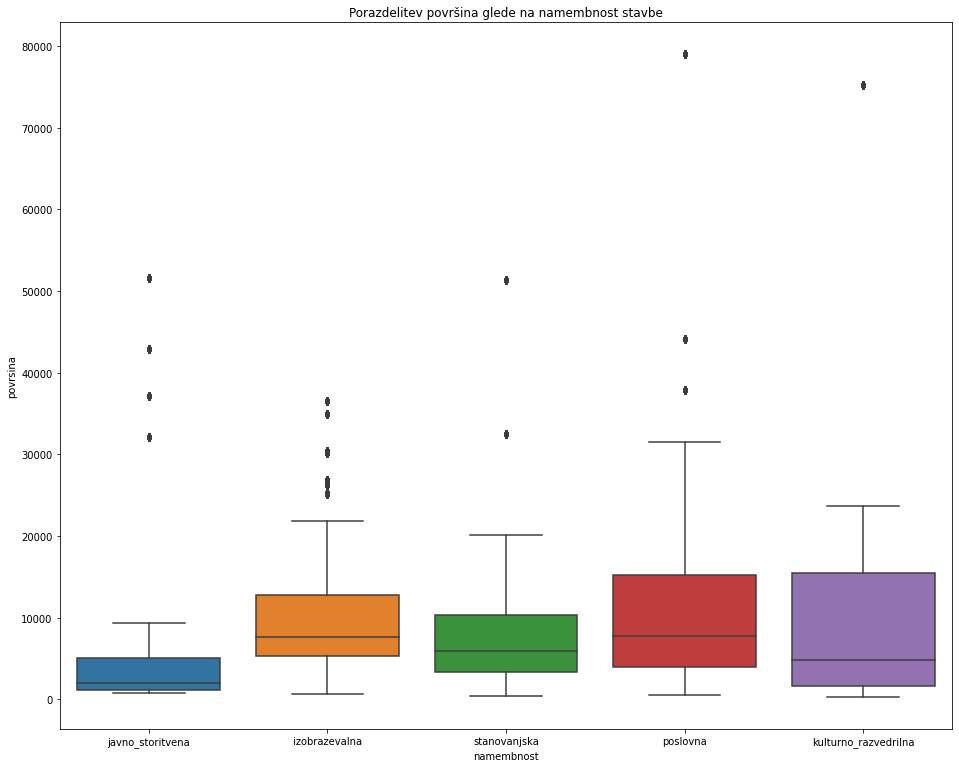

In [32]:
_, ax = plt.subplots(figsize=(16,13))
sns.boxplot(data=raw_data, x="namembnost", y="povrsina", ax=ax).set_title('Porazdelitev površina glede na namembnost stavbe')

## Analiza razlik v poprabi, letu izgradnje in povrsine stavb glede na regijo

Text(0.5, 1.0, 'Porazdelitev površine glede na regijo')

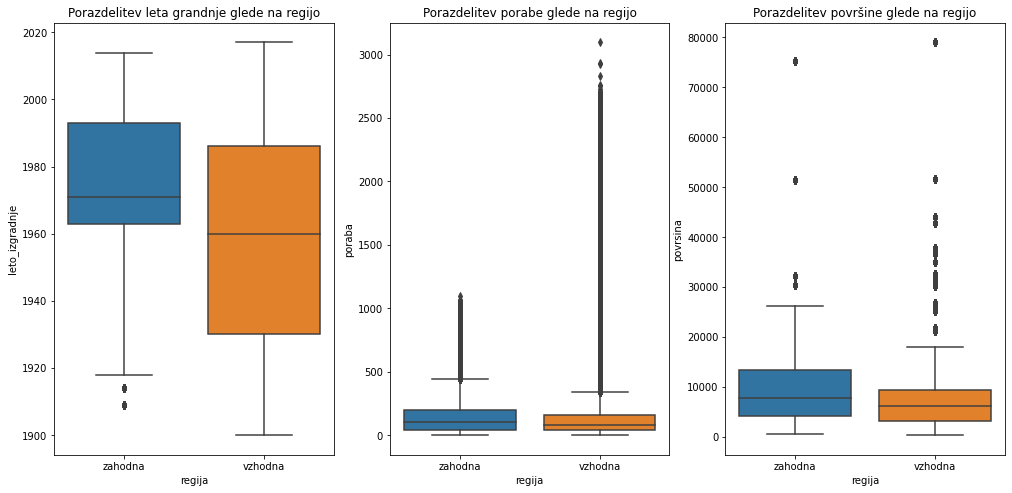

In [35]:
_, axes = plt.subplots(1, 3)
plt.subplots_adjust(left=0, right=2.2, top=1.5, bottom=0)
sns.boxplot(data=raw_data, x="regija", y="leto_izgradnje", ax=axes[0]).set_title('Porazdelitev leta grandnje glede na regijo')

sns.boxplot(data=raw_data, x="regija", y="poraba", ax=axes[1]).set_title('Porazdelitev porabe glede na regijo')

sns.boxplot(data=raw_data, x="regija", y="povrsina", ax=axes[2]).set_title('Porazdelitev površine glede na regijo')

## Podorbnejsa analiza stavb glede na regijo

Text(0.5, 1.0, 'Površina stavb glede na namepbnost')

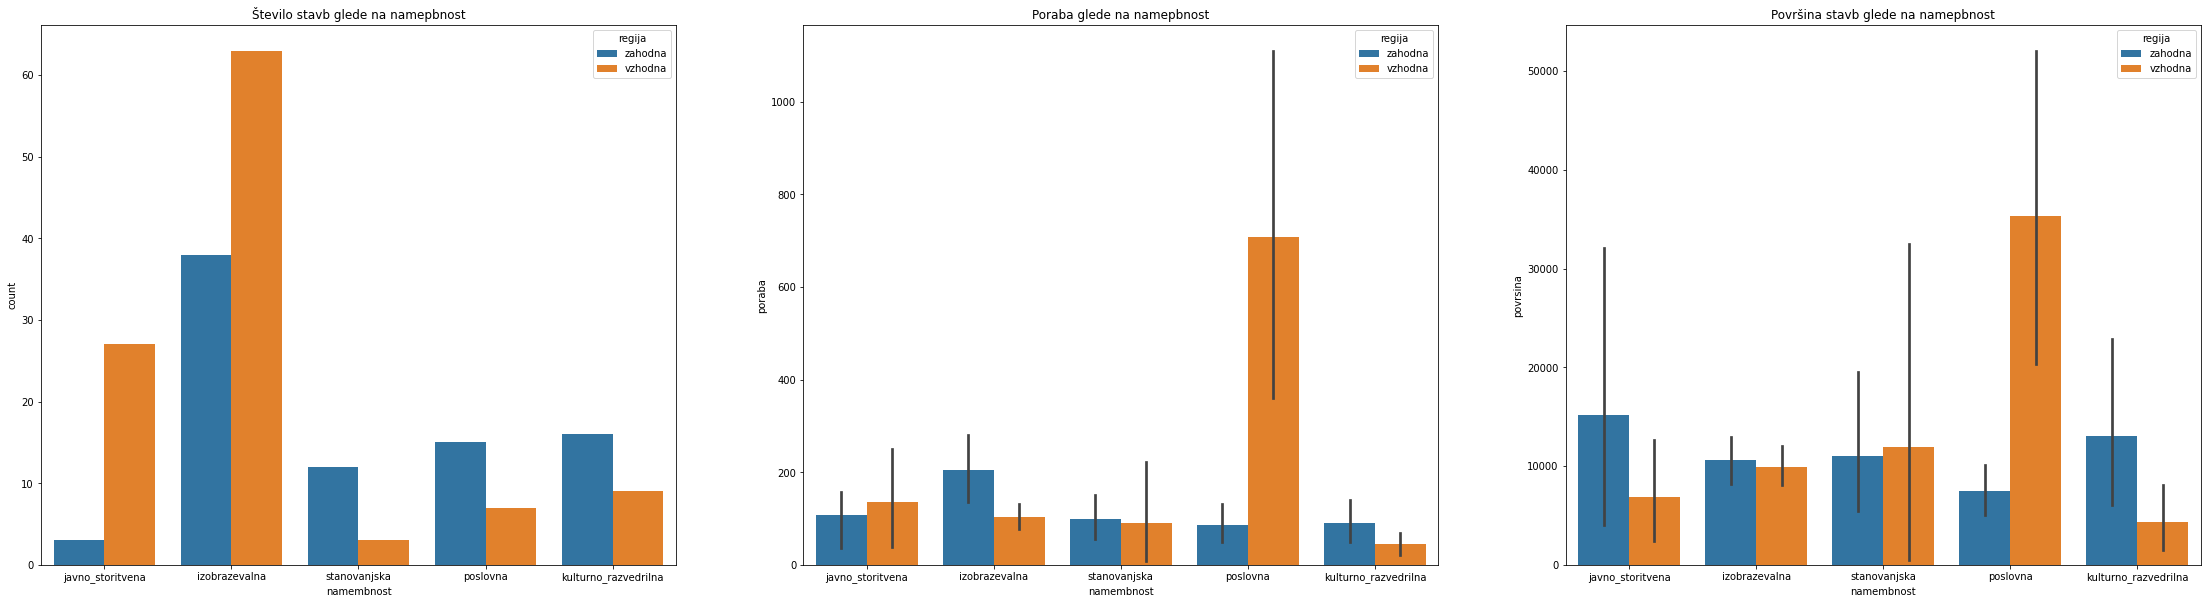

In [39]:
unique_data = unique_by_attr("stavba") 

f, ax = plt.subplots(1, 3)
plt.subplots_adjust(left=0, right=5, top=2)

sns.countplot(data=unique_data, x="namembnost", hue="regija", ax=ax[0]).set_title("Število stavb glede na namepbnost")
sns.barplot(data=unique_data, x="namembnost", y="poraba", hue="regija", ax=ax[1]).set_title("Poraba glede na namepbnost")
sns.barplot(data=unique_data, x="namembnost", y="povrsina", hue="regija", ax=ax[2]).set_title("Površina stavb glede na namepbnost")

In [41]:
print(f"Zahodna: {unique_data[unique_data['regija'] == 'zahodna']['povrsina'].mean()}")
print(f"Vzhod: {unique_data[unique_data['regija'] == 'vzhodna']['povrsina'].mean()}")

Zahodna: 10733.98275832143
Vzhod: 10382.544376899084


# Analiza atributov

## Apriorne verjetnosti razredov

In [123]:
classes = pd.unique(raw_data["norm_poraba"])
data = [len(raw_data[raw_data["norm_poraba"] == e].index) / len(raw_data.index) for e in classes]

class_prob = pd.DataFrame(
    {"norm_poraba": classes, "verjetnost razreda": data}
)
class_prob = class_prob.sort_values("verjetnost razreda", ascending=False)
class_prob

norm_poraba  verjetnost razreda
1     SREDNJA            0.369635
2       NIZKA            0.233745
3      VISOKA            0.186957
0  ZELOVISOKA            0.132553
4   ZELONIZKA            0.077109

## Ocena atributov z metriko Chi^2

In [127]:
prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])
y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
selector = SelectKBest(chi2).fit(X, y)

chi2_scores = pd.DataFrame(
    {"Atribut":X.columns, "ocena":selector.scores_}
)

chi2_scores = chi2_scores.sort_values("ocena", ascending=False)
chi2_scores.reset_index(drop=True)

Atribut         ocena
0              povrsina  9.138277e+07
1                stavba  6.955992e+04
2                   dan  2.865281e+04
3                   ura  1.930063e+04
4            smer_vetra  1.105394e+04
5            namembnost  5.704203e+03
6        leto_izgradnje  5.043999e+03
7                 teden  4.613801e+03
8                vikend  1.362082e+03
9          temp_rosisca  1.156765e+03
10           temp_zraka  8.698973e+02
11    temp_rosisca_MA_7  8.652343e+02
12                mesec  8.444787e+02
13   temp_rosisca_MA_14  8.203148e+02
14               regija  7.684409e+02
15   temp_rosisca_MA_21  6.726223e+02
16     temp_zraka_MA_14  6.151689e+02
17      temp_zraka_MA_7  6.038999e+02
18     temp_zraka_MA_21  5.831537e+02
19     temp_zraka_MA_28  5.439896e+02
20   temp_rosisca_MA_28  5.196205e+02
21  hitrost_vetra_MA_28  1.380060e+02
22  hitrost_vetra_MA_21  1.370714e+02
23   hitrost_vetra_MA_7  1.329736e+02
24  hitrost_vetra_MA_14  1.286485e+02
25      oblacnost_MA_28  1.143028e+02
26      oblacnost_MA_21  1.037772e+02
27       oblacnost_MA_7  9.526975e+01
28      oblacnost_MA_14  9.284265e+01
29             padavine  7.373481e+01
30       padavine_MA_14  7.273259e+01
31       padavine_MA_21  7.141134e+01
32        padavine_MA_7  7.096048e+01
33       padavine_MA_28  6.882838e+01
34            oblacnost  6.278009e+01
35        hitrost_vetra  3.285671e+01
36              pritisk  2.102491e+01
37        pritisk_MA_28  1.218917e+01
38        pritisk_MA_21  1.143751e+01
39        pritisk_MA_14  1.079086e+01
40         pritisk_MA_7  9.886802e+00

## Ocena atributov z metriko Relieff

In [128]:
prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])
y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])


relieff = get_relieff_scores(X, y)

relieff_scores = pd.DataFrame(
    {"Atribut":X.columns, "ocena":relieff}
)

relieff_scores = relieff_scores.sort_values("ocena", ascending=False)
relieff_scores.reset_index(drop=True)

Atribut      ocena
0              povrsina  15.486930
1            smer_vetra  10.200000
2                   ura   5.520000
3                   dan   5.510000
4        leto_izgradnje   4.370000
5            temp_zraka   3.844000
6                stavba   3.400000
7          temp_rosisca   3.257000
8               pritisk   2.684000
9     temp_rosisca_MA_7   1.712107
10            oblacnost   1.560000
11        hitrost_vetra   1.414000
12   temp_rosisca_MA_14   1.362399
13      temp_zraka_MA_7   1.294607
14     temp_zraka_MA_14   1.096705
15   temp_rosisca_MA_21   1.058123
16         pritisk_MA_7   0.973393
17     temp_zraka_MA_21   0.960891
18     temp_zraka_MA_28   0.901109
19   temp_rosisca_MA_28   0.876530
20                teden   0.770000
21        pritisk_MA_14   0.736118
22        pritisk_MA_21   0.559929
23        pritisk_MA_28   0.501043
24       oblacnost_MA_7   0.430000
25               vikend   0.370000
26   hitrost_vetra_MA_7   0.346679
27      oblacnost_MA_14   0.302258
28           namembnost   0.250000
29      oblacnost_MA_21   0.229774
30      oblacnost_MA_28   0.183398
31  hitrost_vetra_MA_14   0.172152
32             padavine   0.150000
33                mesec   0.140000
34  hitrost_vetra_MA_21   0.118676
35        padavine_MA_7   0.115000
36  hitrost_vetra_MA_28   0.103323
37       padavine_MA_14   0.089643
38       padavine_MA_21   0.060630
39       padavine_MA_28   0.057885
40               regija   0.020000

# Klasifikacija

## Odločitveno drevo

### Odločitveno drevo (atributi izbrani z metriko Relieff)

In [112]:
def best_tree_atributes_relieff():
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])
    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    relieff_scores = get_relieff_scores(X_train, y_train)
    
    res = dict()
    for i in range(5, len(X.columns)):
        cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -i)[-i:])
        X_train_n = X_train.drop(X_train.columns[list(cols)], axis=1)
        X_test_n = X_test.drop(X_test.columns[list(cols)], axis=1)
        r = (DecisionTree_best_max_depth(X_train_n, y_train, 10,  25))
        print(i, ":", r)
        res[i] = r
        
    pickle.dump(res, open("pickled_data/decision_tree/decision_tree_relieff.pickle", "wb"))

# best_tree_atributes_relieff()

Najboljša natančnost na validacijski množici: 0.8332354206446769 (# atributov: 29)
Natančnost na testni množici: 0.832726159004449
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'oblacnost', 'padavine', 'pritisk', 'smer_vetra', 'hitrost_vetra', 'teden', 'dan', 'vikend', 'temp_zraka_MA_7', 'temp_zraka_MA_14', 'temp_zraka_MA_21', 'temp_zraka_MA_28', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'temp_rosisca_MA_21', 'temp_rosisca_MA_28', 'oblacnost_MA_7', 'oblacnost_MA_14', 'pritisk_MA_7', 'pritisk_MA_14', 'pritisk_MA_21', 'pritisk_MA_28', 'hitrost_vetra_MA_7']


[Text(0.5, 15.0, '# atributov'),
 Text(-33.25, 0.5, 'Natančnost na validacijski množici')]

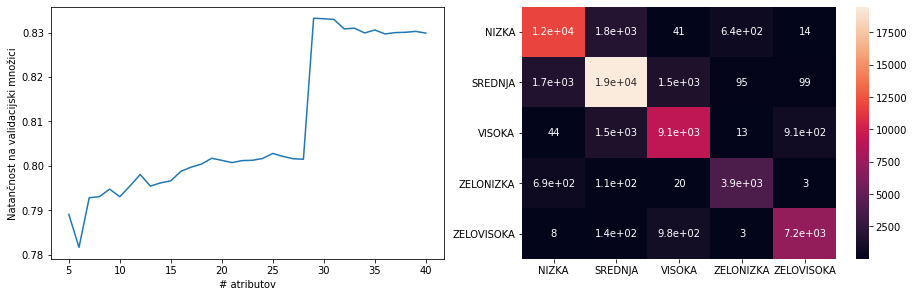

In [119]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/decision_tree/decision_tree_relieff.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/decision_tree/decision_tree_relieff.pickle")

print(f"Najboljša natančnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

relieff_scores = get_relieff_scores(X_train, y_train)

cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -n_features)[-n_features:])
X_train = X_train.drop(X_train.columns[list(cols)], axis=1)
X_test = X_test.drop(X_test.columns[list(cols)], axis=1)

clf = DecisionTreeClassifier(max_depth=ops["max_depth"], random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True, ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### Odločitveno drevo (atributi izbrani z metriko Chi^2)

In [115]:
def best_tree_atributes_chi2():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])

    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X = transform_negative_data(X)
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)


    for i in range(5, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
        r = (DecisionTree_best_max_depth(X_train, y_train, 10,  25))
        print(i, ":", r)
        res[i] = r

    pickle.dump(res, open("pickled_data/decision_tree/decision_tree_chi2.pickle", "wb"))

# best_tree_atributes_chi2()

Najboljša natancnost na validacijski množici: 0.8425619572037097 (# atributov: 9)
Natancnost na testni množici: 0.845766974015088
Izbrani atributi:
['ura', 'stavba', 'namembnost', 'povrsina', 'leto_izgradnje', 'smer_vetra', 'teden', 'dan', 'vikend']


[Text(0.5, 15.0, '# atributov'),
 Text(-39.5, 0.5, 'Natancnost na validacijski množici')]

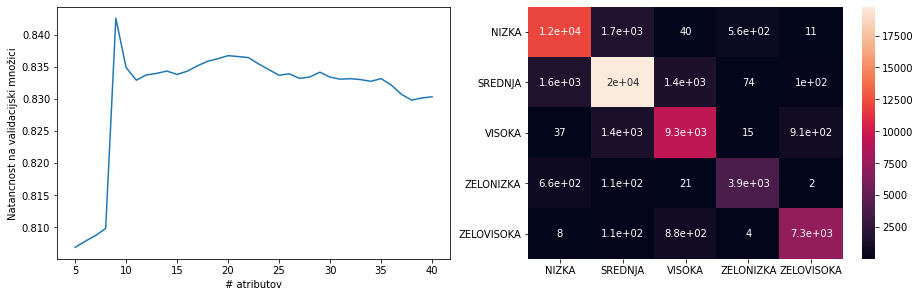

In [120]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/decision_tree/decision_tree_chi2.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/decision_tree/decision_tree_chi2.pickle")

print(f"Najboljša Natančnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

clf = DecisionTreeClassifier(max_depth=ops["max_depth"], random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True,  ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### Ovrednotenje modela na mesečnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, natančnost: 0.7908848417954378
Število mesecev v učni množici: 2, natančnost: 0.7946196762967463
Število mesecev v učni množici: 3, natančnost: 0.7801206861482134
Število mesecev v učni množici: 4, natančnost: 0.7186514886164623
Število mesecev v učni množici: 5, natančnost: 0.73090105872496
Število mesecev v učni množici: 6, natančnost: 0.7545653761869978
Število mesecev v učni množici: 7, natančnost: 0.7331579622738355
Število mesecev v učni množici: 8, natančnost: 0.7522525620744205
Število mesecev v učni množici: 9, natančnost: 0.69361163057248
Število mesecev v učni množici: 10, natančnost: 0.7352760009476428
Število mesecev v učni množici: 11, natančnost: 0.7127494800194716
Povprečna natančnost: 0.7451627966960608


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='Natančnost'>

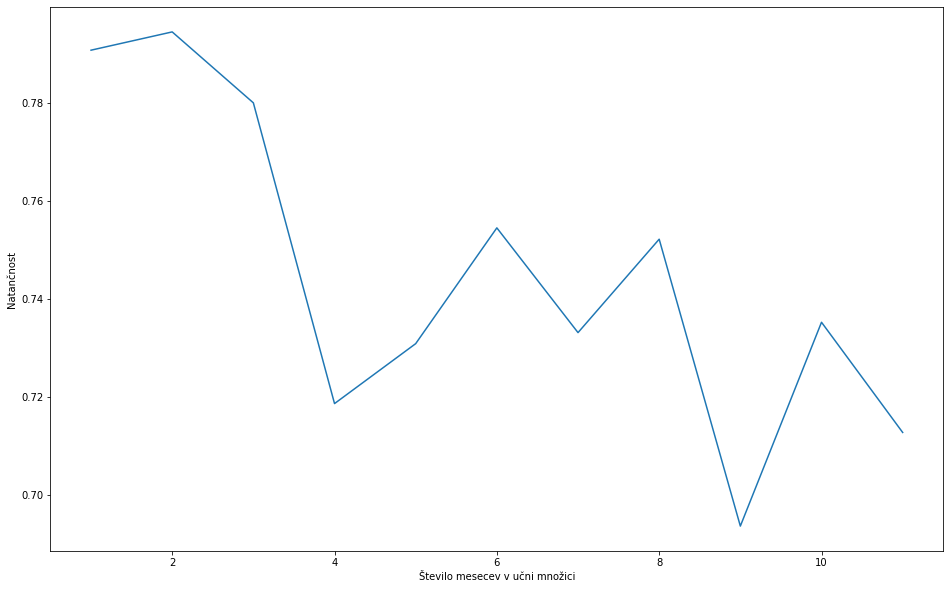

In [73]:
n_features, ops, acc = get_best_from_pickle("pickled_data/decision_tree/decision_tree_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data["padavine"] = prep_data["padavine"].apply(lambda x: x + 1)
prep_data["temp_zraka"] = prep_data["temp_zraka"].apply(lambda x: x + 100)
prep_data["temp_rosisca"] = prep_data["temp_rosisca"].apply(lambda x: x + 100)
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

clf = DecisionTreeClassifier(max_depth=ops["max_depth"], random_state=0)
res = validate_by_months(clf, n_features, prep_data)


print(f"Povprečna natančnost: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='Natančnost')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naučenih na podatkih posameznih regij

Natančnost na testni množici (učni podatki: celotni, testni podatki: celotni): 0.845766974015088
Natančnost na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.9281718744432964
Natančnost na testni množici (učni podatki: celotni, testni podatki: zahod): 0.9405928935205629
Natančnost na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.5511154813334193
Natančnost na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.8178643959097873
Natančnost na testni množici (učni podatki: vzhod, testni podatki: zahod): 0.22756042273837912
Natančnost na testni množici (učni podatki: zahod, testni podatki: celotni): 0.6162389580243729
Natančnost na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.2261018277692664
Natančnost na testni množici (učni podatki: zahod, testni podatki: zahod): 0.8664370455415231


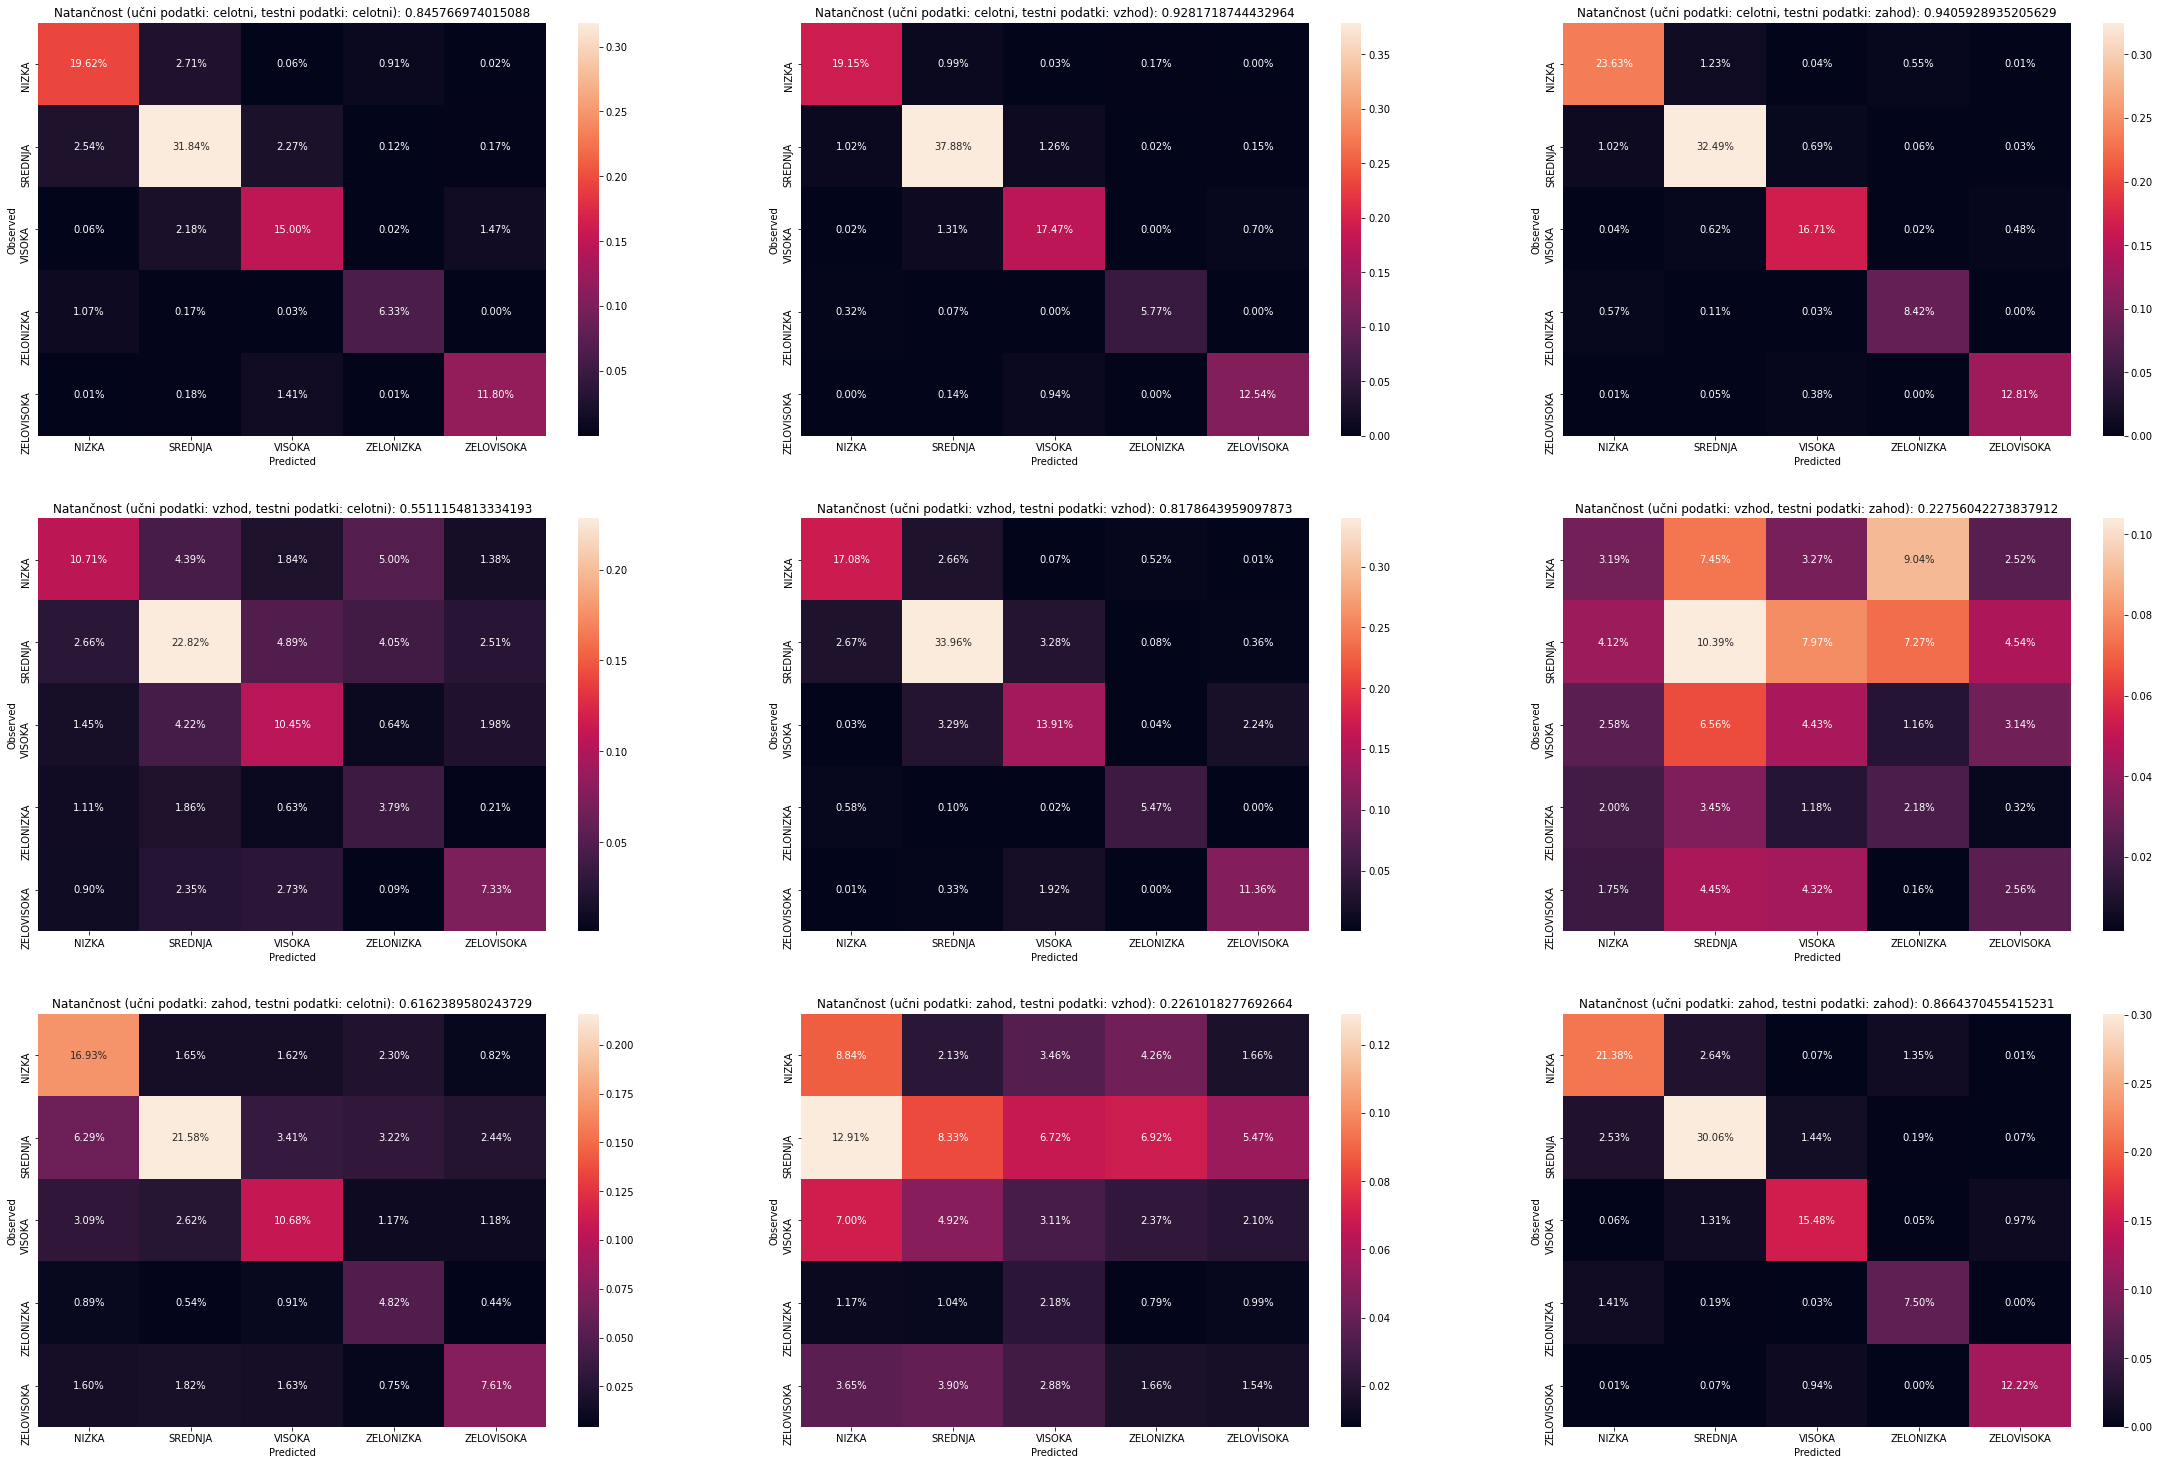

In [15]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, acc = get_best_from_pickle("pickled_data/decision_tree/decision_tree_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data_vzhod = prep_data[prep_data["regija"] == 0]
prep_data_zahod = prep_data[prep_data["regija"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "norm_poraba")
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "norm_poraba")
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "norm_poraba")

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}


for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = DecisionTreeClassifier(max_depth=ops["max_depth"], random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cf_mat = confusion_matrix(y_test, y_pred)
        print(f"Natančnost na testni množici (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")
        sns.heatmap(cf_mat/np.sum(cf_mat), fmt='.2%', annot=True,  ax=ax[i, j], xticklabels=le.classes_, yticklabels=le.classes_)
        ax[i, j].set(xlabel='Predicted', ylabel='Observed')
        ax[i, j].set_title(f"Natančnost (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")

## Naključni gozdovi

### Naključni gozdovi (atributi izbrani z metriko relieff)

In [8]:
def best_RandomForest_atributes_relieff():
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])
    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    relieff_scores = get_relieff_scores(X_train, y_train)

    res = dict()
    for i in range(5, len(X.columns)):
        cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -i)[-i:])
        X_train_n = X_train.drop(X_train.columns[list(cols)], axis=1)
        clf = RandomForestClassifier(n_jobs=-1, random_state=0)
        acc = cross_val_score(clf, X_train_n, y_train, cv=10, scoring='accuracy', n_jobs=-1)
        r = acc.mean()
        print(i, ":", r)
        res[i] = (r, {})

    pickle.dump(res, open("pickled_data/random_forest/random_forest_relieff.pickle", "wb"))

# best_RandomForest_atributes_relieff()

Najboljša natančnost na validacijski množici: 0.8424306610889205 (# atributov: 16)
Natančnost na testni množici: 0.8456541363079503
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'oblacnost', 'pritisk', 'smer_vetra', 'hitrost_vetra', 'teden', 'dan', 'temp_zraka_MA_7', 'temp_zraka_MA_14', 'temp_rosisca_MA_7', 'pritisk_MA_7']


[Text(0.5, 15.0, '# atributov'),
 Text(-33.25, 0.5, 'Natančnost na validacijski množici')]

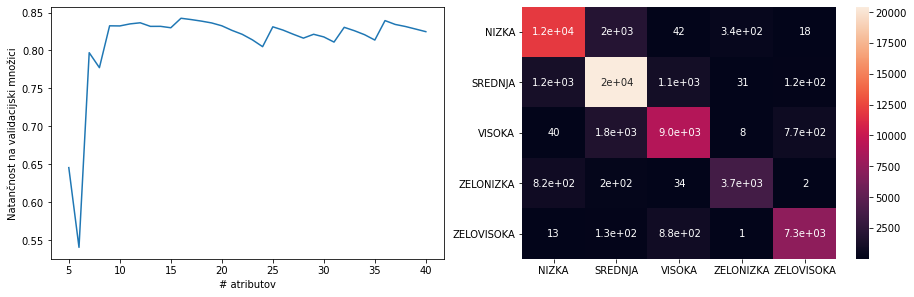

In [130]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/random_forest/random_forest_relieff.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/random_forest/random_forest_relieff.pickle")

print(f"Najboljša natančnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

relieff_scores = get_relieff_scores(X_train, y_train)

cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -n_features)[-n_features:])
X_train = X_train.drop(X_train.columns[list(cols)], axis=1)
X_test = X_test.drop(X_test.columns[list(cols)], axis=1)

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True, ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### Naključni gozdovi (atributi izbrani z metriko Chi^2)

In [10]:
def best_RandomForest_atributes_chi2():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])

    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X = transform_negative_data(X)
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    res = dict()
    for i in range(5, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        selector = SelectKBest(chi2, k=i)
        selector.fit(X_train, y_train)
        X_train = X_train.loc[:, selector.get_support()]
        clf = RandomForestClassifier(n_jobs=-1, random_state=0)
        acc = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
        r = acc.mean()
        print(i, ":", r)
        res[i] = (r, {})

    pickle.dump(res, open("pickled_data/random_forest/random_forest_chi2.pickle", "wb"))
        
# best_RandomForest_atributes_chi2()

Najboljša natančnost na validacijski množici: 0.8719161958683346 (# atributov: 16)
Natančnost na testni množici: 0.8747179057321556
Izbrani atributi:
['ura', 'regija', 'stavba', 'namembnost', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'smer_vetra', 'mesec', 'teden', 'dan', 'vikend', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'temp_rosisca_MA_21']


[Text(0.5, 15.0, '# atributov'),
 Text(-33.125, 0.5, 'Natančnost na validacijski množici')]

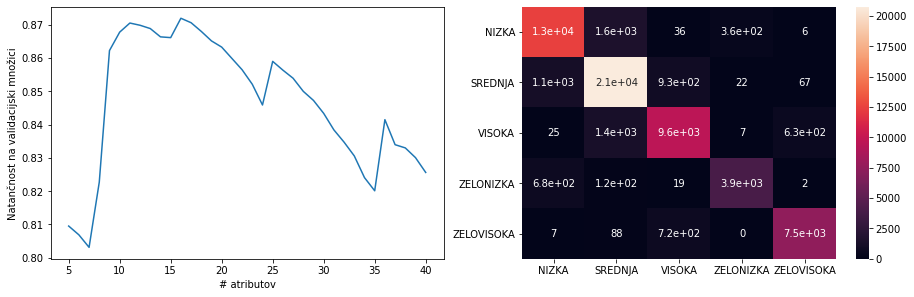

In [131]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/random_forest/random_forest_chi2.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/random_forest/random_forest_chi2.pickle")
        
print(f"Najboljša natančnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selector = SelectKBest(chi2, k=n_features)

selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True,  ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### Ovrednotenje modela na mesečnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, natančnost: 0.8001747608535688
Število mesecev v učni množici: 2, natančnost: 0.8211898580345799
Število mesecev v učni množici: 3, natančnost: 0.8055461387212692
Število mesecev v učni množici: 4, natančnost: 0.7486865148861647
Število mesecev v učni množici: 5, natančnost: 0.7353949272602636
Število mesecev v učni množici: 6, natančnost: 0.7872899926953981
Število mesecev v učni množici: 7, natančnost: 0.7511228025150777
Število mesecev v učni množici: 8, natančnost: 0.7992296581608088
Število mesecev v učni množici: 9, natančnost: 0.7398805573988055
Število mesecev v učni množici: 10, natančnost: 0.7873963515754561
Število mesecev v učni množici: 11, natančnost: 0.7718281187768288
Povprečna natančnost: 0.777067243716202


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='Natančnost'>

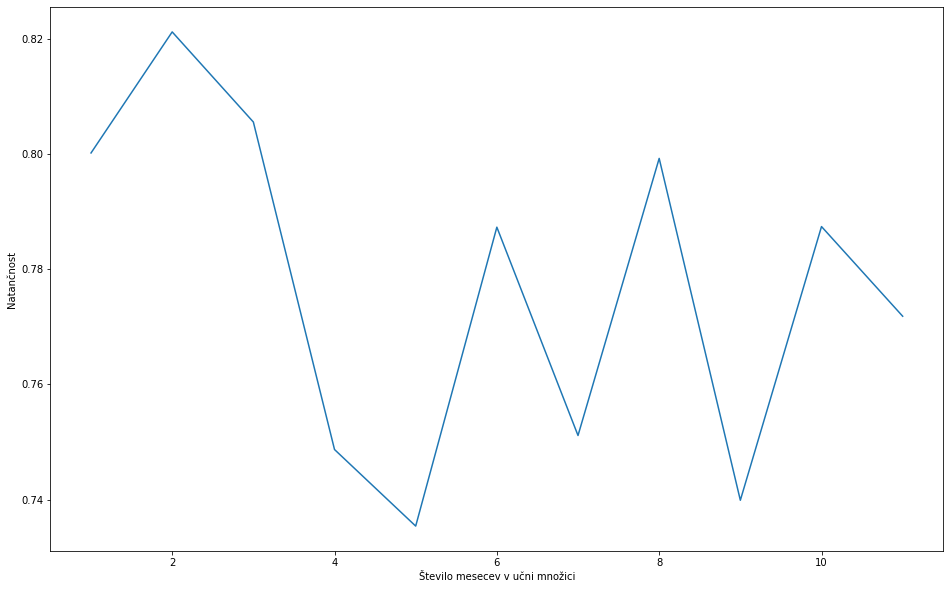

In [74]:
n_features, ops, acc = get_best_from_pickle("pickled_data/random_forest/random_forest_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data["padavine"] = prep_data["padavine"].apply(lambda x: x + 1)
prep_data["temp_zraka"] = prep_data["temp_zraka"].apply(lambda x: x + 100)
prep_data["temp_rosisca"] = prep_data["temp_rosisca"].apply(lambda x: x + 100)
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
res = validate_by_months(clf, n_features, prep_data)


print(f"Povprečna natančnost: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='Natančnost')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naucenih na podatkih posameznih regij

Natančnost na testni množici (učni podatki: celotni, testni podatki: celotni): 0.8741375975240183
Natančnost na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.9587059536110022
Natančnost na testni množici (učni podatki: celotni, testni podatki: zahod): 0.956489740645883
Natančnost na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.5998452511444967
Natančnost na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.8562012327644565
Natančnost na testni množici (učni podatki: vzhod, testni podatki: zahod): 0.3026877447084106
Natančnost na testni množici (učni podatki: zahod, testni podatki: celotni): 0.6566993358694951
Natančnost na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.3047707271885132
Natančnost na testni množici (učni podatki: zahod, testni podatki: zahod): 0.8912537902204951


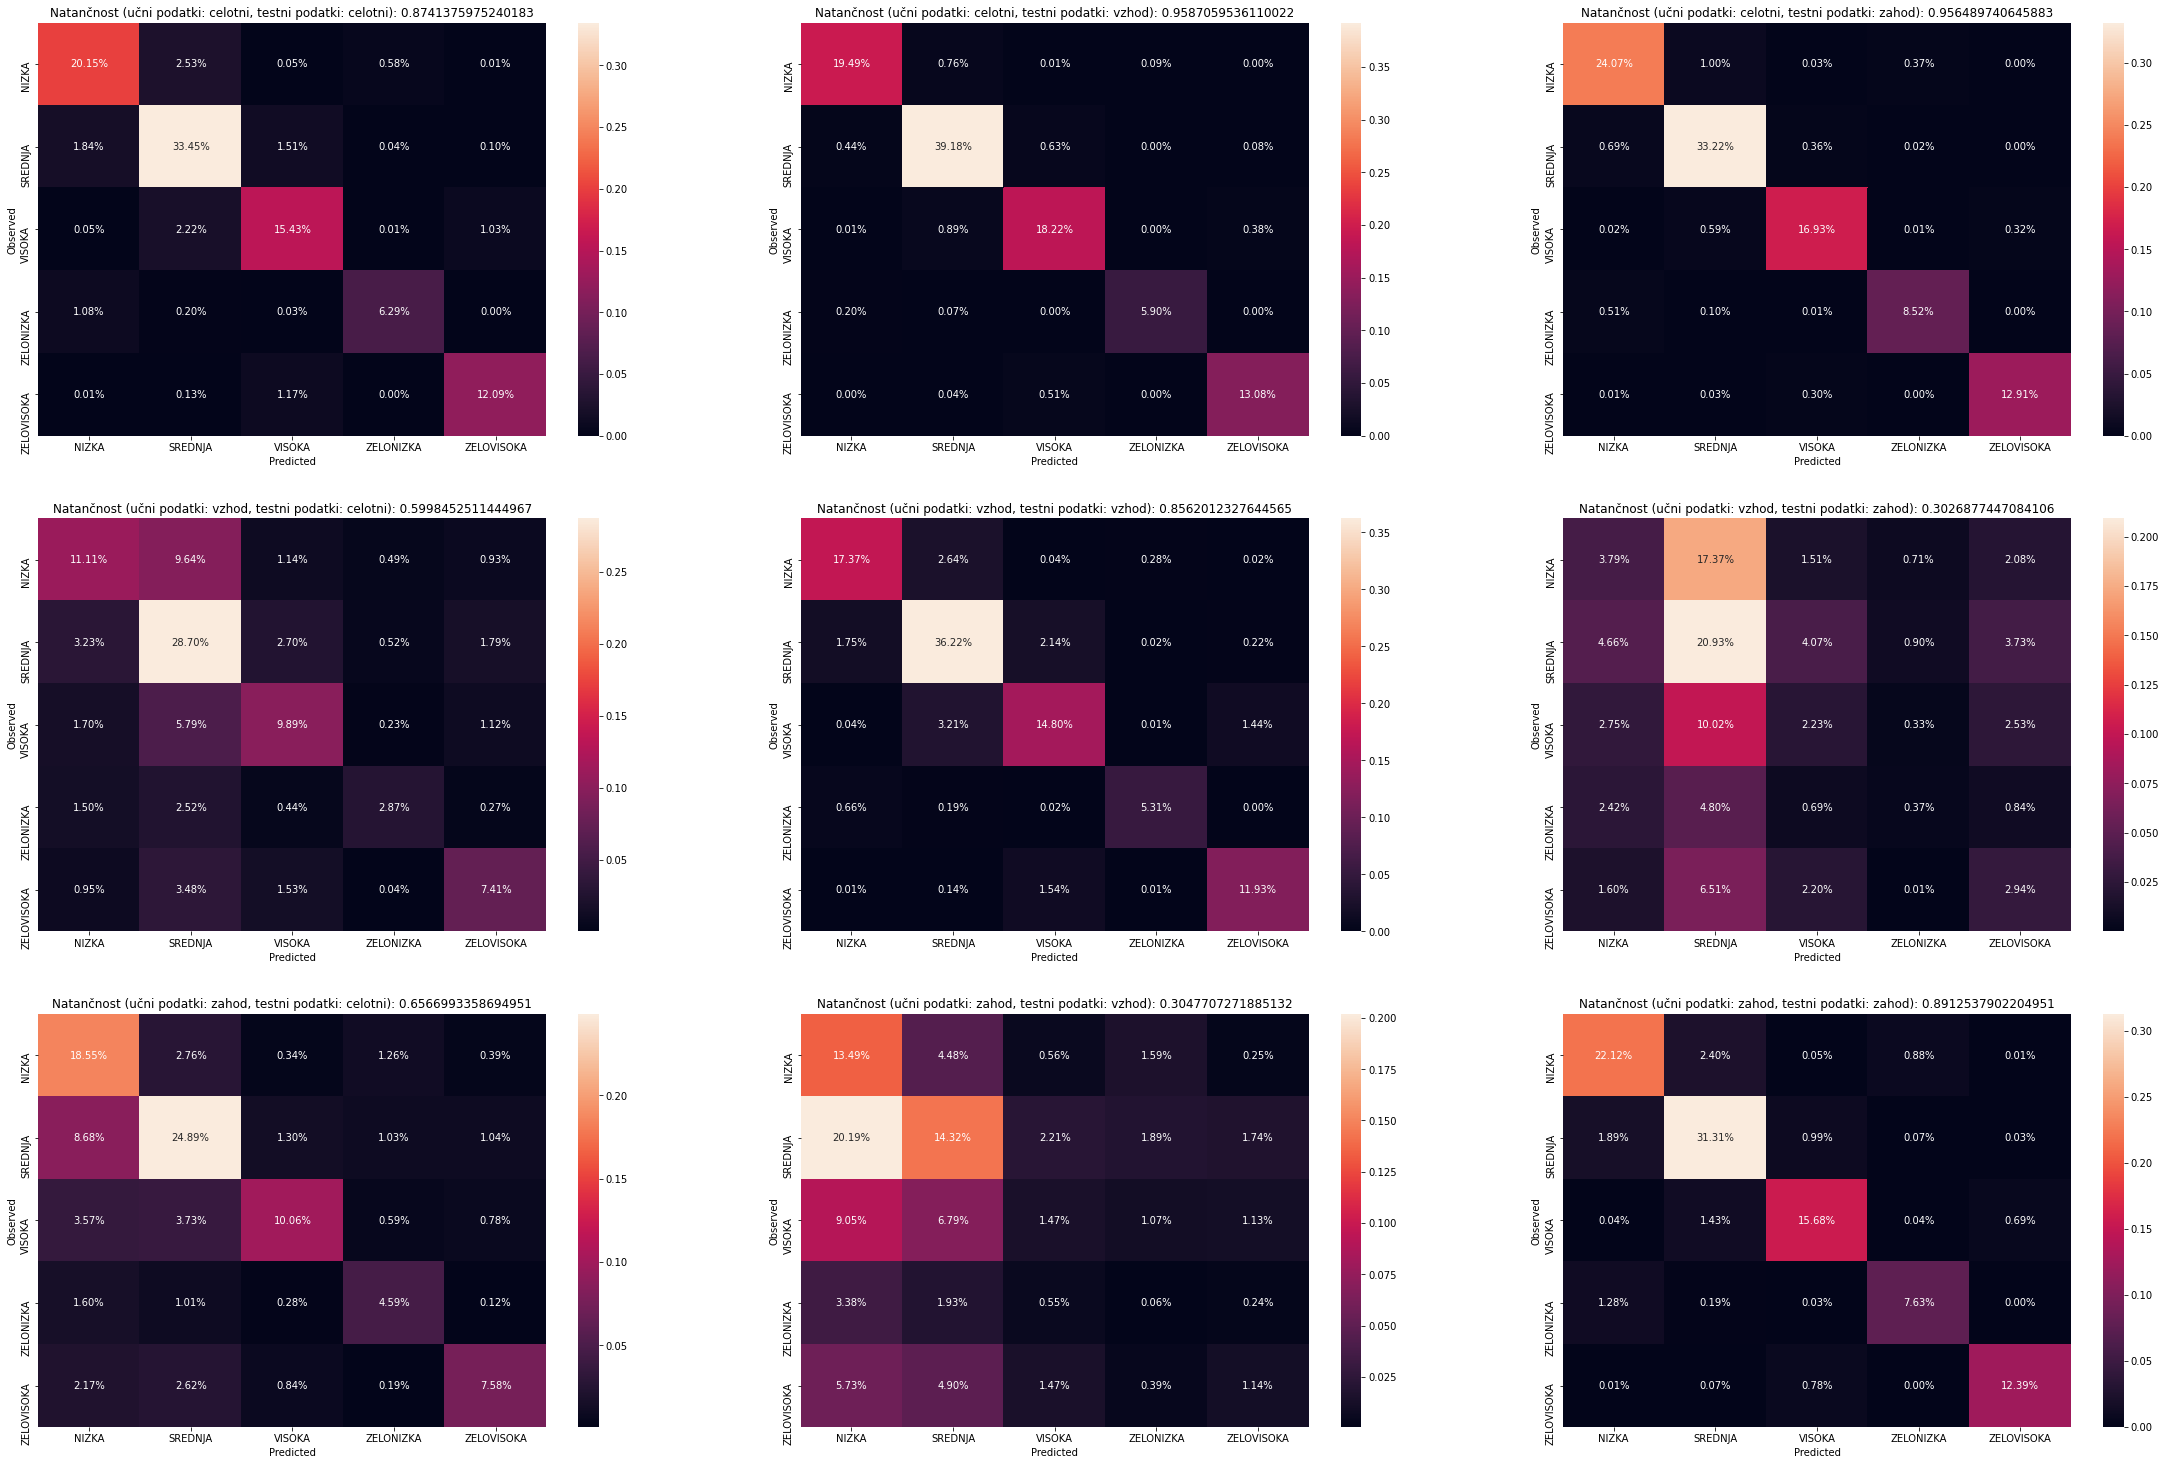

In [13]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, acc = get_best_from_pickle("pickled_data/random_forest/random_forest_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data_vzhod = prep_data[prep_data["regija"] == 0]
prep_data_zahod = prep_data[prep_data["regija"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "norm_poraba")
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "norm_poraba")
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "norm_poraba")

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}


for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = RandomForestClassifier(n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cf_mat = confusion_matrix(y_test, y_pred)
        print(f"Natančnost na testni množici (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")
        sns.heatmap(cf_mat/np.sum(cf_mat), fmt='.2%', annot=True,  ax=ax[i, j], xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        ax[i, j].set(xlabel='Predicted', ylabel='Observed')
        ax[i, j].set_title(f"Natančnost (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")

## KNN

### KNN (atributi izbrani z metriko Relieff)

In [ ]:
def best_KNN_atributes_releiff():
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])
    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    relieff_scores = get_relieff_scores(X_train, y_train)
    
    res = dict()
    for i in range(5, len(X.columns)):
        cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -i)[-i:])
        X_train_n = X_train.drop(X_train.columns[list(cols)], axis=1)
        r = (KNN_best_n_neighbours(X_train_n, y_train, 2,  15))
        print(i, ":", r)
        res[i] = r
    pickle.dump((res, le), open("pickled_data/knn/knn_relieff.pickle", "wb"))

# best_KNN_atributes_releiff()

Najboljša natačnost na validacijski množici: 0.7339394256582525 (# atributov: 15)
Natančnost na testni množici: 0.7342510800180541
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'oblacnost', 'pritisk', 'smer_vetra', 'hitrost_vetra', 'teden', 'dan', 'temp_zraka_MA_7', 'temp_rosisca_MA_7', 'pritisk_MA_7']


[Text(0.5, 15.0, '# atributov'),
 Text(-39.625, 0.5, 'Natančnost na validacijski množici')]

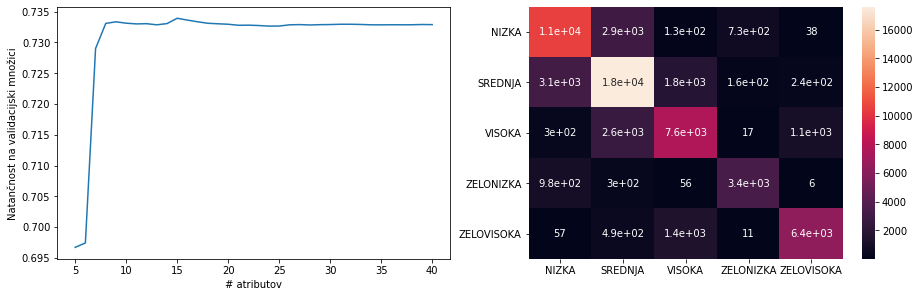

In [14]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/knn/knn_relieff.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/knn/knn_relieff.pickle")

print(f"Najboljša natačnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

relieff_scores = get_relieff_scores(X_train, y_train)

cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -n_features)[-n_features:])
X_train = X_train.drop(X_train.columns[list(cols)], axis=1)
X_test = X_test.drop(X_test.columns[list(cols)], axis=1)

clf = KNeighborsClassifier(n_neighbors=ops["n_neighbors"], n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True,  ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### KNN (atributi izbrani z metriko Chi^2)

In [ ]:
def best_KNN_atributes_chi2():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])

    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X = transform_negative_data(X)
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    res = dict()
    for i in range(2, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
        r = (KNN_best_n_neighbours(X_train, y_train, 2,  15))
        print(i, ":", r)
        res[i] = r
    pickle.dump(res, open("pickled_data/knn/knn_chi2.pickle", "wb"))

# best_KNN_atributes_chi2()

Najboljša natačnost na validacijski množici: 0.8024442073846666 (# atributov: 4)
Natančnost na testni množici: 0.8013733960925914
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'dan']


[Text(0.5, 15.0, '# atributov'),
 Text(-39.625, 0.5, 'Natančnost na validacijski množici')]

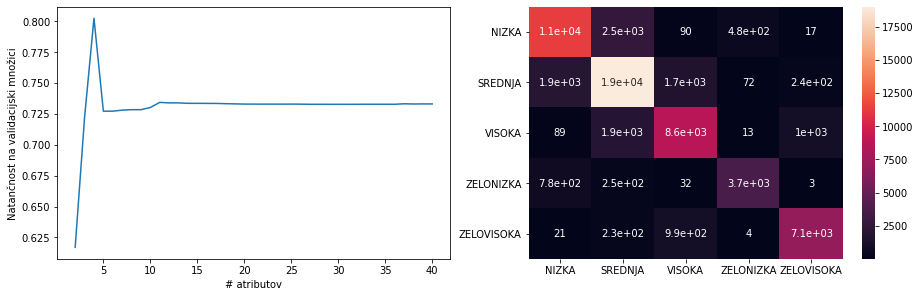

In [15]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/knn/knn_chi2.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/knn/knn_chi2.pickle")

print(f"Najboljša natačnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

clf = KNeighborsClassifier(n_neighbors=ops["n_neighbors"], n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True,  ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### Ovrednotenje modela na mesečnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, natančnost: 0.7350073583517293
Število mesecev v učni množici: 2, natančnost: 0.7372811136275755
Število mesecev v učni množici: 3, natančnost: 0.741948606685199
Število mesecev v učni množici: 4, natančnost: 0.6880910683012259
Število mesecev v učni množici: 5, natančnost: 0.6791834869373143
Število mesecev v učni množici: 6, natančnost: 0.7046018991964937
Število mesecev v učni množici: 7, natančnost: 0.6766328756576415
Število mesecev v učni množici: 8, natančnost: 0.7035559529541234
Število mesecev v učni množici: 9, natančnost: 0.6524702901610665
Število mesecev v učni množici: 10, natančnost: 0.7192134565268894
Število mesecev v učni množici: 11, natančnost: 0.6905783953622162
Povprečna natančnost: 0.702596773069225


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='Natančnost'>

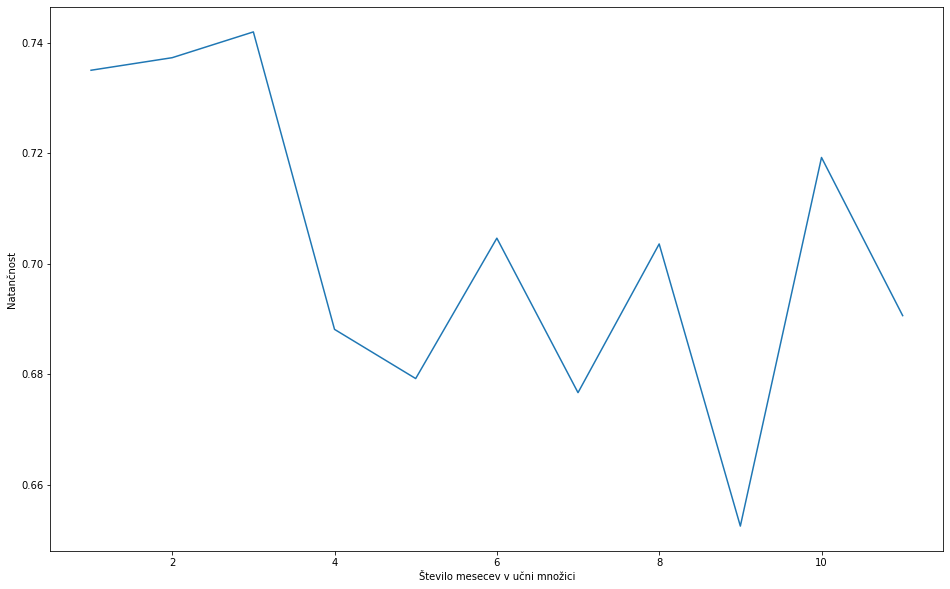

In [75]:
n_features, ops, acc = get_best_from_pickle("pickled_data/knn/knn_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data["padavine"] = prep_data["padavine"].apply(lambda x: x + 1)
prep_data["temp_zraka"] = prep_data["temp_zraka"].apply(lambda x: x + 100)
prep_data["temp_rosisca"] = prep_data["temp_rosisca"].apply(lambda x: x + 100)
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)


clf = clf = KNeighborsClassifier(n_neighbors=ops["n_neighbors"], n_jobs=-1)
res = validate_by_months(clf, n_features, prep_data)


print(f"Povprečna natančnost: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='Natančnost')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naučenih na podatkih posameznih regij

Natančnost na testni množici (učni podatki: celotni, testni podatki: celotni): 0.8013733960925914
Natančnost na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.8022232515053266
Natančnost na testni množici (učni podatki: celotni, testni podatki: zahod): 0.8571050075068445
Natančnost na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.5087207427945064
Natančnost na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.768696333772758
Natančnost na testni množici (učni podatki: vzhod, testni podatki: zahod): 0.2665076981954135
Natančnost na testni množici (učni podatki: zahod, testni podatki: celotni): 0.5768908375781804
Natančnost na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.24958135889122457
Natančnost na testni množici (učni podatki: zahod, testni podatki: zahod): 0.8382937384085489


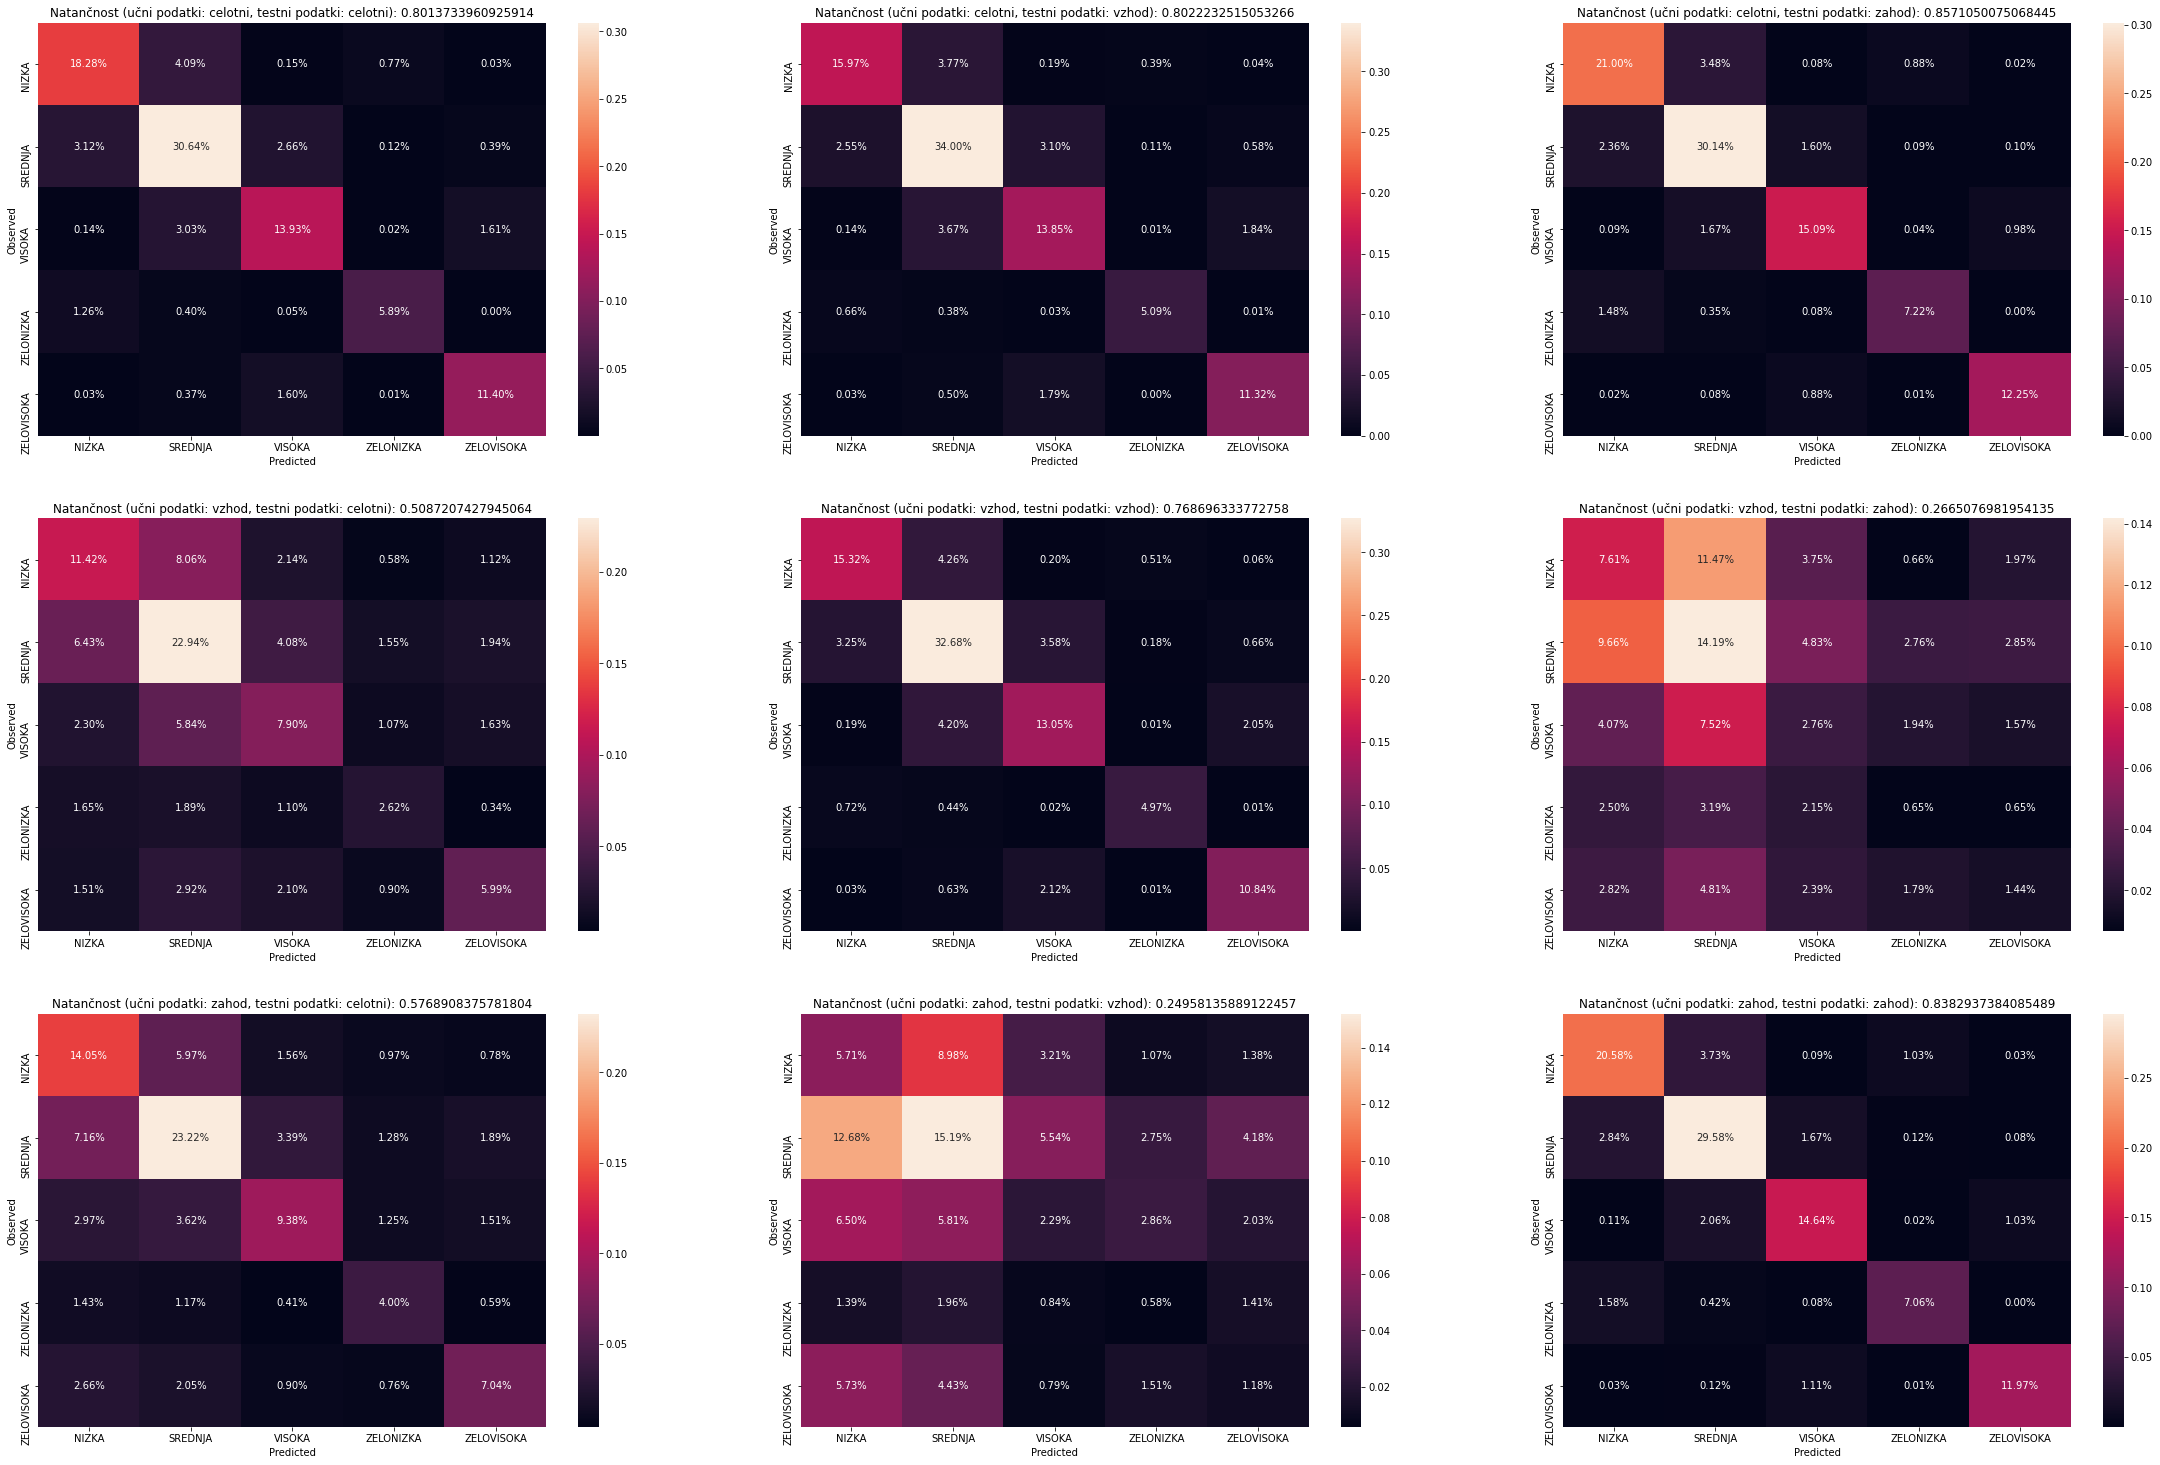

In [17]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, acc = get_best_from_pickle("pickled_data/knn/knn_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data_vzhod = prep_data[prep_data["regija"] == 0]
prep_data_zahod = prep_data[prep_data["regija"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "norm_poraba")
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "norm_poraba")
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "norm_poraba")

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}


for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = KNeighborsClassifier(n_neighbors=ops["n_neighbors"], n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cf_mat = confusion_matrix(y_test, y_pred)
        print(f"Natančnost na testni množici (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")
        sns.heatmap(cf_mat/np.sum(cf_mat), fmt='.2%', annot=True,  ax=ax[i, j], xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        ax[i, j].set(xlabel='Predicted', ylabel='Observed')
        ax[i, j].set_title(f"Natančnost (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")

## Bagging

### Bagging (atributi izbrani z metriko Chi^2)

In [ ]:
def best_Bagging_atributes_chi2():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])

    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X = transform_negative_data(X)
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    for i in range(2, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
        r = (BaggingClassifier_best_n(X_train, y_train))
        print(i, ":", r)
        res[i] = r

    pickle.dump(res, open("pickled_data/bagging/bagging_chi2.pickle", "wb"))

# best_Bagging_atributes_chi2()

Najboljša natančnost na validacijski množici: 0.7980089193343648 (# atributov: 11)
Natančnost na testni množici: 0.7989715648978013
Izbrani atributi:
['ura', 'stavba', 'namembnost', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'smer_vetra', 'teden', 'dan', 'vikend']


[Text(0.5, 15.0, '# atributov'),
 Text(-33.25, 0.5, 'Natančnost na validacijski množici')]

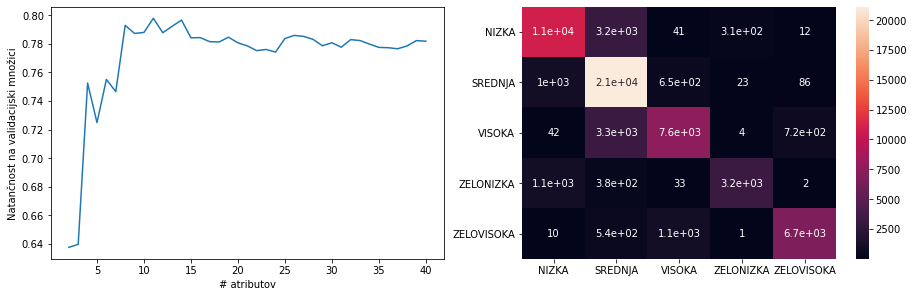

In [18]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/bagging/bagging_chi2.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/bagging/bagging_chi2.pickle")

print(f"Najboljša natančnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

clf = BaggingClassifier(KNeighborsClassifier(n_jobs=-1),
        max_samples=0.5, max_features=0.5, n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True,  ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### Ovrednotenje modela na mesečnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, natančnost: 0.7523454746136865
Število mesecev v učni množici: 2, natančnost: 0.753687234160084
Število mesecev v učni množici: 3, natančnost: 0.7584242999525391
Število mesecev v učni množici: 4, natančnost: 0.7016637478108582
Število mesecev v učni množici: 5, natančnost: 0.6868002132683373
Število mesecev v učni množici: 6, natančnost: 0.7372534696859021
Število mesecev v učni množici: 7, natančnost: 0.7103811112536892
Število mesecev v učni množici: 8, natančnost: 0.7497076827842355
Število mesecev v učni množici: 9, natančnost: 0.7000060324546058
Število mesecev v učni množici: 10, natančnost: 0.7185974887467425
Število mesecev v učni množici: 11, natančnost: 0.7169978315705625
Povprečna natačnost: 0.7259876896637493


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='Natančnost'>

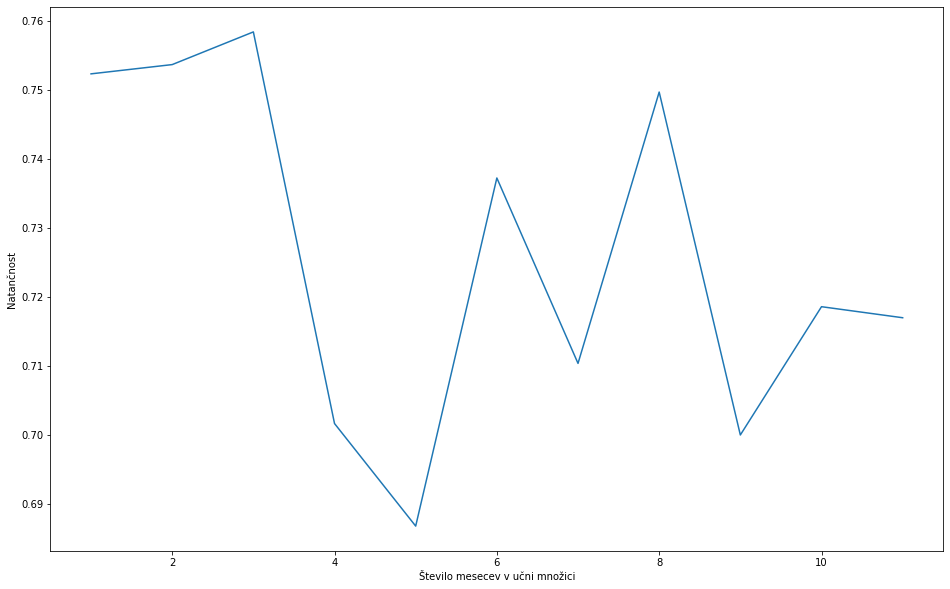

In [76]:
n_features, ops, acc = get_best_from_pickle("pickled_data/bagging/bagging_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data["padavine"] = prep_data["padavine"].apply(lambda x: x + 1)
prep_data["temp_zraka"] = prep_data["temp_zraka"].apply(lambda x: x + 100)
prep_data["temp_rosisca"] = prep_data["temp_rosisca"].apply(lambda x: x + 100)
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)


clf = BaggingClassifier(KNeighborsClassifier(),
        max_samples=0.5, max_features=0.5, n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)
res = validate_by_months(clf, n_features, prep_data)


print(f"Povprečna natačnost: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='Natančnost')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naucenih na podatkih posameznih regiji

Natančnost na testni množici (učni podatki: celotni, testni podatki: celotni): 0.7989715648978013
Natančnost na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.8335411693447822
Natančnost na testni množici (učni podatki: celotni, testni podatki: zahod): 0.8694397833318614
Natančnost na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.5488587271906635
Natančnost na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.769551430505576
Natančnost na testni množici (učni podatki: vzhod, testni podatki: zahod): 0.30801613235597164
Natančnost na testni množici (učni podatki: zahod, testni podatki: celotni): 0.5851441098716874
Natančnost na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.2520753910286101
Natančnost na testni množici (učni podatki: zahod, testni podatki: zahod): 0.8287261915275692


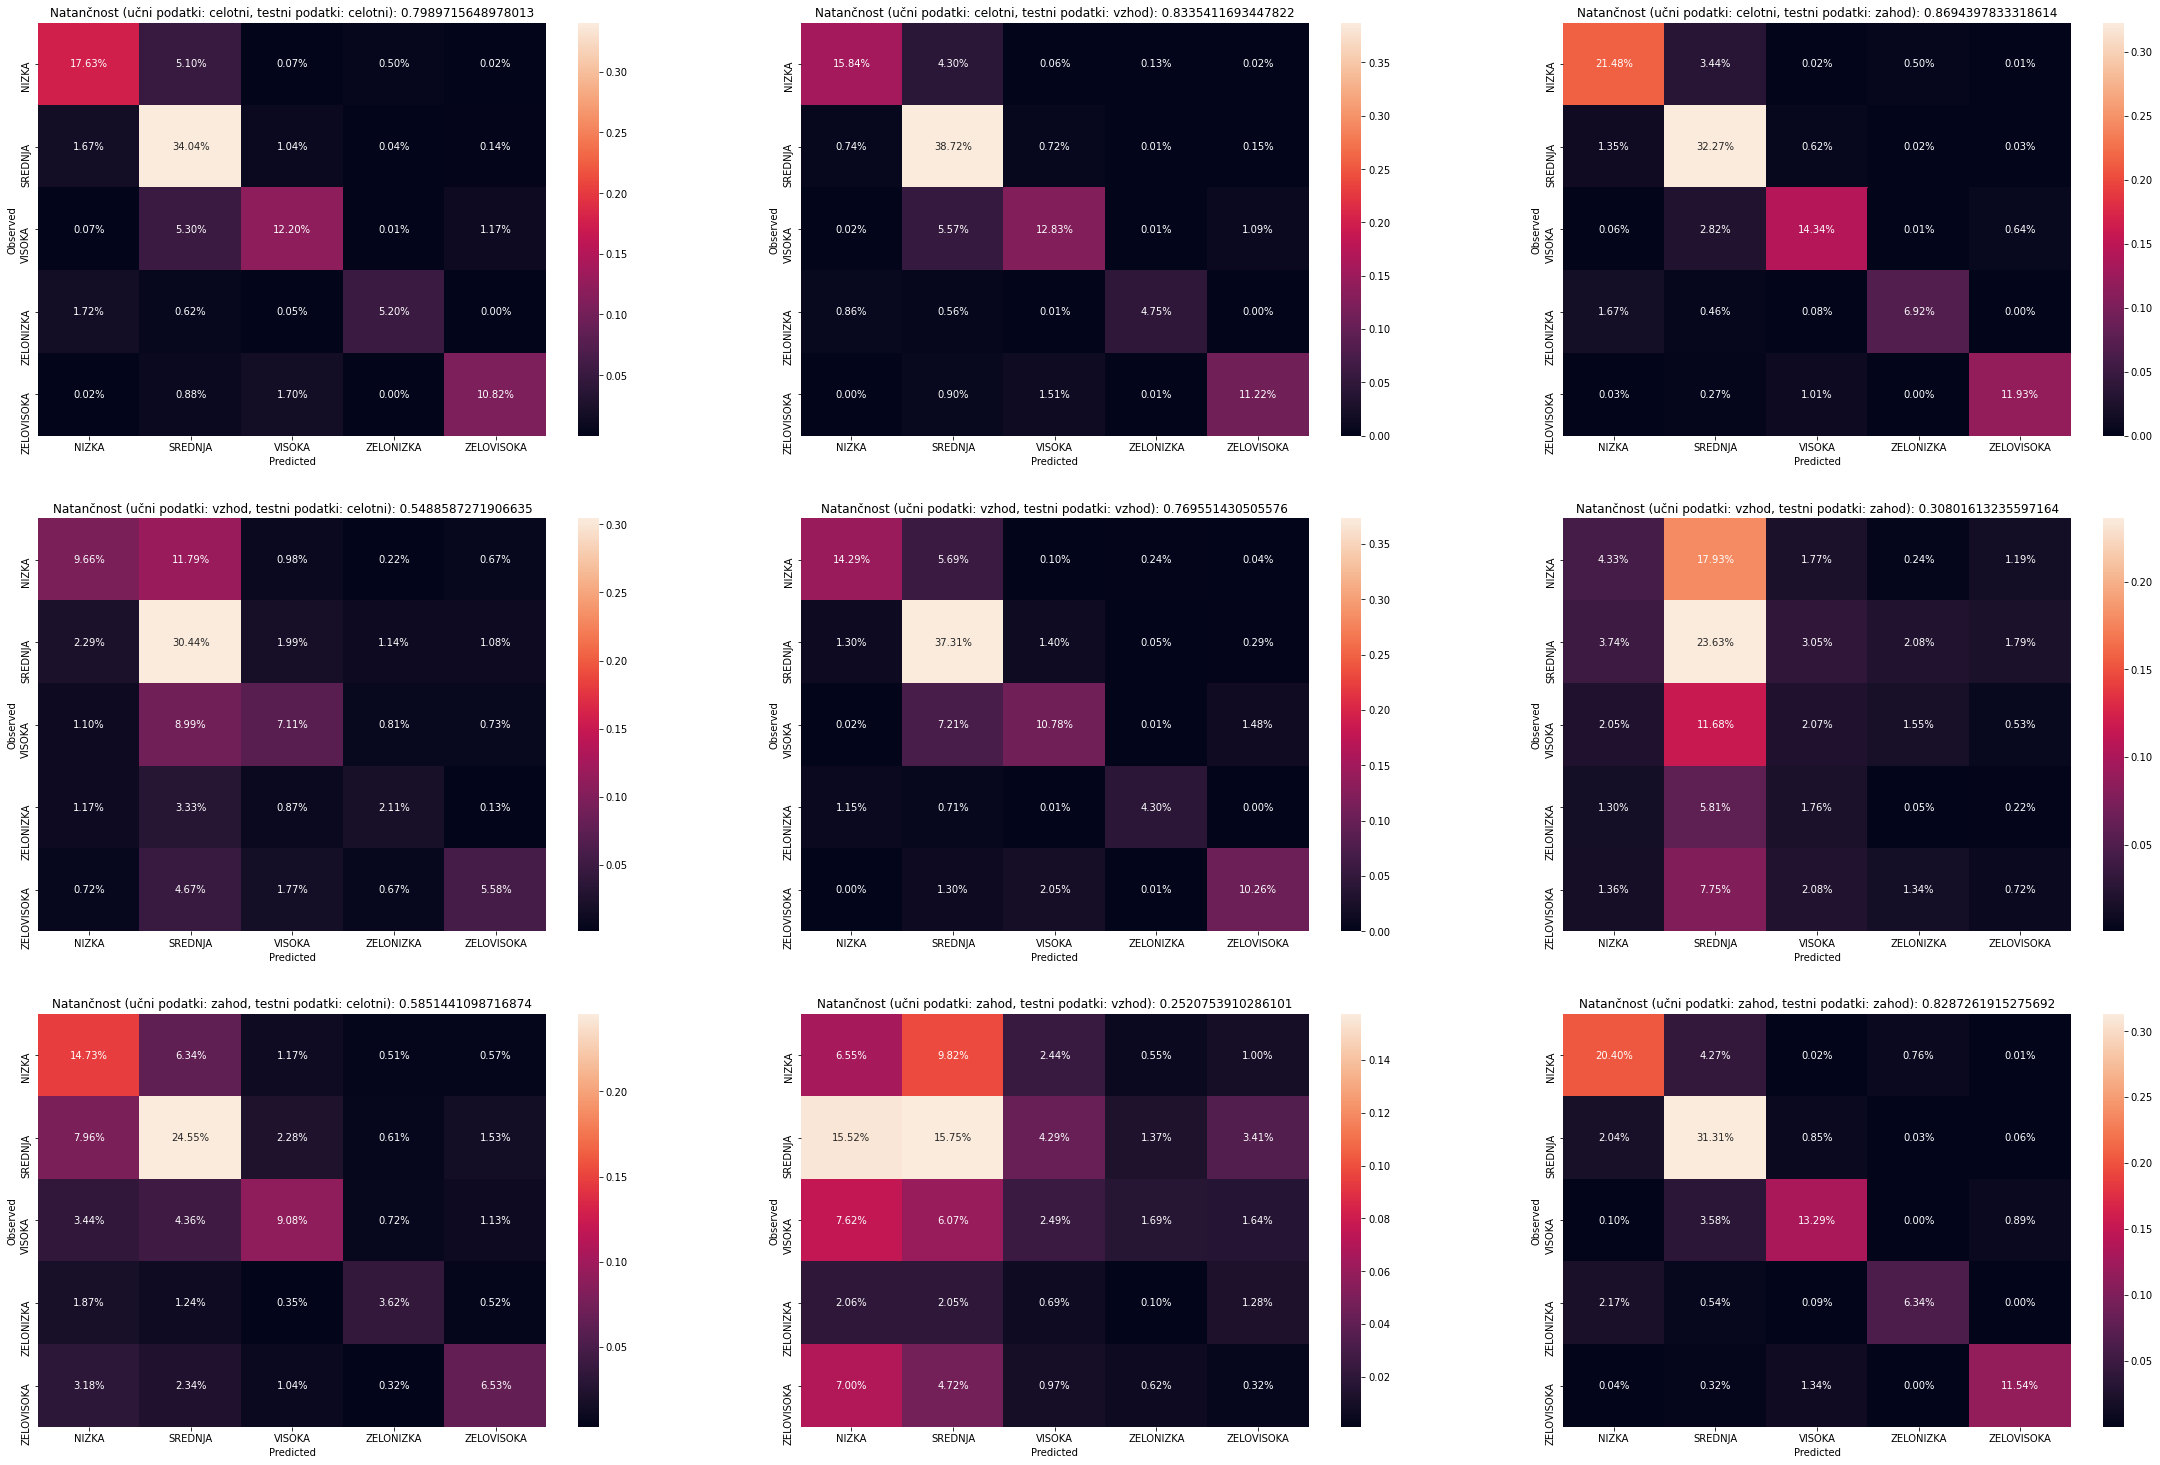

In [20]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, acc = get_best_from_pickle("pickled_data/bagging/bagging_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data_vzhod = prep_data[prep_data["regija"] == 0]
prep_data_zahod = prep_data[prep_data["regija"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "norm_poraba")
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "norm_poraba")
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "norm_poraba")

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}


for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = BaggingClassifier(KNeighborsClassifier(),
            max_samples=0.5, max_features=0.5, n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cf_mat = confusion_matrix(y_test, y_pred)
        print(f"Natančnost na testni množici (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")
        sns.heatmap(cf_mat/np.sum(cf_mat), fmt='.2%', annot=True,  ax=ax[i, j], xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        ax[i, j].set(xlabel='Predicted', ylabel='Observed')
        ax[i, j].set_title(f"Natančnost (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")

## Extra Trees classifier 

### Extra Trees classifier (Extremely Randomized Trees) (atributi izbrani z metriko Chi^2)

In [21]:
def best_ETC_atributes_chi2():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    le = preprocessing.LabelEncoder()
    for e in prep_data.select_dtypes(include=['object']).columns:
        prep_data[e] = le.fit_transform(prep_data[e])

    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X = transform_negative_data(X)
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    for i in range(2, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
        r = (Extra_Tree_best_n(X_train, y_train))
        print(i, ":", r)
        res[i] = r

    pickle.dump(res, open("pickled_data/extra_tree/extra_tree_chi2.pickle", "wb"))

# best_ETC_atributes_chi2()

Najboljša natačnost na validacijski množici: 0.8660715957122089 (# atributov: 16)
Natančnost na testni množici: 0.8680604810110258
Izbrani atributi:
['ura', 'regija', 'stavba', 'namembnost', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'smer_vetra', 'mesec', 'teden', 'dan', 'vikend', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'temp_rosisca_MA_21']


[Text(0.5, 15.0, '# atributov'),
 Text(-33.25, 0.5, 'Natančnost na validacijski množici')]

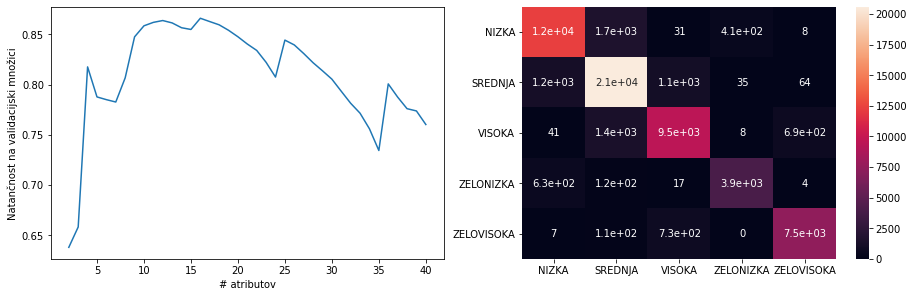

In [23]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=2, top=1)

plot_validation_acc("pickled_data/extra_tree/extra_tree_chi2.pickle")
n_features, ops, acc = get_best_from_pickle("pickled_data/extra_tree/extra_tree_chi2.pickle")

print(f"Najboljša natačnost na validacijski množici: {acc} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]


clf = ExtraTreesClassifier(n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
cf_mat = confusion_matrix(y_test, y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(y_test, y_pred_test)}")
sns.heatmap(cf_mat, annot=True,  ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)
print("Izbrani atributi:")
print(X_train.columns.tolist())
ax[0].set(xlabel='# atributov', ylabel='Natančnost na validacijski množici')

### Ovrednotenje modela na mesecnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, natančnost: 0.8279525386313465
Število mesecev v učni množici: 2, natančnost: 0.8269900016571838
Število mesecev v učni množici: 3, natančnost: 0.8147671028544308
Število mesecev v učni množici: 4, natančnost: 0.746584938704028
Število mesecev v učni množici: 5, natančnost: 0.7555792520374743
Število mesecev v učni množici: 6, natančnost: 0.7792549306062819
Število mesecev v učni množici: 7, natančnost: 0.7518927242397023
Število mesecev v učni množici: 8, natančnost: 0.7919389228970356
Število mesecev v učni množici: 9, natančnost: 0.740604451951499
Število mesecev v učni množici: 10, natančnost: 0.7887230514096186
Število mesecev v učni množici: 11, natančnost: 0.7685090941275391
Povprečna natačnost: 0.7811633644651036


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='Natančnost'>

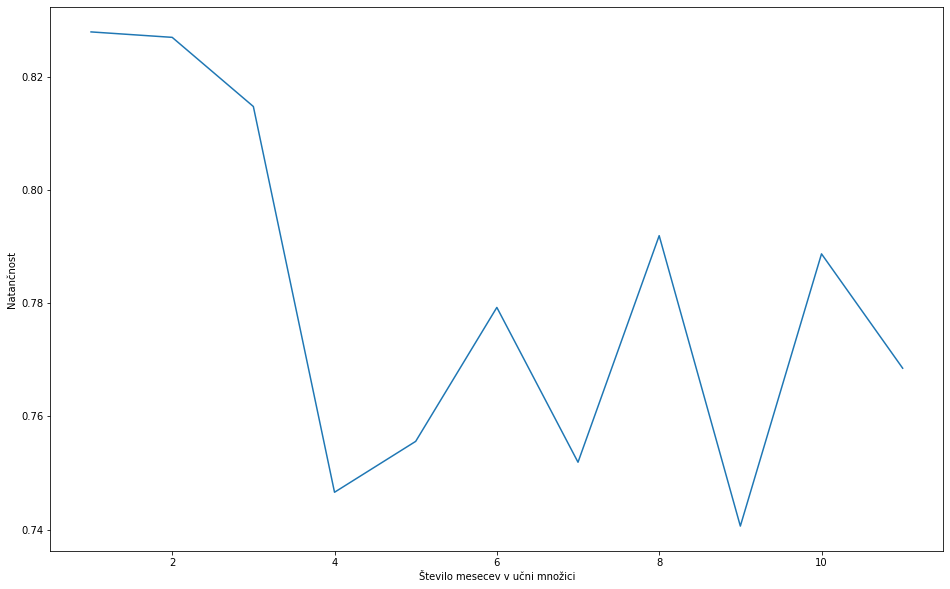

In [77]:
n_features, ops, acc = get_best_from_pickle("pickled_data/extra_tree/extra_tree_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data["padavine"] = prep_data["padavine"].apply(lambda x: x + 1)
prep_data["temp_zraka"] = prep_data["temp_zraka"].apply(lambda x: x + 100)
prep_data["temp_rosisca"] = prep_data["temp_rosisca"].apply(lambda x: x + 100)
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)


clf = ExtraTreesClassifier(n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)
res = validate_by_months(clf, n_features, prep_data)


print(f"Povprečna natačnost: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='Natančnost')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naucenih na podatkih posameznih regiji

Natančnost na testni množici (učni podatki: celotni, testni podatki: celotni): 0.8680604810110258
Natančnost na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.956817614992696
Natančnost na testni množici (učni podatki: celotni, testni podatki: zahod): 0.9554299508375284
Natančnost na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.5936069379070217
Natančnost na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.8461538461538461
Natančnost na testni množici (učni podatki: vzhod, testni podatki: zahod): 0.29317907503900614
Natančnost na testni množici (učni podatki: zahod, testni podatki: celotni): 0.6747211296666452
Natančnost na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.33683685466918445
Natančnost na testni množici (učni podatki: zahod, testni podatki: zahod): 0.8881921752185816


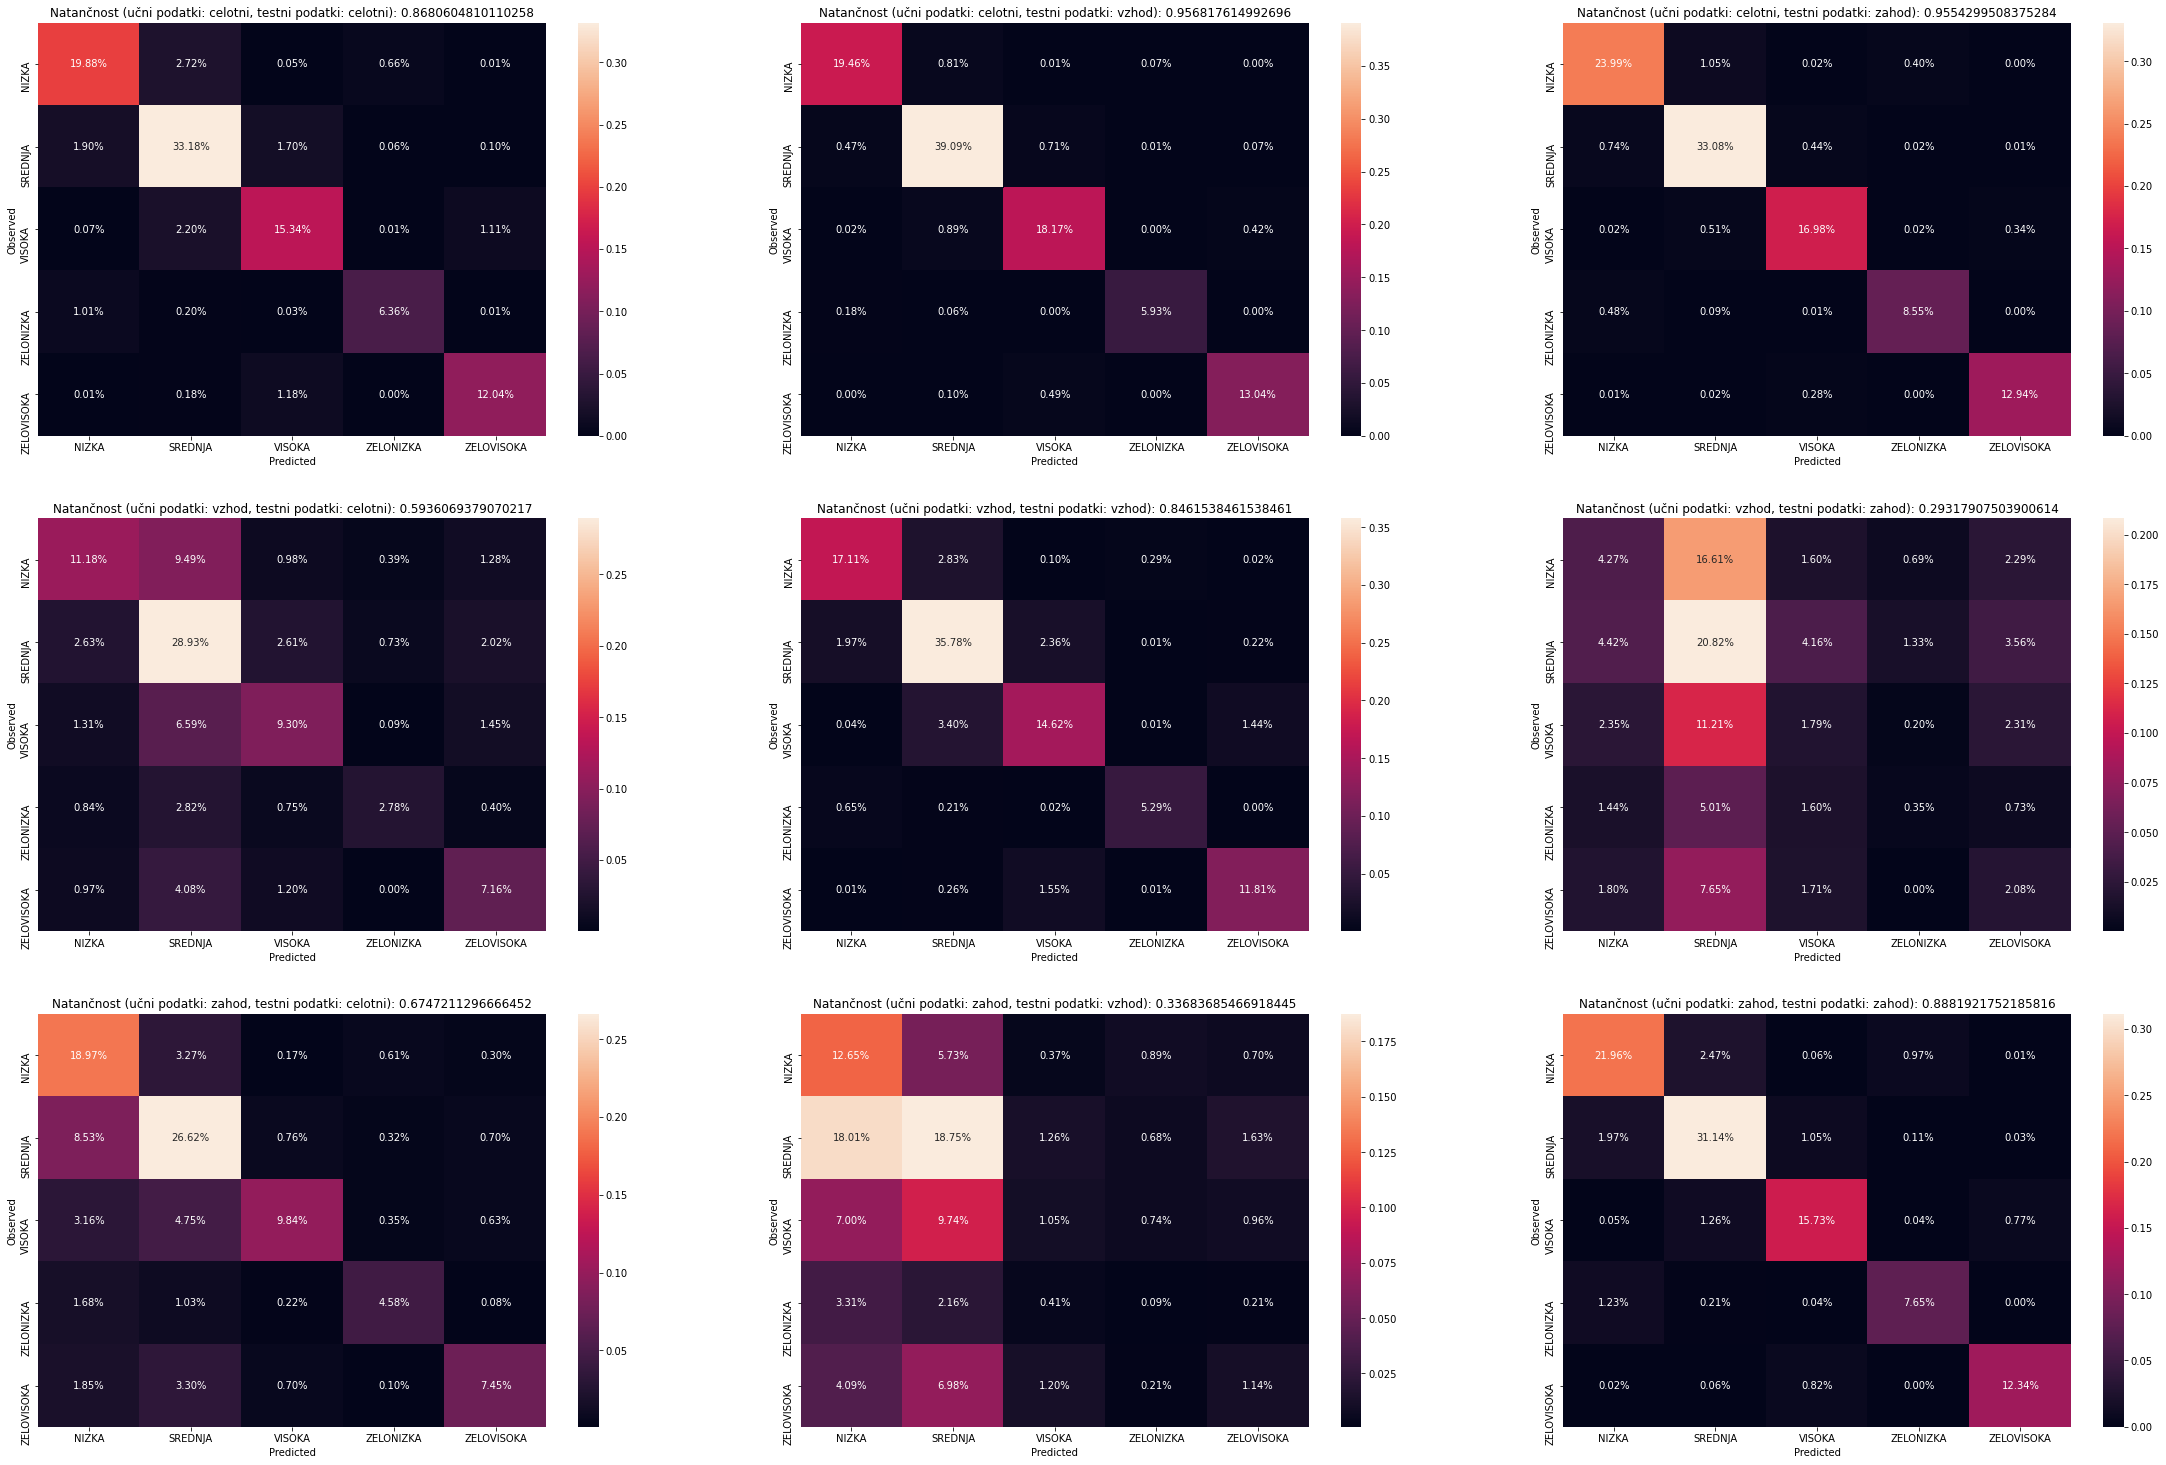

In [27]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, acc = get_best_from_pickle("pickled_data/extra_tree/extra_tree_chi2.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

prep_data_vzhod = prep_data[prep_data["regija"] == 0]
prep_data_zahod = prep_data[prep_data["regija"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "norm_poraba")
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "norm_poraba")
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "norm_poraba")

selector = SelectKBest(chi2, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}


for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = ExtraTreesClassifier(n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cf_mat = confusion_matrix(y_test, y_pred)
        print(f"Natančnost na testni množici (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")
        sns.heatmap(cf_mat/np.sum(cf_mat), fmt='.2%', annot=True,  ax=ax[i, j], xticklabels=le.classes_, yticklabels=le.classes_)
        ax[i, j].set(xlabel='Predicted', ylabel='Observed')
        ax[i, j].set_title(f"Natančnost (učni podatki: {k}, testni podatki: {k2}): {accuracy_score(y_test, y_pred)}")

## Klasifikacija z glasovanjem in uteženim glasovanjem

## Klasifikacija z glasovanjem in uteženim glasovanjem (atributi izbrani z metriko Chi^2)

Natančnost pri glasovanju na podlagi večinskega glasa (hard voting): 0.8714778515700561
Natančnost pri glasovanju na podlagi povprečja verjetnosti (soft voting): 0.869333935134438
Natančnost pri glasovanju na podlagi uteženega povprečja verjetnosti (weighted soft voting): 0.8741859565413631


Text(0.5, 1.0, 'Natančnost pri glasovanju na podlagi uteženega povprečja verjetnosti (weighted soft voting): 0.8741859565413631')

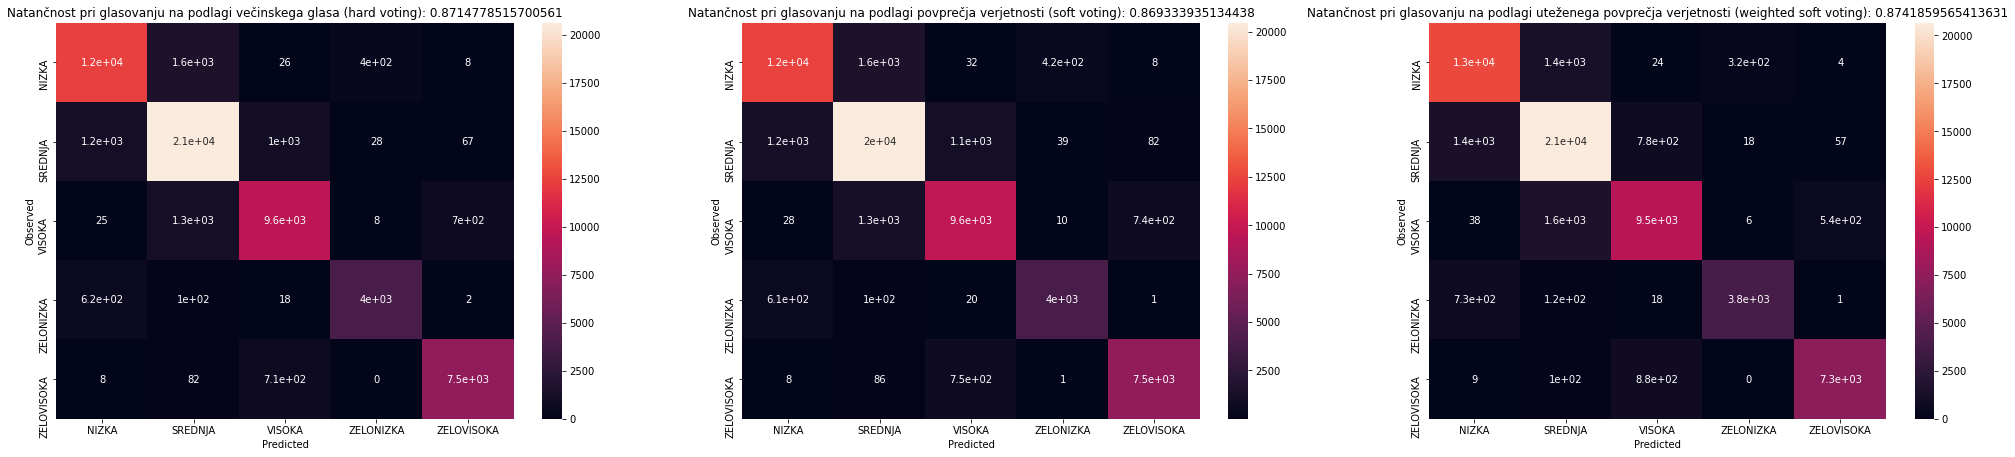

In [29]:
def make_RandomForest(ops):
    return RandomForestClassifier(random_state=0, n_jobs=-1)

def make_DecisionTree(ops):
    return DecisionTreeClassifier(max_depth=ops["max_depth"], random_state=0)

def make_KNN(ops):
    return KNeighborsClassifier(n_neighbors=ops["n_neighbors"], n_jobs=-1)

def make_ETC(ops):
    return ExtraTreesClassifier(n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)

def make_Bagging(ops):
    return BaggingClassifier(KNeighborsClassifier(),
        max_samples=0.5, max_features=0.5, n_estimators=ops["n_estimators"], random_state=0, n_jobs=-1)



prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])

le = preprocessing.LabelEncoder()
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data[e] = le.fit_transform(prep_data[e])

y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clfs = {
    "RandomForest": { 
        "file": "pickled_data/random_forest/random_forest_chi2.pickle",
        "clf": make_RandomForest
    },
    "DecisionTree": {
        "file": "pickled_data/decision_tree/decision_tree_chi2.pickle",
        "clf": make_DecisionTree
    },
    "KNN": {
        "file": "pickled_data/knn/knn_chi2.pickle",
        "clf": make_KNN
    },
    "ETC": {
        "file": "pickled_data/extra_tree/extra_tree_chi2.pickle",
        "clf": make_ETC
    }
}

weights = [0.4, 0.2, 0.2, 0.3]


for k,v in clfs.items():
    n_features, ops, acc = get_best_from_pickle(v["file"])
    selector = SelectKBest(chi2, k=n_features)
    selector.fit(X_train, y_train)
    X_train_ = X_train.loc[:, selector.get_support()]
    clf = v["clf"](ops).fit(X_train_, y_train)
    clfs[k]["clf"] = clf
    clfs[k]["cols"] = selector.get_support()

for k,v in clfs.items():
    X_test_ = X_test.loc[:, v["cols"]]
    clfs[k]["pred_class"] = v["clf"].predict(X_test_)
    clfs[k]["pred_prob"] = v["clf"].predict_proba(X_test_)



pred_class = np.asarray([np.bincount(pred).argmax() for pred in zip(*[e["pred_class"] for e in clfs.values()])])

pred_prob = np.asarray([pred for pred in zip(*[e["pred_prob"] for e in clfs.values()])])
pred_prob = np.average(pred_prob, axis=1)
pred_prob = np.argmax(pred_prob, axis=1)

pred_prob_weighted = np.asarray([pred for pred in zip(*[e["pred_prob"] for e in clfs.values()])])
pred_prob_weighted = np.average(pred_prob_weighted, axis=1, weights=weights)
pred_prob_weighted = np.argmax(pred_prob_weighted, axis=1)


# for k,v in clfs.items():
#     print(f"{k}: {accuracy_score(y_test, v['pred_class'])}")
    
print(f"Natančnost pri glasovanju na podlagi večinskega glasa (hard voting): {accuracy_score(y_test, pred_class)}")
print(f"Natančnost pri glasovanju na podlagi povprečja verjetnosti (soft voting): {accuracy_score(y_test, pred_prob)}")
print(f"Natančnost pri glasovanju na podlagi uteženega povprečja verjetnosti (weighted soft voting): {accuracy_score(y_test, pred_prob_weighted)}")

f, ax = plt.subplots(1, 3)
plt.subplots_adjust(left=0, right=4.5, top=1.5)

cf_mat = confusion_matrix(y_test, pred_prob_weighted)
sns.heatmap(cf_mat, annot=True,  ax=ax[0], xticklabels=le.classes_, yticklabels=le.classes_)

cf_mat = confusion_matrix(y_test, pred_prob)
sns.heatmap(cf_mat, annot=True,  ax=ax[1], xticklabels=le.classes_, yticklabels=le.classes_)

cf_mat = confusion_matrix(y_test, pred_class)
sns.heatmap(cf_mat, annot=True,  ax=ax[2], xticklabels=le.classes_, yticklabels=le.classes_)

ax[0].set(xlabel='Predicted', ylabel='Observed')
ax[1].set(xlabel='Predicted', ylabel='Observed')
ax[2].set(xlabel='Predicted', ylabel='Observed')
ax[0].set_title(f"Natančnost pri glasovanju na podlagi večinskega glasa (hard voting): {accuracy_score(y_test, pred_class)}")
ax[1].set_title(f"Natančnost pri glasovanju na podlagi povprečja verjetnosti (soft voting): {accuracy_score(y_test, pred_prob)}")
ax[2].set_title(f"Natančnost pri glasovanju na podlagi uteženega povprečja verjetnosti (weighted soft voting): {accuracy_score(y_test, pred_prob_weighted)}")


## Klasifikacija z globoko nevronsko mrežo (atributi izbrani z metriko Chi^2)

In [ ]:
def make_dnn_classification():
    prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
    y = prep_data["norm_poraba"]
    X = prep_data.drop(columns=["norm_poraba"])
    X = transform_negative_data(X)
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    for e in X.select_dtypes(include=['object']).columns:
        X = one_hot(X, e)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    selector = SelectKBest(chi2, k=25)
    selector.fit(X_train, y_train)

    X_train = X_train.loc[:, selector.get_support()]
    X_test = X_test.loc[:, selector.get_support()]


    for e in X_test.columns:
        if e not in ("vikend"):
            scaler = StandardScaler()
            scaler.fit(X[[e]])
            X_test[[e]] = scaler.transform(X_test[[e]])
            X_train[[e]] = scaler.transform(X_train[[e]])

    y_test = y_test.to_numpy().reshape(-1, 1)
    y_train = y_train.to_numpy().reshape(-1, 1)
    y = y.to_numpy().reshape(-1, 1)
    enc = OneHotEncoder()
    enc.fit(y)
    y_test = enc.transform(y_test).toarray()
    y_train = enc.transform(y_train).toarray()


    with tf.device('/GPU:0'):
        model = Sequential()
        model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
        model.add(Dropout(.2))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(5, activation="softmax"))

        lr_schedule = ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=10000,
            decay_rate=0.9)

        optimizer = Adam(learning_rate=lr_schedule)

        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
        model.fit(X_train, y_train, batch_size=32, epochs=54, validation_split=0.2)
        model.save("models/classification_model")

# make_dnn_classification()

Natančnost na testni množici: 0.8544715971371462
Izbrani atributi (# atributov: 25):
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'smer_vetra', 'mesec', 'teden', 'dan', 'vikend', 'temp_zraka_MA_7', 'temp_zraka_MA_14', 'temp_zraka_MA_21', 'temp_zraka_MA_28', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'temp_rosisca_MA_21', 'temp_rosisca_MA_28', 'regija_vzhodna', 'regija_zahodna', 'namembnost_javno_storitvena', 'namembnost_kulturno_razvedrilna', 'namembnost_poslovna', 'namembnost_stanovanjska']


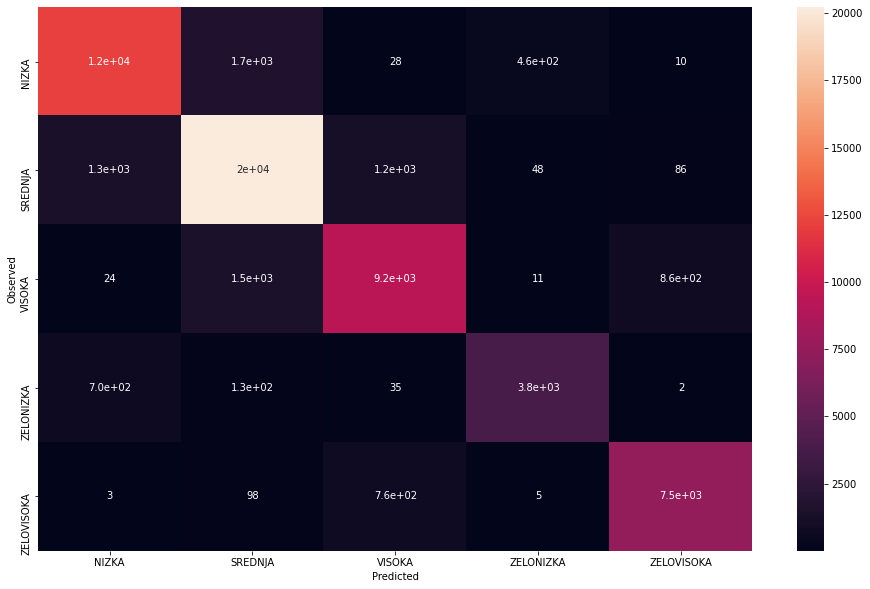

In [32]:
model = load_model("models/classification_model//")

prep_data = raw_data.drop(columns=["datetime", "datum", "poraba"])
y = prep_data["norm_poraba"]
X = prep_data.drop(columns=["norm_poraba"])
X = transform_negative_data(X)
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

le = preprocessing.LabelEncoder()
le.fit(y)


for e in X.select_dtypes(include=['object']).columns:
    X = one_hot(X, e)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
selector = SelectKBest(chi2, k=25)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]


for e in X_test.columns:
    if e not in ("vikend"):
        scaler = StandardScaler()
        scaler.fit(X[[e]])
        X_test[[e]] = scaler.transform(X_test[[e]])
        X_train[[e]] = scaler.transform(X_train[[e]])

y_test = y_test.to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(y)
y_test = enc.transform(y_test).toarray()
y_train = enc.transform(y_train).toarray()

y_pred_test = np.argmax(model.predict(X_test), axis=-1)
y_pred_train = np.argmax(model.predict(X_train), axis=-1)
cf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test)
print(f"Natančnost na testni množici: {accuracy_score(np.argmax(y_test, axis=1), y_pred_test)}")
f, ax = plt.subplots(figsize=(16,10))
sns.heatmap(cf_mat, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set(xlabel='Predicted', ylabel='Observed')
print(f"Izbrani atributi (# atributov: {len(X_train.columns)}):")
print(X_train.columns.tolist())

# Regresija

## Regresijsko drevo

### Regresijsko drevo (atributi izbrani z metriko f-regression)

In [35]:
def best_regression_tree_atributes_f_regression():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    y = prep_data["poraba"]
    X = prep_data.drop(columns=["poraba"])
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    for e in X.select_dtypes(include=['object']).columns:
        X = one_hot(X, e)
            
    for i in range(5, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        selector = SelectKBest(f_regression, k=i)
        selector.fit(X_train, y_train)
        X_train = X_train.loc[:, selector.get_support()]
        r = (RegressionTree_best_max_depth(X_train, y_train, 15,  40, y))
        print(i, ":", r)

        res[i] = r

    pickle.dump(res, open("pickled_data/regression_tree/regression_tree_f_regression.pickle", "wb"))

# best_regression_tree_atributes_f_regression()

Najboljša RMSE na validacijski množici: 0.03099734511558258 (# atributov: 18)
RMSE na testni množici: 0.02759171769855038
Root Mean Squared Error na testni množici: 42.22984854241357
Test Mean Absolute Error na testni množici: 14.703793668432422
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_rosisca', 'mesec', 'teden', 'dan', 'vikend', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'regija_vzhodna', 'regija_zahodna', 'namembnost_izobrazevalna', 'namembnost_javno_storitvena', 'namembnost_kulturno_razvedrilna', 'namembnost_poslovna', 'namembnost_stanovanjska']


Text(0.5, 1.0, 'Napovedane in dejanske vrednosti (0.005 testne množice)')

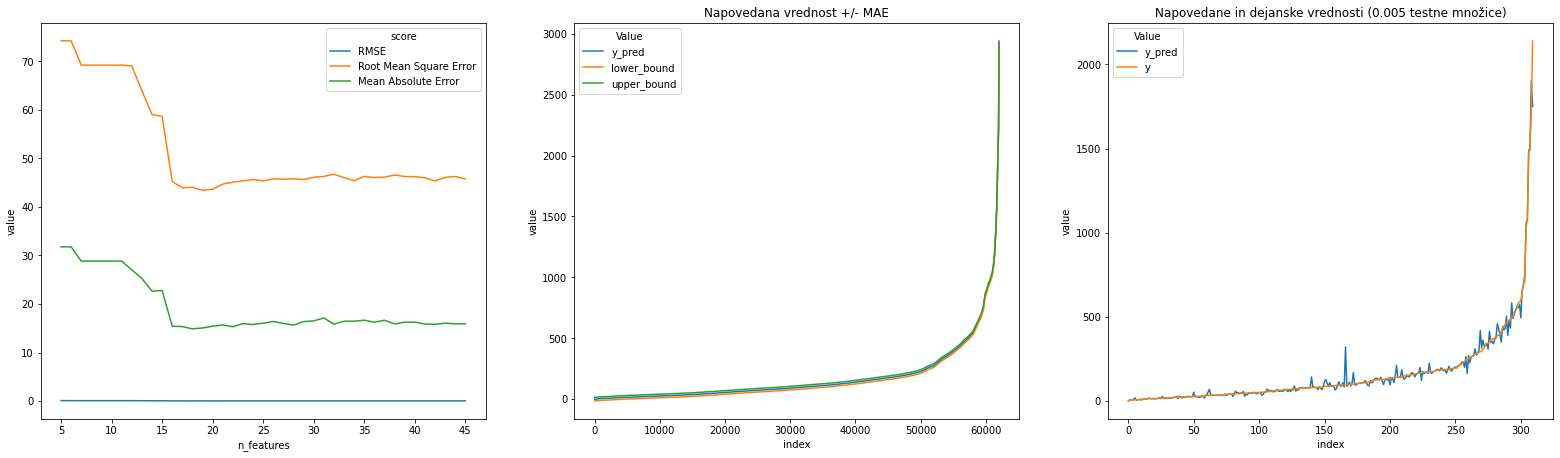

In [37]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(left=0, right=3.5, top=1.5)

plot_regression_validation_acc("pickled_data/regression_tree/regression_tree_f_regression.pickle")
n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_tree/regression_tree_f_regression.pickle")

print(f"Najboljša RMSE na validacijski množici: {rmse} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
y = prep_data["poraba"]
X = prep_data.drop(columns=["poraba"])
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

for e in X.select_dtypes(include=['object']).columns:
    X = one_hot(X, e)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    
selector = SelectKBest(f_regression, k=n_features)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

clf = DecisionTreeRegressor(max_depth=ops["max_depth"], random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
print(f"RMSE na testni množici: {RMSE(y_test, y_pred_test, y.mean())}")
print(f"Root Mean Squared Error na testni množici: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")
print(f"Mean Absolute Error na testni množici: {mean_absolute_error(y_test, y_pred_test)}")

print("Izbrani atributi:")
print(X_train.columns.tolist())

mae = mean_absolute_error(y_test, y_pred_test)
data = pd.DataFrame({
    "y_pred": y_pred_test,
    "lower_bound": [e - mae for e in y_pred_test],
    "upper_bound": [e + mae for e in y_pred_test]

})

data = data.sort_values(by=['y_pred'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value", ax=ax[1]).set_title("Napovedana vrednost +/- MAE")

data = pd.DataFrame({
    "y_pred": y_pred_test,
    "y": y_test
})

data = data.sample(frac=0.005, random_state=0)
data = data.sort_values(by=['y'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value", ax=ax[2]).set_title("Napovedane in dejanske vrednosti (0.005 testne množice)")

### Regresijsko drevo (atributi izbrani z metriko RReliefF)

In [38]:
def best_regression_tree_atributes_rrelieff():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    y = prep_data["poraba"]
    X = prep_data.drop(columns=["poraba"])
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
    
    
    for e in X.select_dtypes(include=['object']).columns:
        X = one_hot(X, e)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
#     relieff_scores = get_rrelieff_scores(X_train, y_train)
#     pickle.dump(relieff_scores, open("pickled_data/rrelieff.pickle", "wb"))
    relieff_scores = pickle.load(open("pickled_data/rrelieff.pickle", "rb"))
    print(relieff_scores)
            
    for i in range(5, len(X.columns)):
        cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -i)[-i:])
        X_train_n = X_train.drop(X_train.columns[list(cols)], axis=1)
        r = (RegressionTree_best_max_depth(X_train_n, y_train, 15, 40, y))
        print(i, ":", r)
        res[i] = r

    pickle.dump(res, open("pickled_data/regression_tree/regression_tree_rrelieff.pickle", "wb"))

# best_regression_tree_atributes_rrelieff()

Najboljša RMSE na validacijski množici: 0.03551449601713316 (# atributov: 45)
RMSE na testni množici: 0.03239550112785522
Root Mean Squared Error na testni množici: 45.758576554969494
Test Mean Absolute Error na testni množici: 16.20007104849632
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_zraka', 'temp_rosisca', 'oblacnost', 'padavine', 'pritisk', 'smer_vetra', 'hitrost_vetra', 'mesec', 'teden', 'vikend', 'temp_zraka_MA_7', 'temp_zraka_MA_14', 'temp_zraka_MA_21', 'temp_zraka_MA_28', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'temp_rosisca_MA_21', 'temp_rosisca_MA_28', 'oblacnost_MA_7', 'oblacnost_MA_14', 'oblacnost_MA_21', 'oblacnost_MA_28', 'padavine_MA_7', 'padavine_MA_14', 'padavine_MA_21', 'padavine_MA_28', 'pritisk_MA_7', 'pritisk_MA_14', 'pritisk_MA_21', 'pritisk_MA_28', 'hitrost_vetra_MA_7', 'hitrost_vetra_MA_14', 'hitrost_vetra_MA_21', 'hitrost_vetra_MA_28', 'regija_vzhodna', 'regija_zahodna', 'namembnost_izobrazevalna', 'namembnost_javno_storitvena'

Text(0.5, 1.0, 'Napovedane in dejanske vrednosti (0.005 testne množice)')

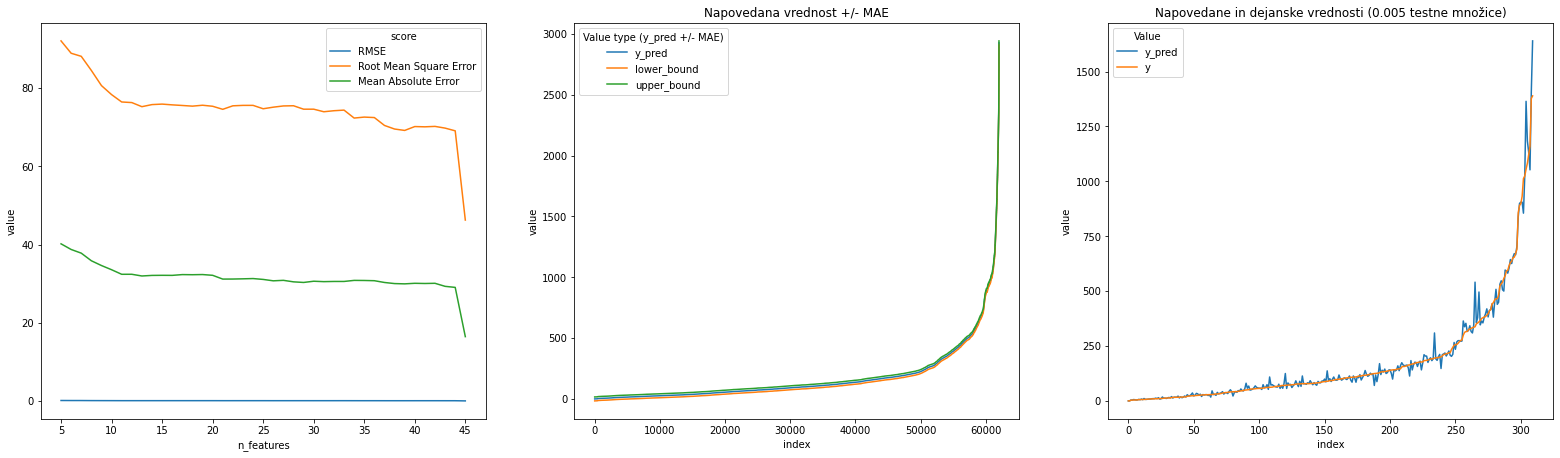

In [39]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(left=0, right=3.5, top=1.5)

plot_regression_validation_acc("pickled_data/regression_tree/regression_tree_rrelieff.pickle")
n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_tree/regression_tree_rrelieff.pickle")

print(f"Najboljša RMSE na validacijski množici: {rmse} (# atributov: {n_features})")

y = prep_data["poraba"]
X = prep_data.drop(columns=["poraba"])
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)
    
    
for e in X.select_dtypes(include=['object']).columns:
    X = one_hot(X, e)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#     relieff_scores = get_rrelieff_scores(X_train, y_train)
#     pickle.dump(relieff_scores, open("pickled_data/rrelieff.pickle", "wb"))
relieff_scores = pickle.load(open("pickled_data/rrelieff.pickle", "rb"))

cols = set([n for n in range(0, len(X_train.columns))]) - set(np.argpartition(relieff_scores, -n_features)[-n_features:])
X_train = X_train.drop(X_train.columns[list(cols)], axis=1)
X_test = X_test.drop(X_test.columns[list(cols)], axis=1)

clf = DecisionTreeRegressor(max_depth=ops["max_depth"], random_state=0)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
print(f"RMSE na testni množici: {RMSE(y_test, y_pred_test, y.mean())}")
print(f"Root Mean Squared Error na testni množici: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")
print(f"Mean Absolute Error na testni množici: {mean_absolute_error(y_test, y_pred_test)}")

print("Izbrani atributi:")
print(X_train.columns.tolist())

mae = mean_absolute_error(y_test, y_pred_test)
data = pd.DataFrame({
    "y_pred": y_pred_test,
    "lower_bound": [e - mae for e in y_pred_test],
    "upper_bound": [e + mae for e in y_pred_test]

})

data = data.sort_values(by=['y_pred'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value type (y_pred +/- MAE)", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value type (y_pred +/- MAE)", ax=ax[1]).set_title("Napovedana vrednost +/- MAE")

data = pd.DataFrame({
    "y_pred": y_pred_test,
    "y": y_test
})

data = data.sample(frac=0.005, random_state=0)
data = data.sort_values(by=['y'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value", ax=ax[2]).set_title("Napovedane in dejanske vrednosti (0.005 testne množice)")

### Ovrednotenje modela na mesečnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, RMSE: 0.08278323310669009
Število mesecev v učni množici: 2, RMSE: 0.0577107331531948
Število mesecev v učni množici: 3, RMSE: 0.04566540640854786
Število mesecev v učni množici: 4, RMSE: 0.06643814086437509
Število mesecev v učni množici: 5, RMSE: 0.059641423849880526
Število mesecev v učni množici: 6, RMSE: 0.05005173984847262
Število mesecev v učni množici: 7, RMSE: 0.04071076065789918
Število mesecev v učni množici: 8, RMSE: 0.04218477543260872
Število mesecev v učni množici: 9, RMSE: 0.12149651332433654
Število mesecev v učni množici: 10, RMSE: 0.09560459103714727
Število mesecev v učni množici: 11, RMSE: 0.17679597304704162
Povprečna RMSE: 0.0762802991572904


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='RMSE'>

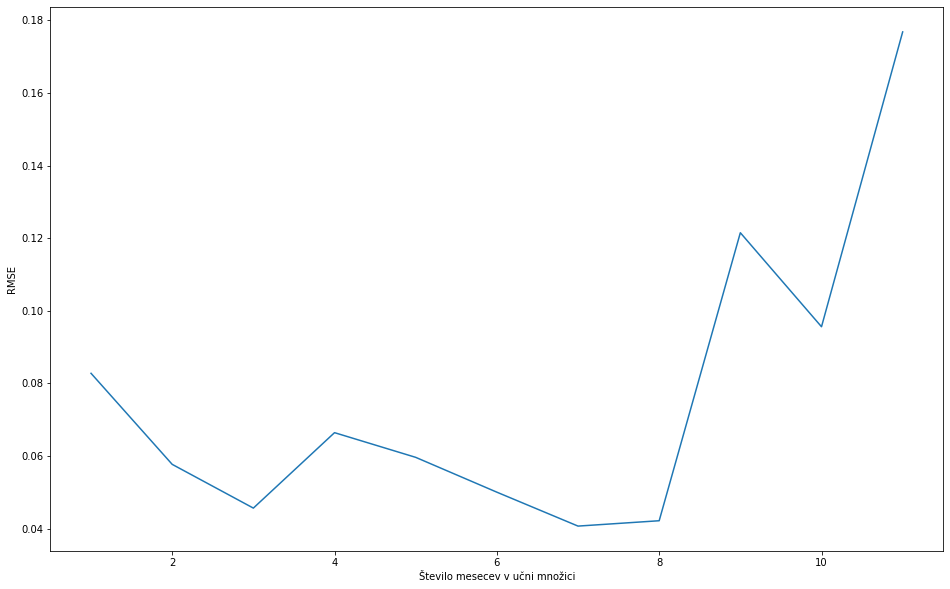

In [79]:
n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_tree/regression_tree_f_regression.pickle")
prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

clf = DecisionTreeRegressor(max_depth=ops["max_depth"], random_state=0)
res = validate_regression_by_months(clf, n_features, prep_data)

print(f"Povprečna RMSE: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='RMSE')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naučenih na podatkih posameznih regiji

RMSE na testni množici (učni podatki: celotni, testni podatki: celotni): 0.028747401026433052
RMSE na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.009436115970950808
RMSE na testni množici (učni podatki: celotni, testni podatki: zahod): 0.006092420493956175
RMSE na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.5521634815351927
RMSE na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.03637650587359294
RMSE na testni množici (učni podatki: vzhod, testni podatki: zahod): 1.9130787555508404
RMSE na testni množici (učni podatki: zahod, testni podatki: celotni): 0.6904682686221426
RMSE na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.9781940242702859
RMSE na testni množici (učni podatki: zahod, testni podatki: zahod): 0.013930353585988547


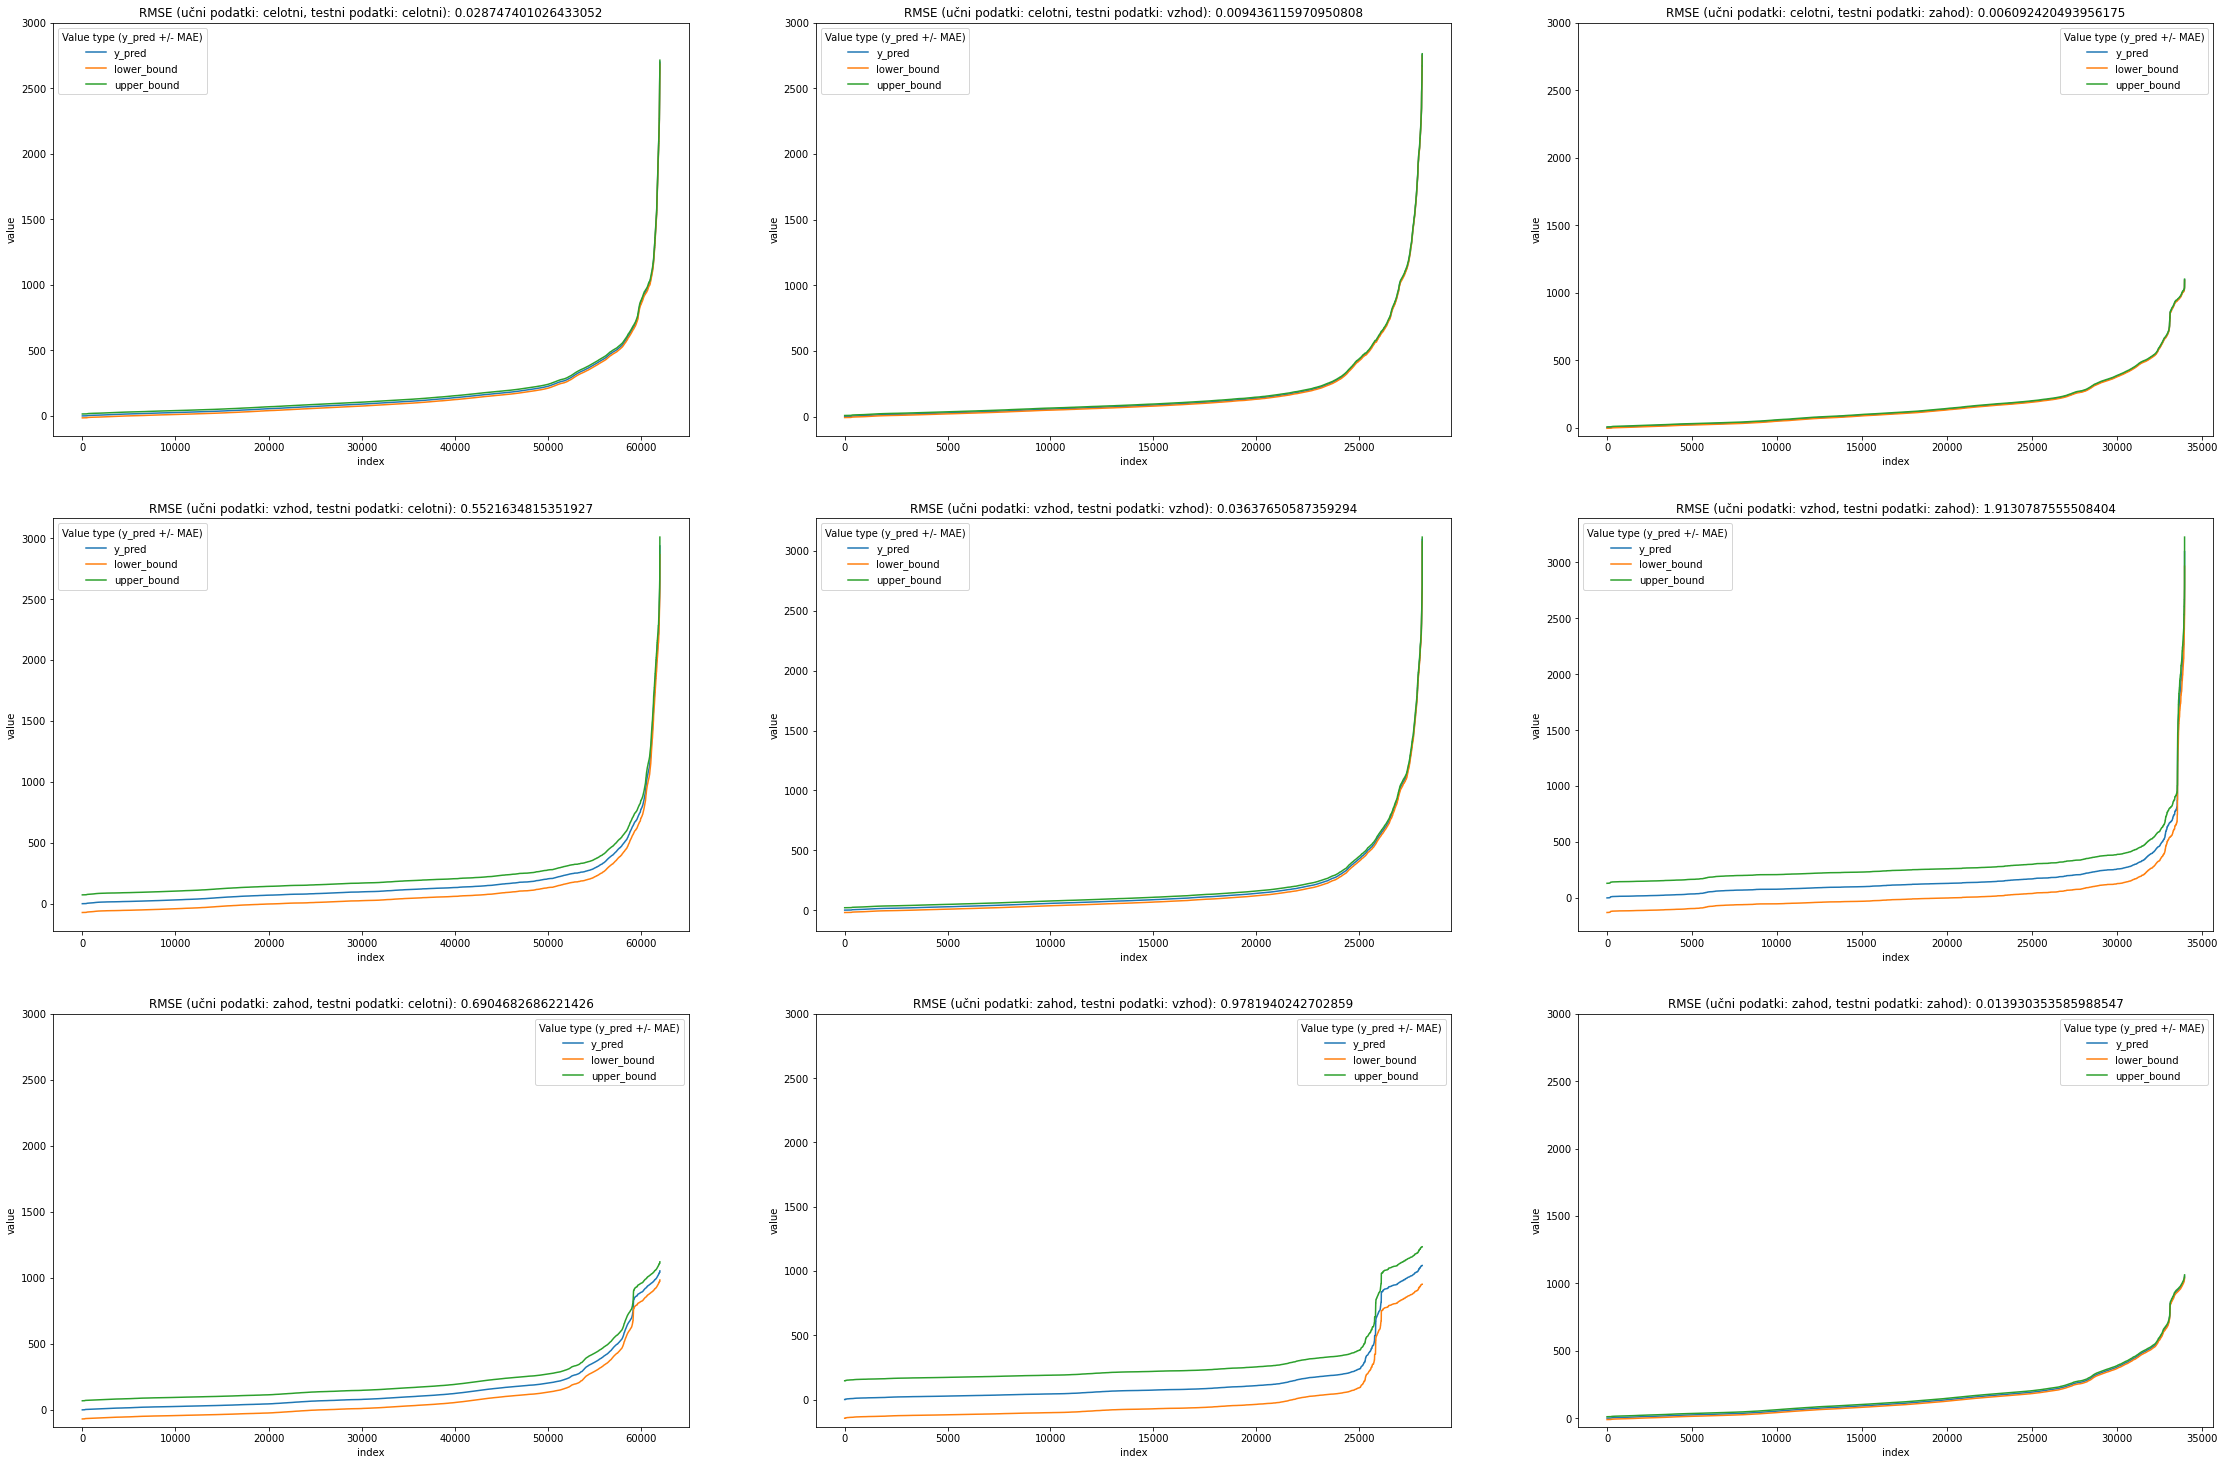

In [44]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_tree/regression_tree_f_regression.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data = one_hot(prep_data, e)

prep_data_vzhod = prep_data[prep_data["regija_vzhodna"] == 1]
prep_data_zahod = prep_data[prep_data["regija_zahodna"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "poraba", transform_negative=False)
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "poraba", transform_negative=False)
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "poraba", transform_negative=False)

selector = SelectKBest(f_regression, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}

for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = DecisionTreeRegressor(max_depth=ops["max_depth"], random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"RMSE na testni množici (učni podatki: {k}, testni podatki: {k2}): {RMSE(y_test, y_pred, y.mean())}")
        mae = mean_absolute_error(y_test, y_pred)
        res_data = pd.DataFrame({
            "y_pred": y_pred,
            "lower_bound": [e - mae for e in y_pred],
            "upper_bound": [e + mae for e in y_pred]

        })
        res_data = res_data.sort_values(by=['y_pred'], ignore_index=True)
        res_data =res_data.reset_index()
        res_data = res_data.melt(id_vars=["index"], var_name="Value type (y_pred +/- MAE)", value_name="value")
        sns.lineplot(data=res_data, x="index", y="value", hue="Value type (y_pred +/- MAE)", ax=ax[i, j])
        ax[i, j].set_title(f"RMSE (učni podatki: {k}, testni podatki: {k2}): {RMSE(y_test, y_pred, y.mean())}")
        yticks = [i for i in range(0, 3500, 500)]
        ax[i, j].set_yticks(yticks)

## Regresijski naključni gozdovi

### Regresijski naključni gozdovi (atributi izbrani z metriko f-regression)

In [ ]:
def best_regression_RandomForest_atributes_f_regression():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    y = prep_data["poraba"]
    X = prep_data.drop(columns=["poraba"])
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    for e in X.select_dtypes(include=['object']).columns:
        X = one_hot(X, e)
            
    for i in range(5, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        selector = SelectKBest(f_regression, k=i)
        selector.fit(X_train, y_train)
        X_train = X_train.loc[:, selector.get_support()]
        r = (RegressionRandomForest_best_max_depth(X_train, y_train, 15,  30, y))
        print(i, ":", r)

        res[i] = r

    pickle.dump(res, open("pickled_data/regression_randomForest/regression_randomForest_f_regression.pickle", "wb"))

# best_regression_RandomForest_atributes_f_regression()

Najboljša RMSE na validacijski množici: 0.018023799468503753 (# atributov: 19)
RMSE na testni množici: 0.01579708925597358
Root Mean Squared Error na testni množici: 31.95351881050272
Test Mean Absolute Error na testni množici: 11.922838675061064
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_rosisca', 'mesec', 'teden', 'dan', 'vikend', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'temp_rosisca_MA_21', 'regija_vzhodna', 'regija_zahodna', 'namembnost_izobrazevalna', 'namembnost_javno_storitvena', 'namembnost_kulturno_razvedrilna', 'namembnost_poslovna', 'namembnost_stanovanjska']


Text(0.5, 1.0, 'Napovedane in dejanske vrednosti (0.005 testne množice)')

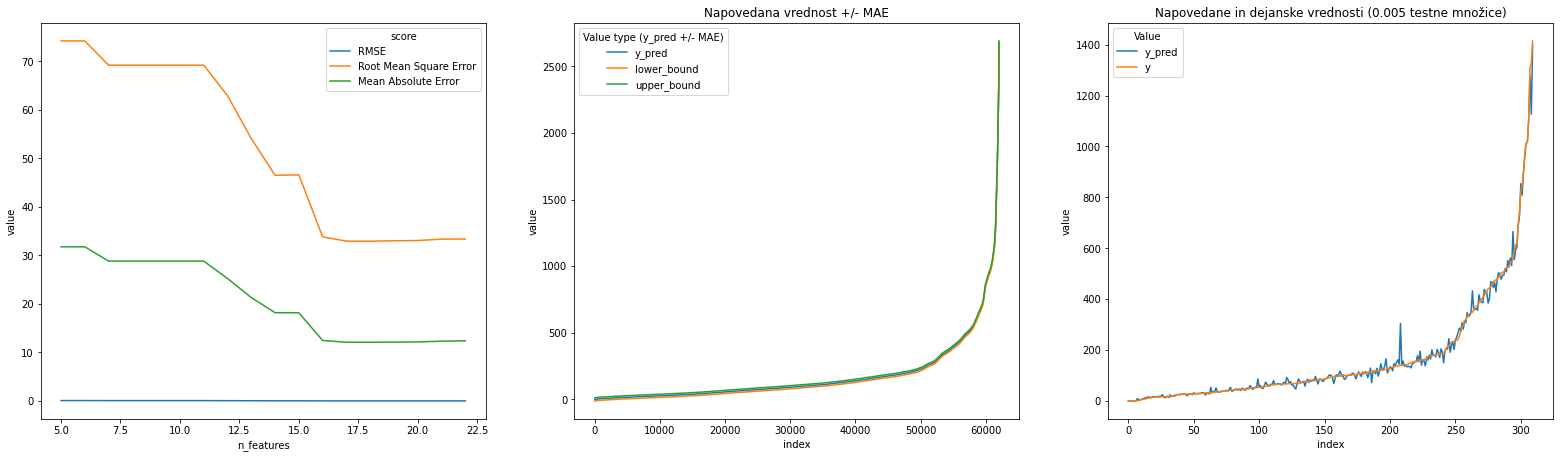

In [45]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(left=0, right=3.5, top=1.5)

plot_regression_validation_acc("pickled_data/regression_randomForest/regression_randomForest_f_regression.pickle")
n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_randomForest/regression_randomForest_f_regression.pickle")

print(f"Najboljša RMSE na validacijski množici: {rmse} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
y = prep_data["poraba"]
X = prep_data.drop(columns=["poraba"])
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

for e in X.select_dtypes(include=['object']).columns:
    X = one_hot(X, e)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
selector = SelectKBest(f_regression, k=n_features)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

clf = RandomForestRegressor(max_depth=ops["max_depth"], random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
print(f"RMSE na testni množici: {RMSE(y_test, y_pred_test, y.mean())}")
print(f"Root Mean Squared Error na testni množici: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")
print(f"Mean Absolute Error na testni množici: {mean_absolute_error(y_test, y_pred_test)}")

print("Izbrani atributi:")
print(X_train.columns.tolist())

mae = mean_absolute_error(y_test, y_pred_test)
data = pd.DataFrame({
    "y_pred": y_pred_test,
    "lower_bound": [e - mae for e in y_pred_test],
    "upper_bound": [e + mae for e in y_pred_test]

})

data = data.sort_values(by=['y_pred'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value type (y_pred +/- MAE)", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value type (y_pred +/- MAE)", ax=ax[1]).set_title("Napovedana vrednost +/- MAE")

data = pd.DataFrame({
    "y_pred": y_pred_test,
    "y": y_test
})

data = data.sample(frac=0.005, random_state=0)
data = data.sort_values(by=['y'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value", ax=ax[2]).set_title("Napovedane in dejanske vrednosti (0.005 testne množice)")

### Ovrednotenje modela na mesečnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, RMSE: 0.037611347526648714
Število mesecev v učni množici: 2, RMSE: 0.05076325669992952
Število mesecev v učni množici: 3, RMSE: 0.029142868692872168
Število mesecev v učni množici: 4, RMSE: 0.051736281324047714
Število mesecev v učni množici: 5, RMSE: 0.04810609489249359
Število mesecev v učni množici: 6, RMSE: 0.04126426458654173
Število mesecev v učni množici: 7, RMSE: 0.03183426779276877
Število mesecev v učni množici: 8, RMSE: 0.03121236982045397
Število mesecev v učni množici: 9, RMSE: 0.10087912926908102
Število mesecev v učni množici: 10, RMSE: 0.07182432025460381
Število mesecev v učni množici: 11, RMSE: 0.08457207508351593
Povprečna RMSE: 0.05263147963117791


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='RMSE'>

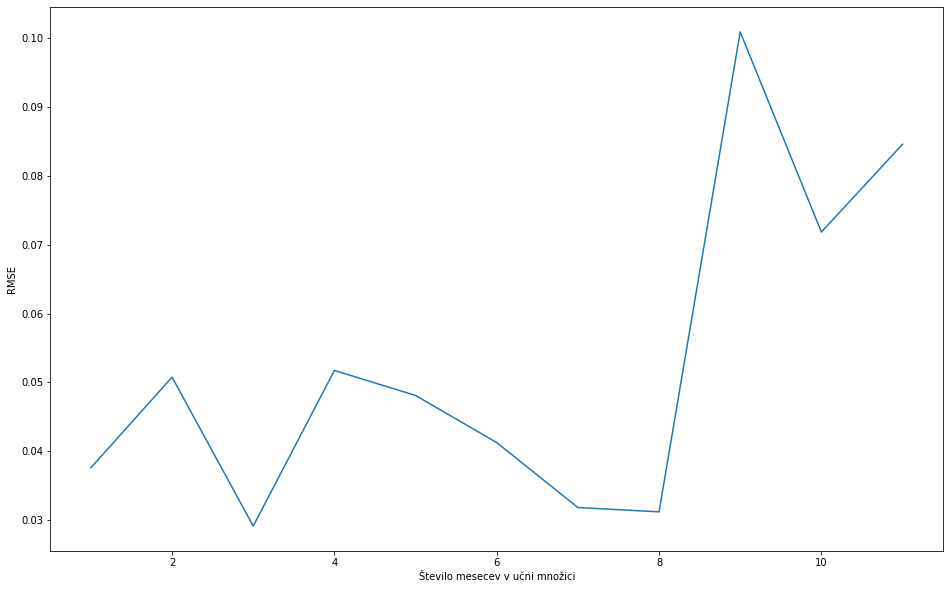

In [81]:
n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_randomForest/regression_randomForest_f_regression.pickle")
prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

clf = RandomForestRegressor(max_depth=ops["max_depth"], random_state=0, n_jobs=-1)
res = validate_regression_by_months(clf, n_features, prep_data)

print(f"Povprečna RMSE: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='RMSE')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naučenih na podatkih posameznih regiji

RMSE na testni množici (učni podatki: celotni, testni podatki: celotni): 0.01584233970524558
RMSE na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.00675530478514853
RMSE na testni množici (učni podatki: celotni, testni podatki: zahod): 0.0042981491487448014
RMSE na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.510661347967624
RMSE na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.020563933615824943
RMSE na testni množici (učni podatki: vzhod, testni podatki: zahod): 1.7831706235772342
RMSE na testni množici (učni podatki: zahod, testni podatki: celotni): 0.6508031345803613
RMSE na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.9238207134348644
RMSE na testni množici (učni podatki: zahod, testni podatki: zahod): 0.00826313048925778


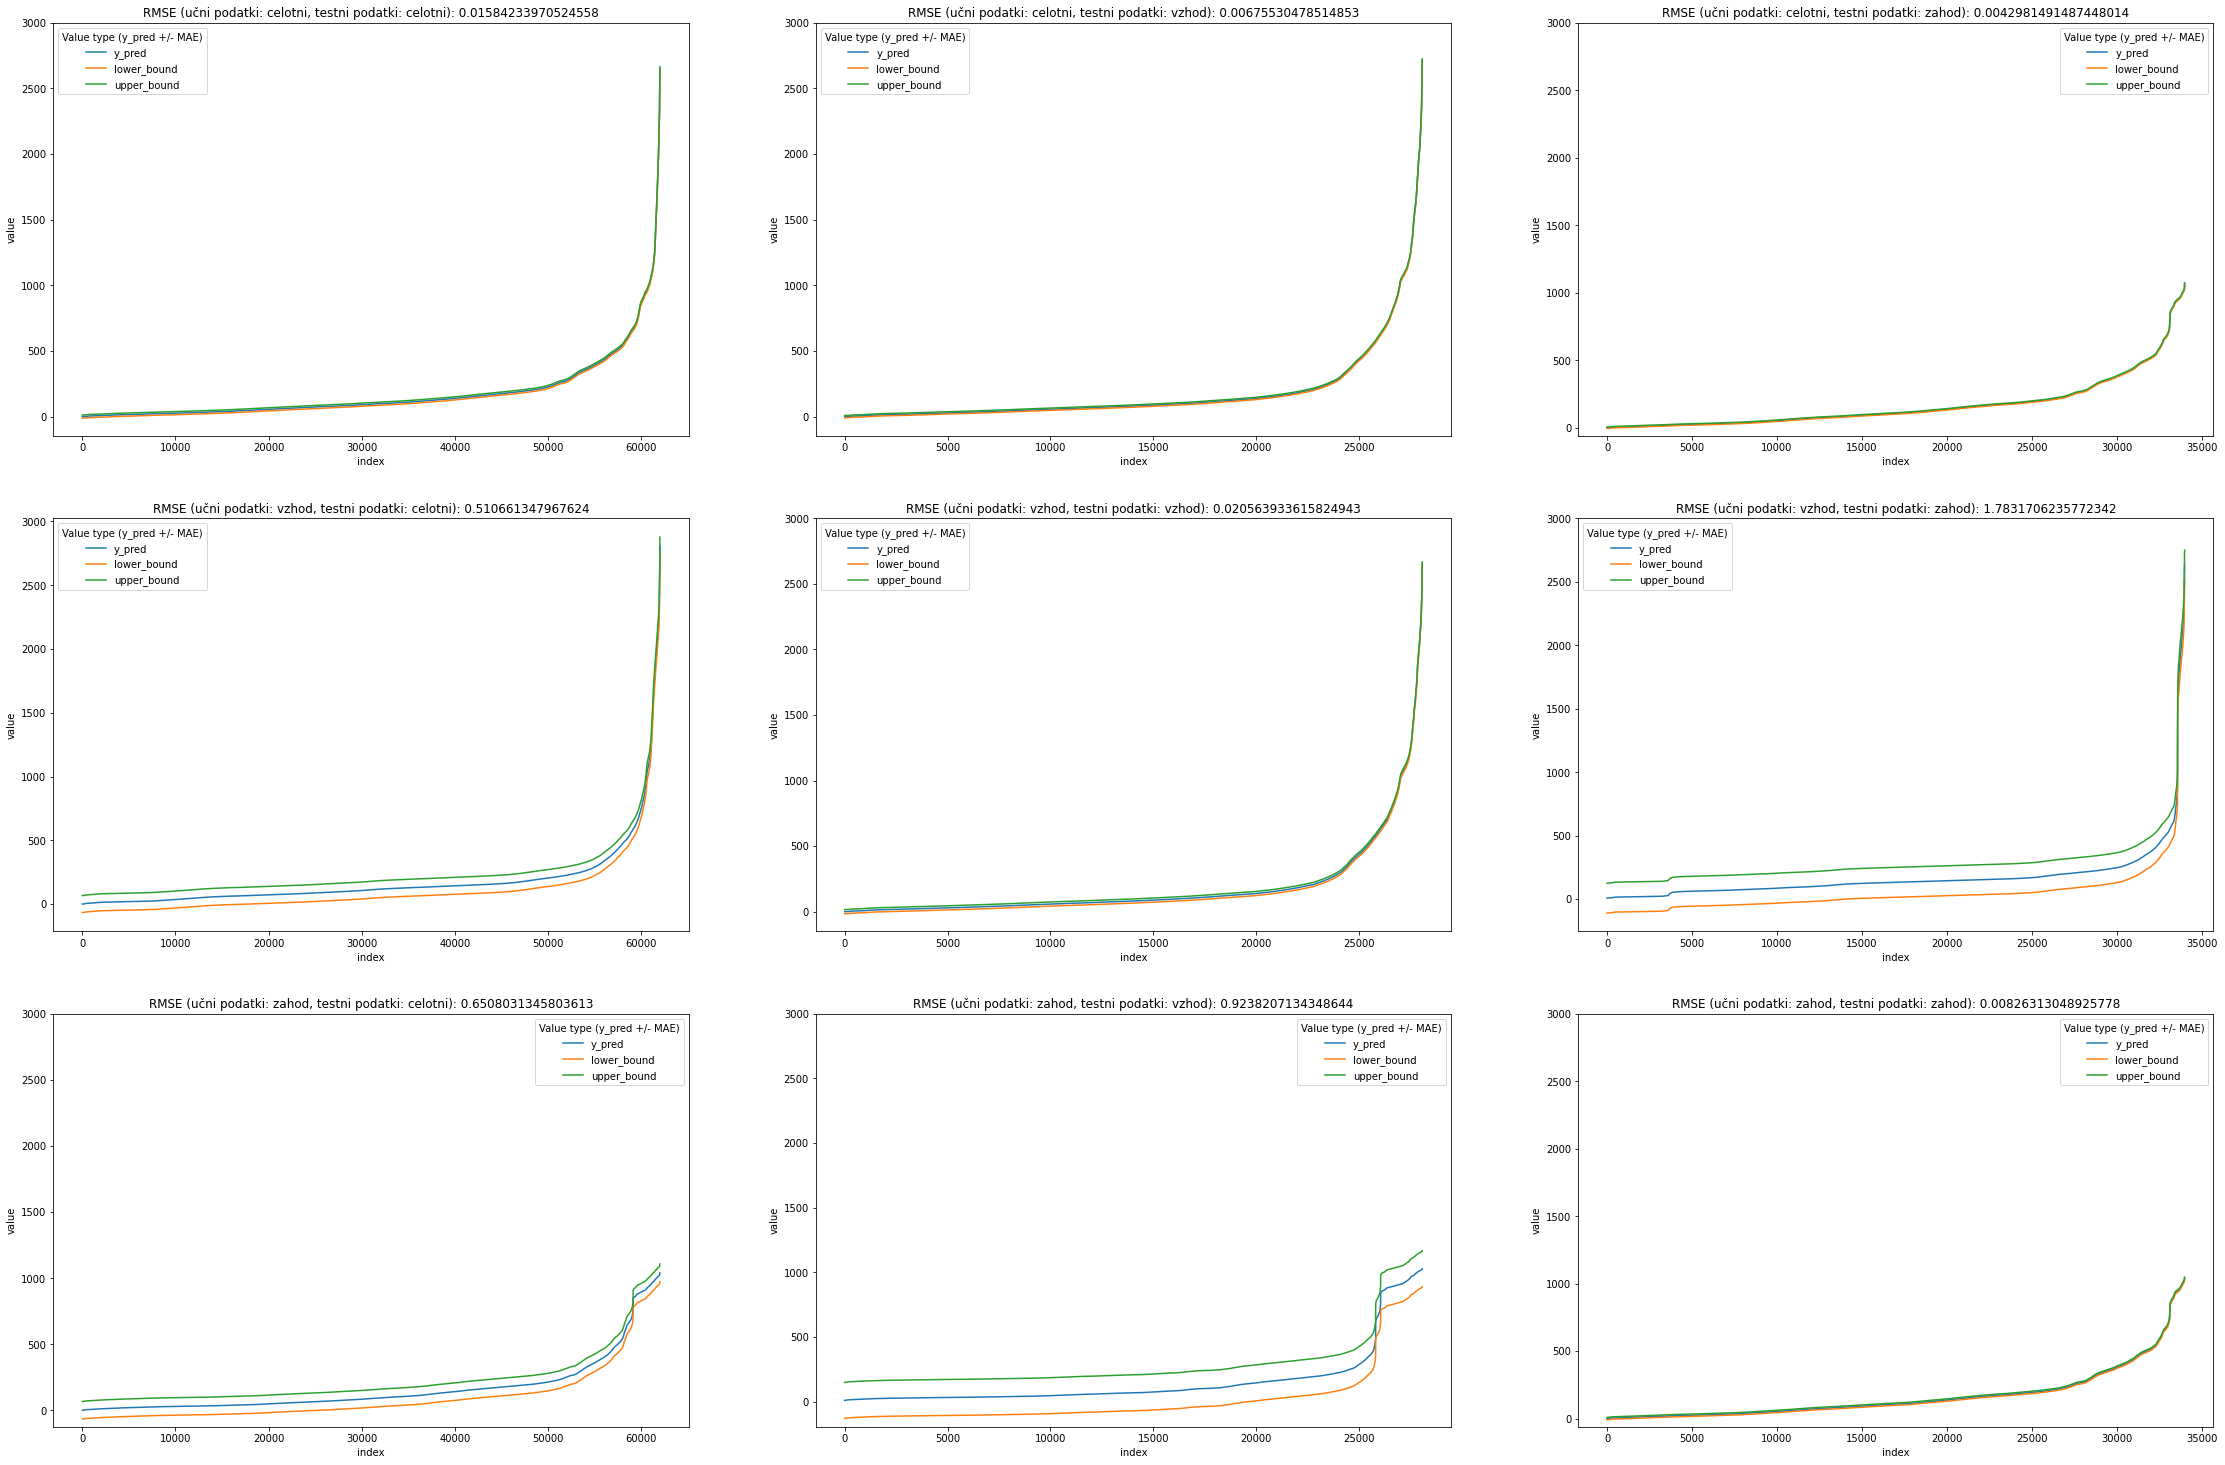

In [48]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_randomForest/regression_randomForest_f_regression.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data = one_hot(prep_data, e)

prep_data_vzhod = prep_data[prep_data["regija_vzhodna"] == 1]
prep_data_zahod = prep_data[prep_data["regija_zahodna"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "poraba", transform_negative=False)
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "poraba", transform_negative=False)
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "poraba", transform_negative=False)

selector = SelectKBest(f_regression, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}

for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = RandomForestRegressor(max_depth=ops["max_depth"], random_state=0, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"RMSE na testni množici (učni podatki: {k}, testni podatki: {k2}): {RMSE(y_test, y_pred, y.mean())}")
        mae = mean_absolute_error(y_test, y_pred)
        res_data = pd.DataFrame({
            "y_pred": y_pred,
            "lower_bound": [e - mae for e in y_pred],
            "upper_bound": [e + mae for e in y_pred]

        })
        res_data = res_data.sort_values(by=['y_pred'], ignore_index=True)
        res_data =res_data.reset_index()
        res_data = res_data.melt(id_vars=["index"], var_name="Value type (y_pred +/- MAE)", value_name="value")
        sns.lineplot(data=res_data, x="index", y="value", hue="Value type (y_pred +/- MAE)", ax=ax[i, j])
        ax[i, j].set_title(f"RMSE (učni podatki: {k}, testni podatki: {k2}): {RMSE(y_test, y_pred, y.mean())}")
        yticks = [i for i in range(0, 3500, 500)]
        ax[i, j].set_yticks(yticks)

## KNN regresija

### KNN regresija (atributi izbrani z metriko f-regression)

In [ ]:
def best_regression_KNN_atributes_f_regression():
    res = dict()
    prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    y = prep_data["poraba"]
    X = prep_data.drop(columns=["poraba"])
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    for e in X.select_dtypes(include=['object']).columns:
        X = one_hot(X, e)
            
    for i in range(5, len(X.columns)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        selector = SelectKBest(f_regression, k=i)
        selector.fit(X_train, y_train)
        X_train = X_train.loc[:, selector.get_support()]
        r = (RegressionKNN_best_n_neighbours(X_train, y_train, 1,  40, y))
        print(i, ":", r)

        res[i] = r

    pickle.dump(res, open("pickled_data/regression_knn/regression_knn_f_regression.pickle", "wb"))

# best_regression_KNN_atributes_f_regression()

Najboljša RMSE na validacijski množici: 0.039032476069527165 (# atributov: 17)
RMSE na testni množici: 0.03735721714102302
Root Mean Squared Error na testni množici: 49.13799290124059
Test Mean Absolute Error na testni množici: 19.96858449932297
Izbrani atributi:
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_rosisca', 'teden', 'dan', 'vikend', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'regija_vzhodna', 'regija_zahodna', 'namembnost_izobrazevalna', 'namembnost_javno_storitvena', 'namembnost_kulturno_razvedrilna', 'namembnost_poslovna', 'namembnost_stanovanjska']


Text(0.5, 1.0, 'Napovedane in dejanske vrednosti (0.005 testne množice)')

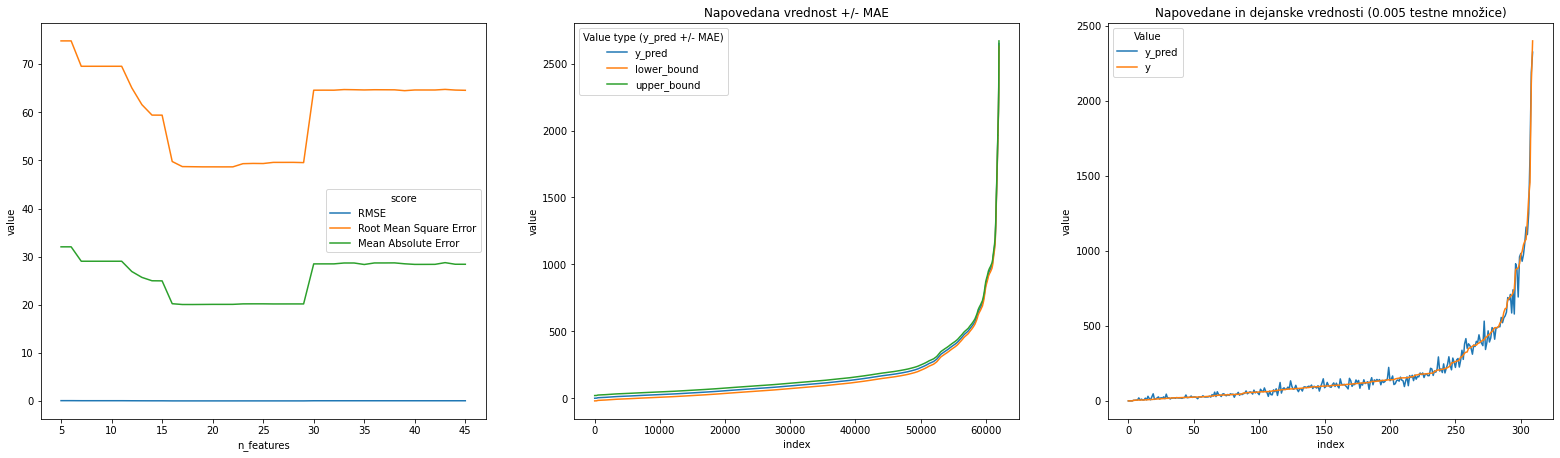

In [49]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(left=0, right=3.5, top=1.5)

plot_regression_validation_acc("pickled_data/regression_knn/regression_knn_f_regression.pickle")
n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_knn/regression_knn_f_regression.pickle")

print(f"Najboljša RMSE na validacijski množici: {rmse} (# atributov: {n_features})")

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
y = prep_data["poraba"]
X = prep_data.drop(columns=["poraba"])
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

for e in X.select_dtypes(include=['object']).columns:
    X = one_hot(X, e)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    
selector = SelectKBest(f_regression, k=n_features)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

clf = KNeighborsRegressor(n_neighbors=ops["n_neighbors"])
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
print(f"RMSE na testni množici: {RMSE(y_test, y_pred_test, y.mean())}")
print(f"Root Mean Squared Error na testni množici: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")
print(f"Mean Absolute Error na testni množici: {mean_absolute_error(y_test, y_pred_test)}")

print("Izbrani atributi:")
print(X_train.columns.tolist())

mae = mean_absolute_error(y_test, y_pred_test)
data = pd.DataFrame({
    "y_pred": y_pred_test,
    "lower_bound": [e - mae for e in y_pred_test],
    "upper_bound": [e + mae for e in y_pred_test]

})

data = data.sort_values(by=['y_pred'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value type (y_pred +/- MAE)", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value type (y_pred +/- MAE)", ax=ax[1]).set_title("Napovedana vrednost +/- MAE")

data = pd.DataFrame({
    "y_pred": y_pred_test,
    "y": y_test
})

data = data.sample(frac=0.005, random_state=0)
data = data.sort_values(by=['y'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value", ax=ax[2]).set_title("Napovedane in dejanske vrednosti (0.005 testne množice)")

### Ovrednotenje modela na mesečnih podatkih ({januar} proti {februar}, {januar, februar} proti {marec}, ....) 

Število mesecev v učni množici: 1, RMSE: 0.05944988957569023
Število mesecev v učni množici: 2, RMSE: 0.07157149643414498
Število mesecev v učni množici: 3, RMSE: 0.057713932429109646
Število mesecev v učni množici: 4, RMSE: 0.06728539716908996
Število mesecev v učni množici: 5, RMSE: 0.07771464213283569
Število mesecev v učni množici: 6, RMSE: 0.06026289037323355
Število mesecev v učni množici: 7, RMSE: 0.0856493060318153
Število mesecev v učni množici: 8, RMSE: 0.07092901241897932
Število mesecev v učni množici: 9, RMSE: 0.10445569872207636
Število mesecev v učni množici: 10, RMSE: 0.09045127955445796
Število mesecev v učni množici: 11, RMSE: 0.10310552009743798
Povprečna RMSE: 0.07714446044898828


<AxesSubplot:xlabel='Število mesecev v učni množici', ylabel='RMSE'>

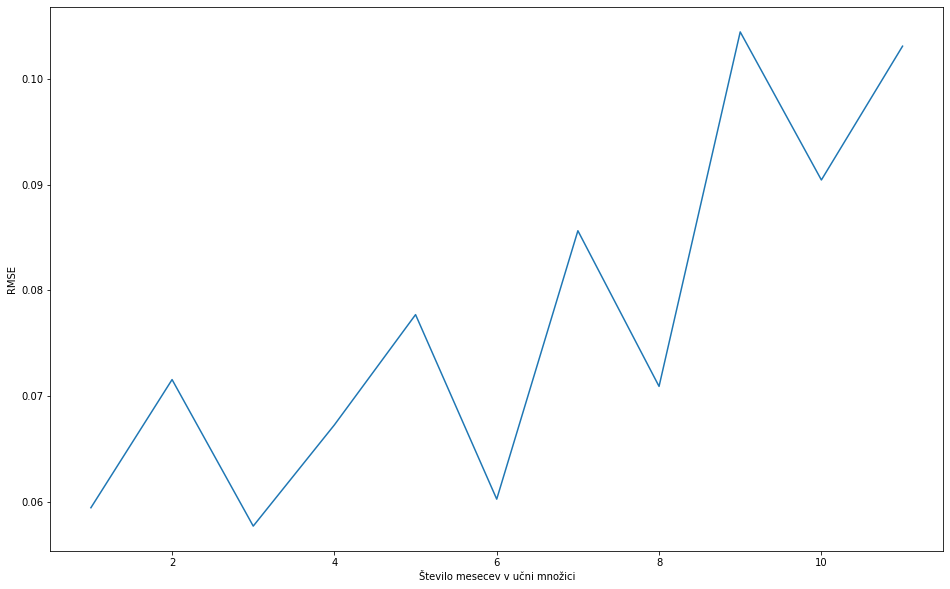

In [82]:
n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_knn/regression_knn_f_regression.pickle")
prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
prep_data = add_rolling_mean(prep_data, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

clf = KNeighborsRegressor(n_neighbors=ops["n_neighbors"])
res = validate_regression_by_months(clf, n_features, prep_data)


print(f"Povprečna RMSE: {np.array(list(res.values())).mean()}")
f, ax = plt.subplots(figsize=(16,10))
ax.set(xlabel='Število mesecev v učni množici', ylabel='RMSE')
sns.lineplot(x=res.keys(), y=[e for e in res.values()], ax=ax)

### Primerjava modelov naučenih na podatkih posameznih regiji

RMSE na testni množici (učni podatki: celotni, testni podatki: celotni): 0.03735721714102302
RMSE na testni množici (učni podatki: celotni, testni podatki: vzhod): 0.03364753743821034
RMSE na testni množici (učni podatki: celotni, testni podatki: zahod): 0.013195718112206942
RMSE na testni množici (učni podatki: vzhod, testni podatki: celotni): 0.6156933771553422
RMSE na testni množici (učni podatki: vzhod, testni podatki: vzhod): 0.04453181950504112
RMSE na testni množici (učni podatki: vzhod, testni podatki: zahod): 2.0739923788369707
RMSE na testni množici (učni podatki: zahod, testni podatki: celotni): 0.6698893963391402
RMSE na testni množici (učni podatki: zahod, testni podatki: vzhod): 0.962152213058865
RMSE na testni množici (učni podatki: zahod, testni podatki: zahod): 0.01685706372233309


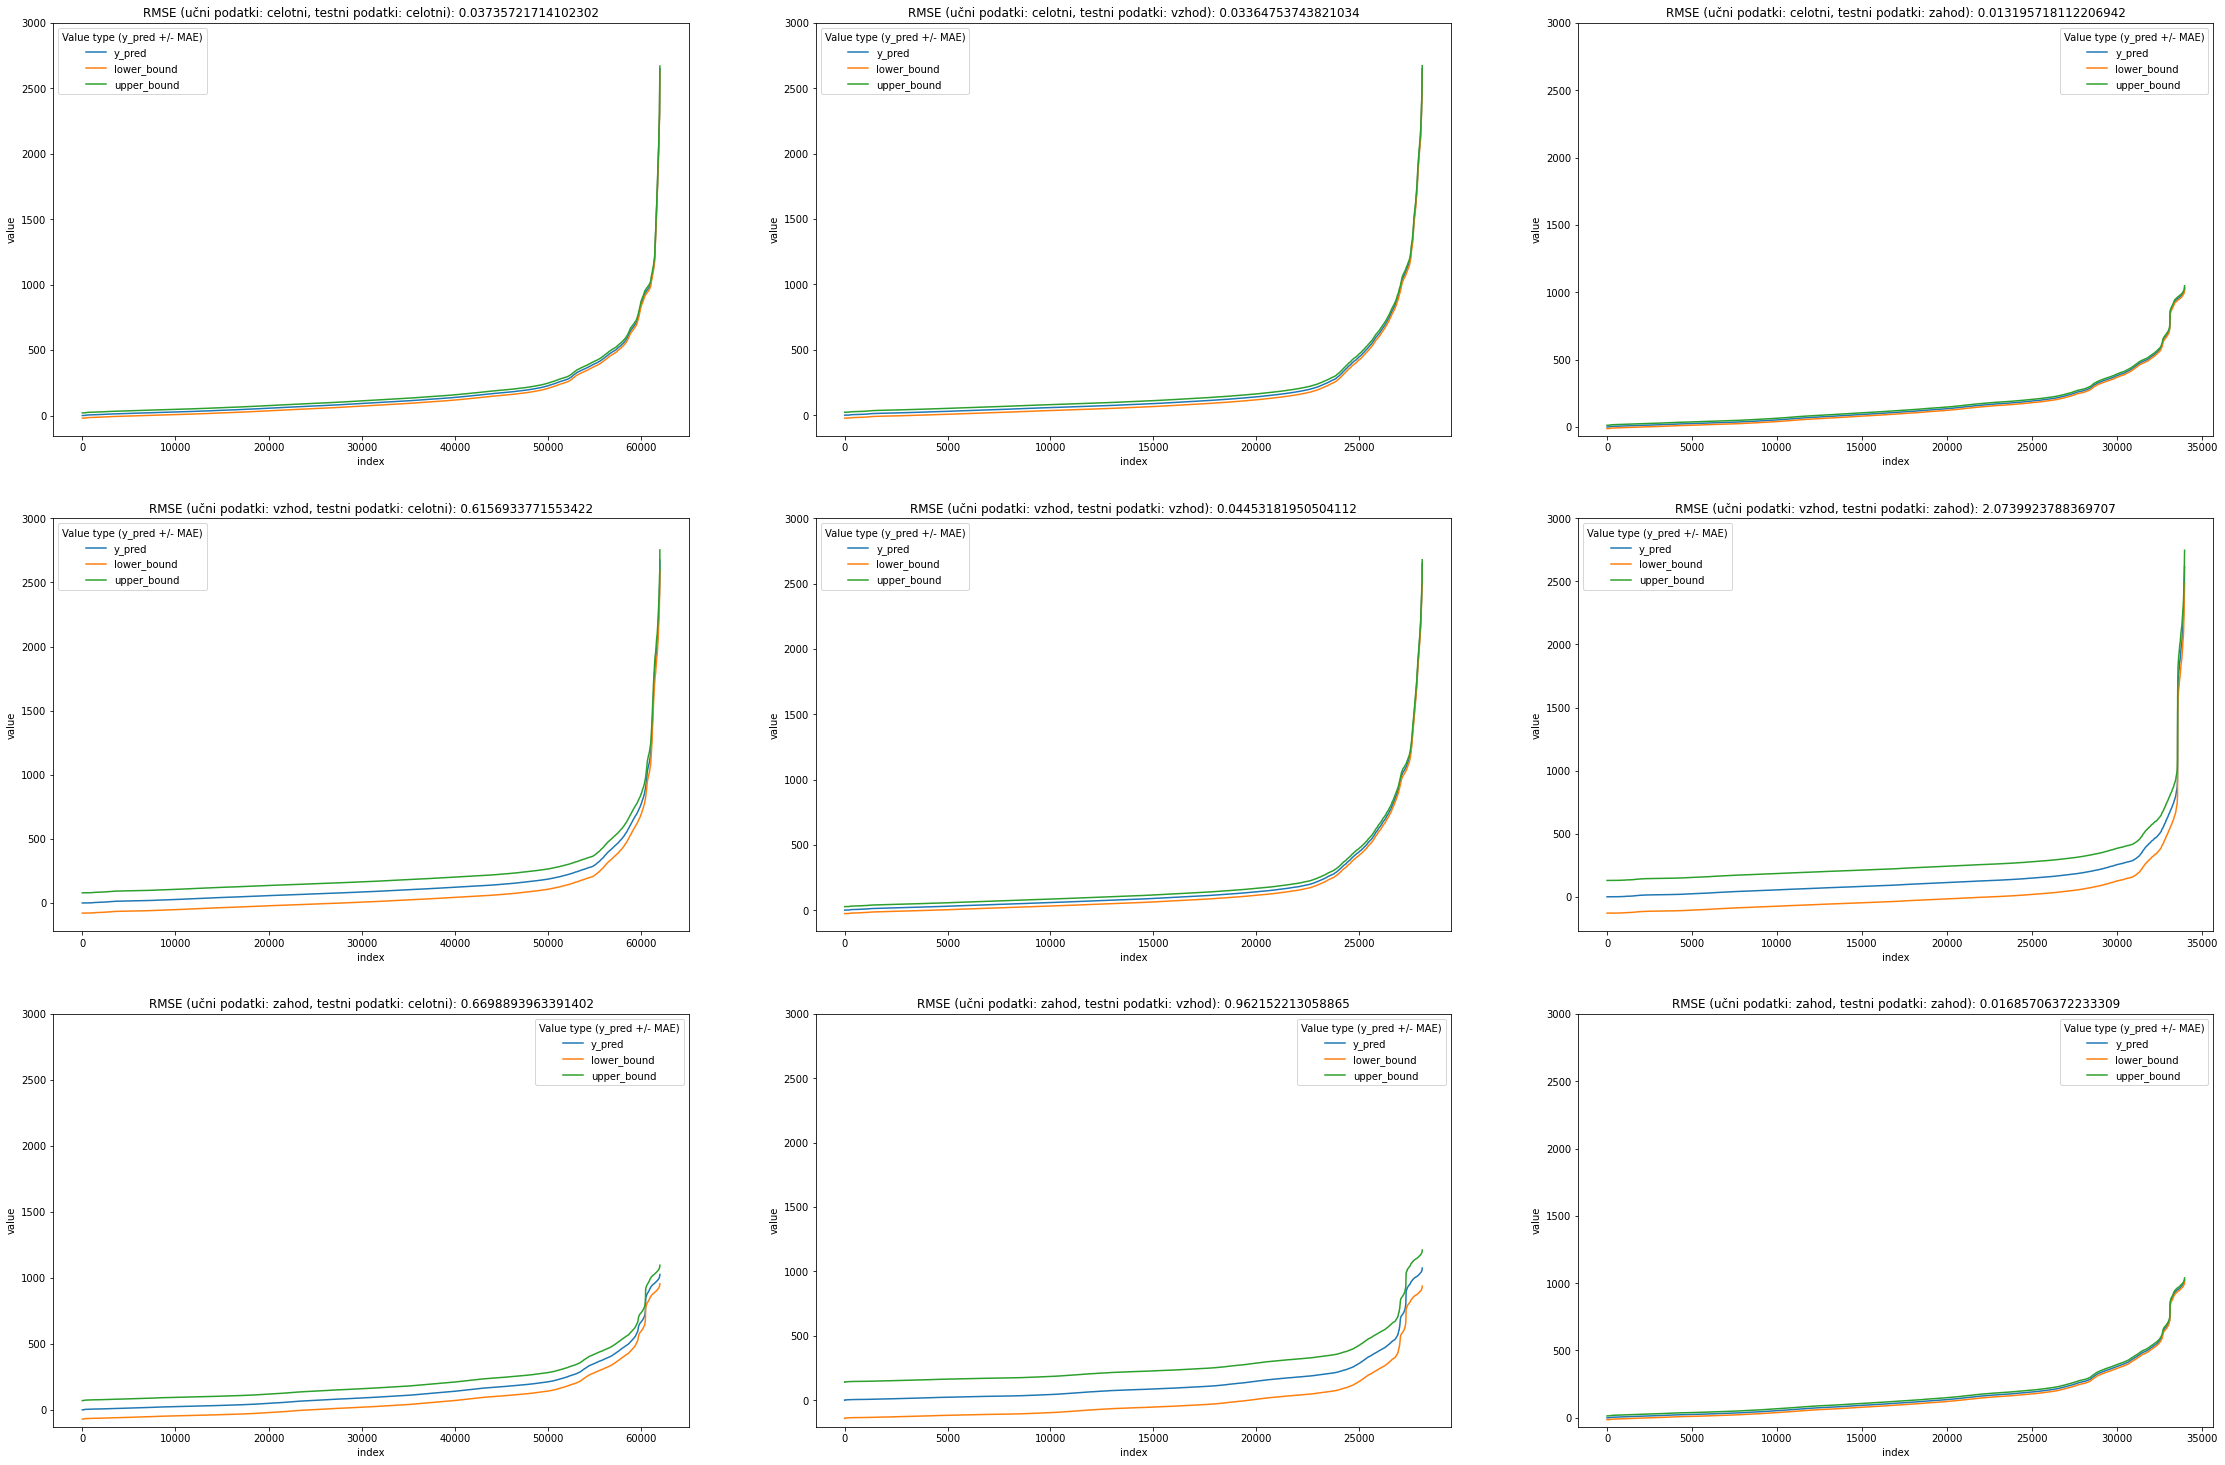

In [52]:
f, ax = plt.subplots(3, 3)
plt.subplots_adjust(left=0, right=5, top=5)

n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle("pickled_data/regression_knn/regression_knn_f_regression.pickle")

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    
for e in prep_data.select_dtypes(include=['object']).columns:
    prep_data = one_hot(prep_data, e)

prep_data_vzhod = prep_data[prep_data["regija_vzhodna"] == 1]
prep_data_zahod = prep_data[prep_data["regija_zahodna"] == 1]

X, y, X_train, X_test, y_train, y_test = split_data_by_region_and_split(prep_data, "poraba", transform_negative=False)
X_vzhod, y_vzhod, X_train_vzhod, X_test_vzhod, y_train_vzhod, y_test_vzhod = split_data_by_region_and_split(prep_data_vzhod, "poraba", transform_negative=False)
X_zahod, y_zahod, X_train_zahod, X_test_zahod, y_train_zahod, y_test_zahod = split_data_by_region_and_split(prep_data_zahod, "poraba", transform_negative=False)

selector = SelectKBest(f_regression, k=n_features)
selector.fit(X_train, y_train)

X_train, X_test = prep_data_by_region(X_train, X_test, selector.get_support())
X_train_zahod, X_test_zahod = prep_data_by_region(X_train_zahod, X_test_zahod, selector.get_support())
X_train_vzhod, X_test_vzhod = prep_data_by_region(X_train_vzhod, X_test_vzhod, selector.get_support())

data = {
    "celotni": (X_train, y_train, X_test, y_test),
    "vzhod": ((X_train_vzhod, y_train_vzhod, X_test_vzhod, y_test_vzhod)),
    "zahod": ((X_train_zahod, y_train_zahod, X_test_zahod, y_test_zahod))
}

for i, (k,v) in enumerate(data.items()):
    for j, (k2,v2) in enumerate(data.items()):
        X_train, y_train, _, _ = v
        _, _, X_test, y_test = v2
        clf = KNeighborsRegressor(n_neighbors=ops["n_neighbors"])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"RMSE na testni množici (učni podatki: {k}, testni podatki: {k2}): {RMSE(y_test, y_pred, y.mean())}")
        mae = mean_absolute_error(y_test, y_pred)
        res_data = pd.DataFrame({
            "y_pred": y_pred,
            "lower_bound": [e - mae for e in y_pred],
            "upper_bound": [e + mae for e in y_pred]

        })
        res_data = res_data.sort_values(by=['y_pred'], ignore_index=True)
        res_data =res_data.reset_index()
        res_data = res_data.melt(id_vars=["index"], var_name="Value type (y_pred +/- MAE)", value_name="value")
        sns.lineplot(data=res_data, x="index", y="value", hue="Value type (y_pred +/- MAE)", ax=ax[i, j])
        ax[i, j].set_title(f"RMSE (učni podatki: {k}, testni podatki: {k2}): {RMSE(y_test, y_pred, y.mean())}")
        yticks = [i for i in range(0, 3500, 500)]
        ax[i, j].set_yticks(yticks)

## Glasovanje in uteženo glasovanje (atributi izbrani z metriko f-regression)

In [53]:
def make_RandomForestRegression(ops):
    return RandomForestRegressor(random_state=0, n_jobs=-1)

def make_DecisionTreeRegression(ops):
    return DecisionTreeRegressor(max_depth=ops["max_depth"], random_state=0)

def make_KNNRegression(ops):
    return KNeighborsRegressor(n_neighbors=ops["n_neighbors"], n_jobs=-1)

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
y = prep_data["poraba"]
X = prep_data.drop(columns=["poraba"])
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

for e in X.select_dtypes(include=['object']).columns:
    X = one_hot(X, e)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clfs = {
    "RandomForest": { 
        "file": "pickled_data/regression_randomForest/regression_randomForest_f_regression.pickle",
        "clf": make_RandomForestRegression
    },
    "DecisionTree": {
        "file": "pickled_data/regression_tree/regression_tree_f_regression.pickle",
        "clf": make_DecisionTreeRegression
    },
    "KNN": {
        "file": "pickled_data/regression_knn/regression_knn_f_regression.pickle",
        "clf": make_KNNRegression
    },
}

weights = [0.8, 0.1, 0.1]


for k,v in clfs.items():
    n_features, ops, rmse, nrmse, nmae = get_best_regression_from_pickle(v["file"])
    selector = SelectKBest(f_regression, k=n_features)
    selector.fit(X_train, y_train)
    X_train_ = X_train.loc[:, selector.get_support()]
    clf = v["clf"](ops).fit(X_train_, y_train)
    clfs[k]["clf"] = clf
    clfs[k]["cols"] = selector.get_support()

for k,v in clfs.items():
    X_test_ = X_test.loc[:, v["cols"]]
    clfs[k]["pred_prob"] = v["clf"].predict(X_test_)



pred_prob = np.asarray([pred for pred in zip(*[e["pred_prob"] for e in clfs.values()])])
pred_prob = np.average(pred_prob, axis=1)

pred_prob_weighted = np.asarray([pred for pred in zip(*[e["pred_prob"] for e in clfs.values()])])
pred_prob_weighted = np.average(pred_prob_weighted, weights=weights, axis=1)


for k,v in clfs.items():
    print(f"{k}: {RMSE(y_test, v['pred_prob'], y.mean())}")
    
    
print(f"RMSE pri glasovanju na podlagi povprečja verjetnosti (soft voting): {RMSE(y_test, pred_prob, y.mean())}")
print(f"RMSE pri glasovanju na podlagi uteženega povprečja verjetnosti (weighted soft voting): {RMSE(y_test, pred_prob_weighted, y.mean())}")

RandomForest: 0.015877842688136953
DecisionTree: 0.02759171769855038
KNN: 0.03735721714102302
RMSE pri glasovanju na podlagi povprečja verjetnosti (soft voting): 0.018759602374150343
RMSE pri glasovanju na podlagi uteženega povprečja verjetnosti (weighted soft voting): 0.01594005447256969


## Regresija z globoko nevronsko mrežo (atributi izbrani z metriko f-regression)

In [ ]:
def make_dnn_regrssion():
    prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
    y = prep_data["poraba"]
    X = prep_data.drop(columns=["poraba"])
    X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

    for e in X.select_dtypes(include=['object']).columns:
        X = one_hot(X, e)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    selector = SelectKBest(f_regression, k=23)
    selector.fit(X_train, y_train)

    X_train = X_train.loc[:, selector.get_support()]
    X_test = X_test.loc[:, selector.get_support()]

    for e in X_test.columns:
        if e not in ("vikend"):
            scaler = StandardScaler()
            scaler.fit(X[[e]])
            X_test[[e]] = scaler.transform(X_test[[e]])
            X_train[[e]] = scaler.transform(X_train[[e]])
            
    with tf.device('/GPU:0'):
        model = Sequential()
        model.add(Dense(512, input_dim=X_test.shape[1], activation="relu"))
        model.add(Dense(256, activation="relu"))
        model.add(Dense(256, activation="relu"))
        model.add(Dense(256, activation="relu"))
        model.add(Dense(1, activation="linear"))
        lr_schedule = ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=10000,
            decay_rate=0.9
        )
        opt = Adam(learning_rate=lr_schedule)
        model.compile(loss="mse", optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])

        model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)
        model.save("models/regression_model")

# make_dnn_regrssion()

RMSE na testni množici: 0.02185764041000098
Root Mean Squared Error na testni množici: 37.586491914799375
Test Mean Absolute Error na testni množici: 15.116510818633975
Izbrani atributi (# atributov: 23):
['ura', 'stavba', 'povrsina', 'leto_izgradnje', 'temp_rosisca', 'pritisk', 'mesec', 'teden', 'dan', 'vikend', 'temp_rosisca_MA_7', 'temp_rosisca_MA_14', 'temp_rosisca_MA_21', 'temp_rosisca_MA_28', 'hitrost_vetra_MA_21', 'hitrost_vetra_MA_28', 'regija_vzhodna', 'regija_zahodna', 'namembnost_izobrazevalna', 'namembnost_javno_storitvena', 'namembnost_kulturno_razvedrilna', 'namembnost_poslovna', 'namembnost_stanovanjska']


Text(0.5, 1.0, 'Napovedane in dejanske vrednosti (0.005 testne množice)')

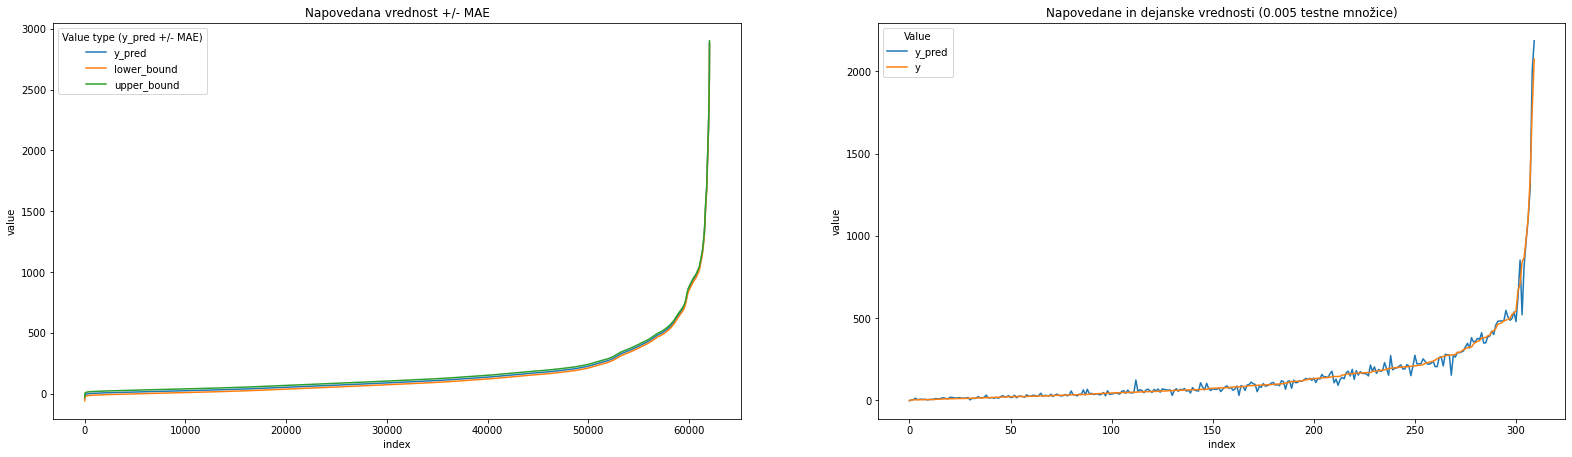

In [56]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=0, right=3.5, top=1.5)

model = load_model("models/regression_model/")

prep_data = raw_data.drop(columns=["datetime", "datum", "norm_poraba"])
y = prep_data["poraba"]
X = prep_data.drop(columns=["poraba"])
X = add_rolling_mean(X, "stavba", ["temp_zraka", "temp_rosisca", "oblacnost", "padavine", "pritisk", "hitrost_vetra"], [7, 14, 21, 28], min_eq_max=False)

for e in X.select_dtypes(include=['object']).columns:
    X = one_hot(X, e)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    
selector = SelectKBest(f_regression, k=23)
selector.fit(X_train, y_train)

X_train = X_train.loc[:, selector.get_support()]
X_test = X_test.loc[:, selector.get_support()]

for e in X_test.columns:
    if e not in ("vikend"):
        scaler = StandardScaler()
        scaler.fit(X[[e]])
        X_test[[e]] = scaler.transform(X_test[[e]])
        X_train[[e]] = scaler.transform(X_train[[e]])

y_pred_test = model.predict(X_test)
y_pred_test = y_pred_test.flatten()
print(f"RMSE na testni množici: {RMSE(y_test, y_pred_test, y.mean())}")
print(f"Root Mean Squared Error na testni množici: {np.sqrt(mean_squared_error(y_test, y_pred_test))}")
print(f"Mean Absolute Error na testni množici: {mean_absolute_error(y_test, y_pred_test)}")

print(f"Izbrani atributi (# atributov: {len(X_train.columns)}):")
print(X_train.columns.tolist())

mae = mean_absolute_error(y_test, y_pred_test)
data = pd.DataFrame({
    "y_pred": y_pred_test,
    "lower_bound": [e - mae for e in y_pred_test],
    "upper_bound": [e + mae for e in y_pred_test]

})

data = data.sort_values(by=['y_pred'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value type (y_pred +/- MAE)", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value type (y_pred +/- MAE)", ax=ax[0]).set_title("Napovedana vrednost +/- MAE")

data = pd.DataFrame({
    "y_pred": y_pred_test,
    "y": y_test
})

data = data.sample(frac=0.005, random_state=0)
data = data.sort_values(by=['y'], ignore_index=True)
data = data.reset_index()
data = data.melt(id_vars=["index"], var_name="Value", value_name="value")
sns.lineplot(data=data, x="index", y="value", hue="Value", ax=ax[1]).set_title("Napovedane in dejanske vrednosti (0.005 testne množice)")